In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_v2.jl")
working_dir = "C:\\Google Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
;

In [3]:
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if abs(times[i][end] - t_end*1e3) <= 1.0
            push!(_survived, i)
        end
    end
    return _survived
end

function cloud_size(trajectories, i)
    std(trajectory[i] for trajectory ∈ trajectories)
end

"""
    Evaluates the density given a set of trajectories.
"""
function density(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = length(_survived)
    _density = Float64(n)
    if n > 1
        idx_end = length(surviving_x_trajectories[1])
        σ_x = cloud_size(surviving_x_trajectories, idx_end)
        σ_y = cloud_size(surviving_y_trajectories, idx_end)
        σ_z = cloud_size(surviving_z_trajectories, idx_end)
        _density /= σ_x * σ_y * σ_z
    end
    return _density
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end

goodness_val(r) = r <= 0.8 ? (0.8 - r)^3 : 0
"""
    Evaluates how many particles are within a 0.3 mm radius.
"""
function goodness(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    @printf("Survival: %i / %i", length(_survived), n_molecules)
    println()
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        r = distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end)
        n += goodness_val(r) * exp(-results.photons_scattered[survived_idx] / 15000)
    end
    return n/n_molecules
end
;

### Set up the molecule

In [4]:
package = get_CaOH_package()
n_states = length(package.states)
n_excited = package.n_excited
;

In [5]:
"""
    Function to optimize (density).
"""
function f(x)
    s1 = x[1]
    s3 = x[2]
    s4 = x[3]
    Δ1 = x[4]*Γ
    Δ3 = Δ1
    Δ4 = x[5]*Γ
    ramp_time = 10e-3
    B_gradient = 90

    temp = @with_unit 0.050 "mK"
    diameter = @with_unit 2.5 "mm"
    displacement = [0.0, 0.0, 0.0]
    kick = [0,0, 0.0, 0.0]
    
    params = MutableNamedTuple(
        t_end=20e-3, n_values=20,
        # pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁺, pol4_x=σ⁻, 
        pol1_x=σ⁺, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, # weird polarizations
        s1=s1, s2=0., s3=s3, s4=s4,
        Δ1=Δ1, Δ2=0., Δ3=Δ3, Δ4=Δ4,
        B_gradient=B_gradient,
        temp=temp, 
        diameter=diameter,
        displacement=displacement, 
        kick=kick,
        ramp_time=ramp_time,
        pol_imbalance=0.0, s_imbalance = (0.0, 0.0, 0.0))
    
    results = simulate_particles_v2(package, params)
    
    @printf("s1 = %.2f; s3 = %.2f; s4 = %.2f; Δ1 = %.2f Γ; Δ3 = Δ1; Δ4 = %.2f Γ", x[1], x[2], x[3], x[4], x[5])
    println()
    
    _goodness = goodness(params.t_end, results)
    @printf("goodness = %.3f", _goodness)
    println()
    
    return _goodness
end
;    

In [10]:
using BayesianOptimization, GaussianProcesses

model = ElasticGPE(5,                            # 6 input dimensions
                   mean = MeanConst(1.),         
                   kernel = SEArd([1., 1, 1, 1, 1], 5.),
                   logNoise = 0.,
                   capacity = 3000)              # the initial capacity of the GP is 3000 samples
set_priors!(model.mean, [Normal(1., 1.)])

# Optimize the hyperparameters of the GP using maximum a posteriori (MAP) estimates every x steps
modeloptimizer = MAPGPOptimizer(
    every = 1, 
    noisebounds = [-3, 3], # bounds of the logNoise
    kernbounds = [[-3, -3, -3, -3, -3, -5], [3, 3, 3, 3, 3, 5]],  # bounds of the parameters GaussianProcesses.get_param_names(model.kernel)
    maxeval = 1000)

opt = BOpt(f,
           model,
           ExpectedImprovement(),                   # type of acquisition
           modeloptimizer,                        
           [0.5, 3.0, 0.5, +0.5, -10.0],        # lowerbounds
           [4.0, 8.0, 6.5, +4.0, -4.0],        # upperbounds         
           repetitions = 1,                          # evaluate the function for each input x times
           maxiterations = 50,                       # evaluate at x input positions
           sense = Max,                              # maximize the function
           acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                                 restarts = 10,       # run the NLopt method from x random initial conditions each time
                                 maxtime = 1.0,      # run the NLopt method for at most 1.0 second each time
                                 maxeval = 5000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl)
           verbosity = BayesianOptimization.Progress)

# result = boptimize!(opt);
;

In [11]:
using BayesianOptimization, GaussianProcesses
using Serialization
opt_old = deserialize(joinpath(working_dir, "optimized_3freqs_smallparamspace_fixedphotonbudget_bugfixed_highgrad.jl"));
opt.model = opt_old.model;
opt.model_optimum = opt_old.model_optimum;
opt.model_optimizer = opt_old.model_optimizer;
opt.modeloptimizer = opt_old.modeloptimizer;
opt.observed_optimum = opt_old.observed_optimum;
opt.observed_optimizer = opt_old.observed_optimizer;
# opt.acquisition = opt_old.acquisition;
# opt.acquisitionoptions = opt_old.acquisitionoptions;

In [9]:
# serialize("optimized_3freqs_smallparamspace_fixedphotonbudget_bugfixed_highgrad.jl", opt)

Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


In [ ]:
using Serialization
    
while true
    maxiterations!(opt, 50)
    result = boptimize!(opt)
    serialize("optimized_3freqs_smallparamspace_fixedphotonbudget_bugfixed_highgrad.jl", opt)
    println("===== Autosaved =====")
end

s1 = 0.83; s3 = 5.34; s4 = 3.31; Δ1 = 2.80 Γ; Δ3 = Δ1; Δ4 = -8.31 Γ
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:01:05
Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


s1 = 2.58; s3 = 7.84; s4 = 6.31; Δ1 = 1.05 Γ; Δ3 = Δ1; Δ4 = -5.31 Γ
Survival: 7 / 20
goodness = 0.004


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


s1 = 3.45; s3 = 4.09; s4 = 1.81; Δ1 = 3.67 Γ; Δ3 = Δ1; Δ4 = -6.81 Γ
Survival: 4 / 20
goodness = 0.013


Progress: 100%|█████████████████████████████████████████| Time: 0:01:58


s1 = 1.70; s3 = 6.59; s4 = 4.81; Δ1 = 1.92 Γ; Δ3 = Δ1; Δ4 = -9.81 Γ
Survival: 8 / 20
goodness = 0.015


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 2.14; s3 = 3.47; s4 = 5.56; Δ1 = 1.48 Γ; Δ3 = Δ1; Δ4 = -9.06 Γ
Survival: 2 / 20
goodness = 0.007


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


s1 = 3.89; s3 = 5.97; s4 = 2.56; Δ1 = 3.23 Γ; Δ3 = Δ1; Δ4 = -6.06 Γ
Survival: 11 / 20
goodness = 0.026


Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


s1 = 3.02; s3 = 4.72; s4 = 4.06; Δ1 = 0.61 Γ; Δ3 = Δ1; Δ4 = -4.56 Γ
Survival: 7 / 20
goodness = 0.009


Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


s1 = 1.27; s3 = 7.22; s4 = 1.06; Δ1 = 2.36 Γ; Δ3 = Δ1; Δ4 = -7.56 Γ
Survival: 7 / 20
goodness = 0.009


Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


s1 = 1.05; s3 = 3.78; s4 = 3.69; Δ1 = 3.45 Γ; Δ3 = Δ1; Δ4 = -4.94 Γ
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:02:26


s1 = 2.80; s3 = 6.28; s4 = 0.69; Δ1 = 1.70 Γ; Δ3 = Δ1; Δ4 = -7.94 Γ
Survival: 7 / 20
goodness = 0.010


Progress: 100%|█████████████████████████████████████████| Time: 0:02:00


s1 = 3.67; s3 = 5.03; s4 = 5.19; Δ1 = 2.58 Γ; Δ3 = Δ1; Δ4 = -9.44 Γ
Survival: 7 / 20
goodness = 0.017


s1 = 1.92; s3 = 7.53; s4 = 2.19; Δ1 = 0.83 Γ; Δ3 = Δ1; Δ4 = -6.44 Γ
Survival: 9 / 20
goodness = 0.007


Progress: 100%|█████████████████████████████████████████| Time: 0:01:05
Progress: 100%|█████████████████████████████████████████| Time: 0:01:55


s1 = 1.48; s3 = 4.41; s4 = 1.44; Δ1 = 1.27 Γ; Δ3 = Δ1; Δ4 = -5.69 Γ
Survival: 5 / 20
goodness = 0.010


Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


s1 = 3.23; s3 = 6.91; s4 = 4.44; Δ1 = 3.02 Γ; Δ3 = Δ1; Δ4 = -8.69 Γ
Survival: 2 / 20
goodness = 0.003


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


s1 = 2.36; s3 = 3.16; s4 = 2.94; Δ1 = 2.14 Γ; Δ3 = Δ1; Δ4 = -7.19 Γ
Survival: 3 / 20
goodness = 0.013


Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


s1 = 0.61; s3 = 5.66; s4 = 5.94; Δ1 = 3.89 Γ; Δ3 = Δ1; Δ4 = -4.19 Γ
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 0.66; s3 = 4.33; s4 = 4.72; Δ1 = 2.41 Γ; Δ3 = Δ1; Δ4 = -9.16 Γ
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


s1 = 2.41; s3 = 6.83; s4 = 1.72; Δ1 = 0.66 Γ; Δ3 = Δ1; Δ4 = -6.16 Γ
Survival: 12 / 20
goodness = 0.015


Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


s1 = 3.29; s3 = 3.08; s4 = 6.22; Δ1 = 3.29 Γ; Δ3 = Δ1; Δ4 = -4.66 Γ
Survival: 2 / 20
goodness = 0.002


Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


s1 = 1.54; s3 = 5.58; s4 = 3.22; Δ1 = 1.54 Γ; Δ3 = Δ1; Δ4 = -7.66 Γ
Survival: 11 / 20
goodness = 0.032


Progress: 100%|█████████████████████████████████████████| Time: 0:02:03


s1 = 1.98; s3 = 3.70; s4 = 0.97; Δ1 = 1.98 Γ; Δ3 = Δ1; Δ4 = -8.41 Γ
Survival: 6 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


s1 = 3.73; s3 = 6.20; s4 = 3.97; Δ1 = 3.73 Γ; Δ3 = Δ1; Δ4 = -5.41 Γ
Survival: 16 / 20
goodness = 0.037


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 2.85; s3 = 4.95; s4 = 2.47; Δ1 = 1.10 Γ; Δ3 = Δ1; Δ4 = -6.91 Γ
Survival: 8 / 20
goodness = 0.014


Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


s1 = 1.10; s3 = 7.45; s4 = 5.47; Δ1 = 2.85 Γ; Δ3 = Δ1; Δ4 = -9.91 Γ
Survival: 2 / 20
goodness = 0.001


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


s1 = 1.32; s3 = 3.39; s4 = 2.09; Δ1 = 3.95 Γ; Δ3 = Δ1; Δ4 = -5.78 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T10:32:11.122	iteration: 25	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03

s1 = 1.37; s3 = 7.09; s4 = 0.51; Δ1 = 0.65 Γ; Δ3 = Δ1; Δ4 = -7.50 Γ
Survival: 7 / 20
goodness = 0.005

[ Info: 2023-11-03T10:33:18.117	iteration: 26	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


s1 = 3.35; s3 = 7.01; s4 = 3.89; Δ1 = 3.13 Γ; Δ3 = Δ1; Δ4 = -5.28 Γ
Survival: 14 / 20
goodness = 0.023


[ Info: 2023-11-03T10:35:02.482	iteration: 27	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


s1 = 3.24; s3 = 4.00; s4 = 3.34; Δ1 = 3.00 Γ; Δ3 = Δ1; Δ4 = -6.52 Γ
Survival: 7 / 20
goodness = 0.028


[ Info: 2023-11-03T10:36:24.007	iteration: 28	current optimum: 0.05402633771643363
Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:05

s1 = 3.07; s3 = 5.39; s4 = 2.02; Δ1 = 3.02 Γ; Δ3 = Δ1; Δ4 = -6.47 Γ
Survival: 6 / 20
goodness = 0.019


[ Info: 2023-11-03T10:38:00.171	iteration: 29	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


s1 = 1.00; s3 = 7.97; s4 = 6.04; Δ1 = 3.91 Γ; Δ3 = Δ1; Δ4 = -8.80 Γ
Survival: 1 / 20
goodness = 0.003


[ Info: 2023-11-03T10:39:12.073	iteration: 30	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:49


s1 = 2.24; s3 = 5.10; s4 = 6.04; Δ1 = 2.43 Γ; Δ3 = Δ1; Δ4 = -6.59 Γ
Survival: 13 / 20
goodness = 0.038


[ Info: 2023-11-03T10:41:01.534	iteration: 31	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 2.70; s3 = 7.94; s4 = 1.74; Δ1 = 2.93 Γ; Δ3 = Δ1; Δ4 = -6.14 Γ
Survival: 13 / 20
goodness = 0.025


[ Info: 2023-11-03T10:42:17.336	iteration: 32	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


s1 = 2.61; s3 = 7.19; s4 = 6.13; Δ1 = 0.78 Γ; Δ3 = Δ1; Δ4 = -8.72 Γ
Survival: 5 / 20
goodness = 0.006

[ Info: 2023-11-03T10:43:43.549	iteration: 33	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


s1 = 3.72; s3 = 7.84; s4 = 2.37; Δ1 = 3.89 Γ; Δ3 = Δ1; Δ4 = -9.11 Γ
Survival: 10 / 20
goodness = 0.007


[ Info: 2023-11-03T10:45:31.536	iteration: 34	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:01


s1 = 3.29; s3 = 6.70; s4 = 0.80; Δ1 = 2.42 Γ; Δ3 = Δ1; Δ4 = -4.57 Γ
Survival: 9 / 20
goodness = 0.012


[ Info: 2023-11-03T10:47:32.889	iteration: 35	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:08


s1 = 3.15; s3 = 6.26; s4 = 0.55; Δ1 = 3.31 Γ; Δ3 = Δ1; Δ4 = -8.60 Γ
Survival: 15 / 20
goodness = 0.020


[ Info: 2023-11-03T10:49:41.998	iteration: 36	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 1.86; s3 = 7.46; s4 = 1.17; Δ1 = 0.66 Γ; Δ3 = Δ1; Δ4 = -7.69 Γ
Survival: 8 / 20
goodness = 0.008


[ Info: 2023-11-03T10:51:00.591	iteration: 37	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


s1 = 1.32; s3 = 6.00; s4 = 0.90; Δ1 = 3.99 Γ; Δ3 = Δ1; Δ4 = -4.57 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T10:52:04.303	iteration: 38	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


s1 = 1.17; s3 = 4.97; s4 = 3.01; Δ1 = 2.48 Γ; Δ3 = Δ1; Δ4 = -5.16 Γ
Survival: 4 / 20
goodness = 0.010


[ Info: 2023-11-03T10:53:09.187	iteration: 39	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:28

s1 = 2.86; s3 = 4.62; s4 = 1.50; Δ1 = 3.08 Γ; Δ3 = Δ1; Δ4 = -6.36 Γ
Survival: 7 / 20
goodness = 0.020



[ Info: 2023-11-03T10:54:37.790	iteration: 40	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


s1 = 2.11; s3 = 6.36; s4 = 4.72; Δ1 = 1.42 Γ; Δ3 = Δ1; Δ4 = -9.64 Γ
Survival: 8 / 20
goodness = 0.008


[ Info: 2023-11-03T10:56:03.623	iteration: 41	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


s1 = 3.97; s3 = 3.52; s4 = 1.50; Δ1 = 0.61 Γ; Δ3 = Δ1; Δ4 = -9.60 Γ
Survival: 3 / 20
goodness = 0.006


[ Info: 2023-11-03T10:57:09.133	iteration: 42	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:28

s1 = 0.89; s3 = 5.06; s4 = 5.50; Δ1 = 1.37 Γ; Δ3 = Δ1; Δ4 = -6.39 Γ
Survival: 6 / 20
goodness = 0.008



[ Info: 2023-11-03T10:58:37.797	iteration: 43	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


s1 = 2.55; s3 = 3.55; s4 = 2.18; Δ1 = 1.18 Γ; Δ3 = Δ1; Δ4 = -7.17 Γ
Survival: 2 / 20
goodness = 0.006

[ Info: 2023-11-03T10:59:42.450	iteration: 44	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06

s1 = 1.38; s3 = 3.18; s4 = 0.51; Δ1 = 1.01 Γ; Δ3 = Δ1; Δ4 = -9.29 Γ
Survival: 1 / 20
goodness = 0.002



[ Info: 2023-11-03T11:00:49.572	iteration: 45	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


s1 = 3.21; s3 = 6.71; s4 = 5.07; Δ1 = 0.81 Γ; Δ3 = Δ1; Δ4 = -7.51 Γ
Survival: 8 / 20
goodness = 0.007

[ Info: 2023-11-03T11:02:23.222	iteration: 46	current optimum: 0.05402633771643363


s1 = 0.96; s3 = 3.43; s4 = 4.56; Δ1 = 1.33 Γ; Δ3 = Δ1; Δ4 = -5.34 Γ
Survival: 3 / 20
goodness = 0.009


Progress: 100%|█████████████████████████████████████████| Time: 0:01:09
[ Info: 2023-11-03T11:03:33.102	iteration: 47	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 1.83; s3 = 6.37; s4 = 1.63; Δ1 = 0.70 Γ; Δ3 = Δ1; Δ4 = -8.43 Γ
Survival: 10 / 20
goodness = 0.013

[ Info: 2023-11-03T11:04:51.901	iteration: 48	current optimum: 0.05402633771643363


s1 = 2.36; s3 = 6.28; s4 = 4.89; Δ1 = 0.51 Γ; Δ3 = Δ1; Δ4 = -9.75 Γ
Survival: 10 / 20


Progress: 100%|█████████████████████████████████████████| Time: 0:01:35
[ Info: 2023-11-03T11:06:27.827	iteration: 49	current optimum: 0.05402633771643363


goodness = 0.014


Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


s1 = 3.29; s3 = 7.55; s4 = 1.46; Δ1 = 1.80 Γ; Δ3 = Δ1; Δ4 = -8.09 Γ
Survival: 7 / 20
goodness = 0.004


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            1.21h / 100.0%           1.49GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    1.21h   99.8%   87.2s    670MiB   44.0%  13.4MiB
│  model hyperparamet...     26    7.71s    0.2%   297ms    592MiB   38.9%  22.8MiB
│  acquisition               26    2.62s    0.1%   101ms    259MiB   17.0%  9.94MiB
│  model update              26   7.86ms    0.0%   302μs   1.49MiB    0.1%  58.7KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T11:08:33.873	iteration: 50	current optimum: 0.05

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 0.88; s3 = 4.99; s4 = 4.28; Δ1 = 3.08 Γ; Δ3 = Δ1; Δ4 = -5.85 Γ
Survival: 0 / 20
goodness = 0.000

[ Info: 2023-11-03T11:09:18.950	iteration: 51	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


s1 = 0.67; s3 = 4.96; s4 = 4.19; Δ1 = 0.83 Γ; Δ3 = Δ1; Δ4 = -5.45 Γ
Survival: 6 / 20
goodness = 0.010


[ Info: 2023-11-03T11:10:42.633	iteration: 52	current optimum: 0.05402633771643363


s1 = 2.63; s3 = 4.93; s4 = 4.63; Δ1 = 0.86 Γ; Δ3 = Δ1; Δ4 = -5.75 Γ
Survival: 8 / 20
goodness = 0.012


Progress: 100%|█████████████████████████████████████████| Time: 0:01:11
[ Info: 2023-11-03T11:11:53.920	iteration: 53	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 0.88; s3 = 3.92; s4 = 3.29; Δ1 = 0.71 Γ; Δ3 = Δ1; Δ4 = -6.55 Γ
Survival: 6 / 20
goodness = 0.016


[ Info: 2023-11-03T11:13:12.818	iteration: 54	current optimum: 0.05402633771643363


s1 = 1.92; s3 = 5.86; s4 = 6.42; Δ1 = 1.56 Γ; Δ3 = Δ1; Δ4 = -4.33 Γ
Survival: 8 / 20
goodness = 0.009


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21
[ Info: 2023-11-03T11:14:35.119	iteration: 55	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:58


s1 = 2.75; s3 = 5.97; s4 = 3.63; Δ1 = 2.50 Γ; Δ3 = Δ1; Δ4 = -8.76 Γ
Survival: 3 / 20
goodness = 0.007


[ Info: 2023-11-03T11:16:33.396	iteration: 56	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


s1 = 1.57; s3 = 7.00; s4 = 6.36; Δ1 = 3.99 Γ; Δ3 = Δ1; Δ4 = -7.22 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T11:17:08.018	iteration: 57	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:41


s1 = 2.59; s3 = 4.32; s4 = 4.47; Δ1 = 2.89 Γ; Δ3 = Δ1; Δ4 = -5.91 Γ
Survival: 9 / 20
goodness = 0.035


[ Info: 2023-11-03T11:18:49.318	iteration: 58	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


s1 = 3.47; s3 = 3.03; s4 = 3.22; Δ1 = 1.25 Γ; Δ3 = Δ1; Δ4 = -7.26 Γ
Survival: 2 / 20
goodness = 0.006


[ Info: 2023-11-03T11:19:55.267	iteration: 59	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


s1 = 2.65; s3 = 3.48; s4 = 3.65; Δ1 = 3.06 Γ; Δ3 = Δ1; Δ4 = -8.45 Γ
Survival: 2 / 20
goodness = 0.009


[ Info: 2023-11-03T11:21:18.720	iteration: 60	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


s1 = 4.00; s3 = 7.15; s4 = 1.64; Δ1 = 3.86 Γ; Δ3 = Δ1; Δ4 = -7.56 Γ
Survival: 5 / 20
goodness = 0.007

[ Info: 2023-11-03T11:22:26.704	iteration: 61	current optimum: 0.05402633771643363


s1 = 2.48; s3 = 5.64; s4 = 0.95; Δ1 = 1.16 Γ; Δ3 = Δ1; Δ4 = -9.05 Γ
Survival: 8 / 20
goodness = 0.015


Progress: 100%|█████████████████████████████████████████| Time: 0:01:07
[ Info: 2023-11-03T11:23:33.960	iteration: 62	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


s1 = 0.75; s3 = 7.56; s4 = 1.54; Δ1 = 3.87 Γ; Δ3 = Δ1; Δ4 = -6.70 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T11:24:14.254	iteration: 63	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


s1 = 3.47; s3 = 6.83; s4 = 1.09; Δ1 = 1.52 Γ; Δ3 = Δ1; Δ4 = -6.46 Γ
Survival: 6 / 20
goodness = 0.003


[ Info: 2023-11-03T11:25:28.603	iteration: 64	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


s1 = 2.62; s3 = 6.91; s4 = 6.46; Δ1 = 3.26 Γ; Δ3 = Δ1; Δ4 = -8.98 Γ
Survival: 5 / 20
goodness = 0.010


[ Info: 2023-11-03T11:27:15.573	iteration: 65	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


s1 = 3.91; s3 = 4.74; s4 = 1.12; Δ1 = 1.06 Γ; Δ3 = Δ1; Δ4 = -9.33 Γ
Survival: 6 / 20
goodness = 0.014


[ Info: 2023-11-03T11:28:44.088	iteration: 66	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


s1 = 3.58; s3 = 5.85; s4 = 1.53; Δ1 = 1.11 Γ; Δ3 = Δ1; Δ4 = -5.37 Γ
Survival: 6 / 20
goodness = 0.007


[ Info: 2023-11-03T11:29:58.439	iteration: 67	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


s1 = 1.65; s3 = 6.05; s4 = 6.35; Δ1 = 3.81 Γ; Δ3 = Δ1; Δ4 = -5.54 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T11:31:06.206	iteration: 68	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


s1 = 3.36; s3 = 4.51; s4 = 6.26; Δ1 = 3.31 Γ; Δ3 = Δ1; Δ4 = -8.36 Γ
Survival: 8 / 20
goodness = 0.026


[ Info: 2023-11-03T11:32:44.919	iteration: 69	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


s1 = 0.54; s3 = 6.50; s4 = 3.00; Δ1 = 1.29 Γ; Δ3 = Δ1; Δ4 = -4.12 Γ
Survival: 4 / 20
goodness = 0.007


[ Info: 2023-11-03T11:33:59.286	iteration: 70	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:01


s1 = 2.24; s3 = 4.77; s4 = 1.76; Δ1 = 2.84 Γ; Δ3 = Δ1; Δ4 = -9.92 Γ
Survival: 6 / 20
goodness = 0.014


[ Info: 2023-11-03T11:36:01.597	iteration: 71	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


s1 = 3.14; s3 = 7.82; s4 = 3.94; Δ1 = 1.88 Γ; Δ3 = Δ1; Δ4 = -6.36 Γ
Survival: 11 / 20
goodness = 0.013


[ Info: 2023-11-03T11:37:25.664	iteration: 72	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 2.22; s3 = 5.69; s4 = 4.02; Δ1 = 2.71 Γ; Δ3 = Δ1; Δ4 = -8.26 Γ
Survival: 2 / 20
goodness = 0.006

[ Info: 2023-11-03T11:38:45.692	iteration: 73	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 1.60; s3 = 5.38; s4 = 5.36; Δ1 = 2.82 Γ; Δ3 = Δ1; Δ4 = -6.89 Γ
Survival: 4 / 20
goodness = 0.011

[ Info: 2023-11-03T11:40:04.130	iteration: 74	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


s1 = 1.00; s3 = 6.39; s4 = 4.08; Δ1 = 2.28 Γ; Δ3 = Δ1; Δ4 = -9.67 Γ
Survival: 3 / 20
goodness = 0.003


[ Info: 2023-11-03T11:41:37.351	iteration: 75	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


s1 = 3.21; s3 = 3.29; s4 = 6.33; Δ1 = 0.93 Γ; Δ3 = Δ1; Δ4 = -9.71 Γ
Survival: 3 / 20
goodness = 0.005


[ Info: 2023-11-03T11:42:58.509	iteration: 76	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


s1 = 1.77; s3 = 7.63; s4 = 2.02; Δ1 = 3.65 Γ; Δ3 = Δ1; Δ4 = -5.22 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T11:43:54.241	iteration: 77	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 3.05; s3 = 7.81; s4 = 3.45; Δ1 = 1.98 Γ; Δ3 = Δ1; Δ4 = -4.43 Γ
Survival: 7 / 20
goodness = 0.007


[ Info: 2023-11-03T11:45:14.205	iteration: 78	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


s1 = 3.10; s3 = 7.02; s4 = 3.04; Δ1 = 0.57 Γ; Δ3 = Δ1; Δ4 = -8.83 Γ
Survival: 7 / 20
goodness = 0.006


[ Info: 2023-11-03T11:46:22.167	iteration: 79	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


s1 = 1.79; s3 = 3.69; s4 = 3.91; Δ1 = 3.66 Γ; Δ3 = Δ1; Δ4 = -6.42 Γ
Survival: 5 / 20
goodness = 0.013


[ Info: 2023-11-03T11:47:46.566	iteration: 80	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18

s1 = 1.75; s3 = 6.51; s4 = 5.78; Δ1 = 1.51 Γ; Δ3 = Δ1; Δ4 = -8.32 Γ
Survival: 6 / 20
goodness = 0.008



[ Info: 2023-11-03T11:49:05.171	iteration: 81	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


s1 = 2.70; s3 = 5.07; s4 = 1.88; Δ1 = 3.00 Γ; Δ3 = Δ1; Δ4 = -7.95 Γ
Survival: 4 / 20
goodness = 0.013

[ Info: 2023-11-03T11:50:32.331	iteration: 82	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


s1 = 1.33; s3 = 6.91; s4 = 4.76; Δ1 = 1.97 Γ; Δ3 = Δ1; Δ4 = -8.64 Γ
Survival: 4 / 20
goodness = 0.006


[ Info: 2023-11-03T11:52:18.986	iteration: 83	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 1.82; s3 = 6.56; s4 = 3.91; Δ1 = 3.63 Γ; Δ3 = Δ1; Δ4 = -5.99 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T11:53:10.589	iteration: 84	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


s1 = 2.94; s3 = 4.42; s4 = 4.06; Δ1 = 1.51 Γ; Δ3 = Δ1; Δ4 = -5.29 Γ
Survival: 8 / 20
goodness = 0.017

[ Info: 2023-11-03T11:54:44.281	iteration: 85	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:48


s1 = 2.49; s3 = 4.75; s4 = 6.03; Δ1 = 3.32 Γ; Δ3 = Δ1; Δ4 = -7.05 Γ
Survival: 7 / 20
goodness = 0.022


[ Info: 2023-11-03T11:56:33.237	iteration: 86	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


s1 = 1.49; s3 = 6.02; s4 = 3.78; Δ1 = 1.14 Γ; Δ3 = Δ1; Δ4 = -4.51 Γ
Survival: 7 / 20
goodness = 0.011

[ Info: 2023-11-03T11:58:01.124	iteration: 87	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:45


s1 = 3.97; s3 = 4.88; s4 = 2.44; Δ1 = 3.03 Γ; Δ3 = Δ1; Δ4 = -6.86 Γ
Survival: 10 / 20
goodness = 0.029


[ Info: 2023-11-03T11:59:47.095	iteration: 88	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


s1 = 2.50; s3 = 3.79; s4 = 4.29; Δ1 = 3.73 Γ; Δ3 = Δ1; Δ4 = -8.22 Γ
Survival: 4 / 20
goodness = 0.010


[ Info: 2023-11-03T12:01:19.940	iteration: 89	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:43


s1 = 1.29; s3 = 5.96; s4 = 1.30; Δ1 = 2.94 Γ; Δ3 = Δ1; Δ4 = -9.87 Γ
Survival: 3 / 20
goodness = 0.007


[ Info: 2023-11-03T12:03:03.781	iteration: 90	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


s1 = 0.86; s3 = 5.03; s4 = 6.40; Δ1 = 1.36 Γ; Δ3 = Δ1; Δ4 = -7.35 Γ
Survival: 3 / 20
goodness = 0.006

[ Info: 2023-11-03T12:04:24.975	iteration: 91	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


s1 = 3.36; s3 = 4.33; s4 = 1.37; Δ1 = 1.14 Γ; Δ3 = Δ1; Δ4 = -5.14 Γ
Survival: 5 / 20
goodness = 0.010


[ Info: 2023-11-03T12:05:33.301	iteration: 92	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


s1 = 1.74; s3 = 3.48; s4 = 5.63; Δ1 = 1.93 Γ; Δ3 = Δ1; Δ4 = -5.80 Γ
Survival: 6 / 20
goodness = 0.017


[ Info: 2023-11-03T12:07:05.987	iteration: 93	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:27


s1 = 1.92; s3 = 5.82; s4 = 0.84; Δ1 = 2.36 Γ; Δ3 = Δ1; Δ4 = -8.11 Γ
Survival: 12 / 20
goodness = 0.014


[ Info: 2023-11-03T12:09:34.315	iteration: 94	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 2.37; s3 = 5.01; s4 = 2.52; Δ1 = 1.18 Γ; Δ3 = Δ1; Δ4 = -6.61 Γ
Survival: 6 / 20
goodness = 0.011

[ Info: 2023-11-03T12:10:53.904	iteration: 95	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


s1 = 1.30; s3 = 6.92; s4 = 1.40; Δ1 = 2.98 Γ; Δ3 = Δ1; Δ4 = -8.44 Γ
Survival: 1 / 20
goodness = 0.000

[ Info: 2023-11-03T12:12:23.757	iteration: 96	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


s1 = 1.22; s3 = 7.95; s4 = 1.67; Δ1 = 0.63 Γ; Δ3 = Δ1; Δ4 = -5.47 Γ
Survival: 4 / 20
goodness = 0.004


[ Info: 2023-11-03T12:13:30.236	iteration: 97	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 1.15; s3 = 4.51; s4 = 2.73; Δ1 = 2.34 Γ; Δ3 = Δ1; Δ4 = -5.37 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T12:14:12.070	iteration: 98	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


s1 = 1.59; s3 = 4.78; s4 = 5.76; Δ1 = 2.40 Γ; Δ3 = Δ1; Δ4 = -5.20 Γ
Survival: 3 / 20


[ Info: 2023-11-03T12:15:36.274	iteration: 99	current optimum: 0.05402633771643363


goodness = 0.005


Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


s1 = 2.68; s3 = 4.32; s4 = 5.72; Δ1 = 2.02 Γ; Δ3 = Δ1; Δ4 = -9.84 Γ
Survival: 6 / 20
goodness = 0.015


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            1.15h / 100.0%           1.86GiB /  99.9%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    1.15h   99.6%   82.6s    631MiB   33.2%  12.6MiB
│  model hyperparamet...     50    16.3s    0.4%   326ms   1.23GiB   66.0%  25.1MiB
│  acquisition               51   34.5ms    0.0%   676μs   12.1MiB    0.6%   244KiB
│  model update              50   16.6ms    0.0%   331μs   1.99MiB    0.1%  40.8KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T12:17:41.725	iteration: 100	current optimum: 0.0

===== Autosaved =====


s1 = 1.24; s3 = 7.54; s4 = 5.53; Δ1 = 3.61 Γ; Δ3 = Δ1; Δ4 = -7.68 Γ
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06
[ Info: 2023-11-03T12:18:48.385	iteration: 101	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


s1 = 3.36; s3 = 3.11; s4 = 3.78; Δ1 = 2.41 Γ; Δ3 = Δ1; Δ4 = -6.18 Γ
Survival: 8 / 20
goodness = 0.039


[ Info: 2023-11-03T12:20:15.962	iteration: 102	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


s1 = 3.48; s3 = 6.55; s4 = 5.66; Δ1 = 2.11 Γ; Δ3 = Δ1; Δ4 = -4.44 Γ
Survival: 8 / 20
goodness = 0.008

[ Info: 2023-11-03T12:21:36.552	iteration: 103	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:49


s1 = 1.79; s3 = 4.51; s4 = 0.82; Δ1 = 1.89 Γ; Δ3 = Δ1; Δ4 = -5.22 Γ
Survival: 3 / 20
goodness = 0.000


[ Info: 2023-11-03T12:23:25.990	iteration: 104	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 2.28; s3 = 7.09; s4 = 2.25; Δ1 = 3.04 Γ; Δ3 = Δ1; Δ4 = -7.79 Γ
Survival: 6 / 20
goodness = 0.007

[ Info: 2023-11-03T12:24:41.962	iteration: 105	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:41


s1 = 3.31; s3 = 6.45; s4 = 3.30; Δ1 = 3.12 Γ; Δ3 = Δ1; Δ4 = -5.19 Γ
Survival: 10 / 20
goodness = 0.025


[ Info: 2023-11-03T12:26:24.083	iteration: 106	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


s1 = 0.79; s3 = 4.89; s4 = 4.05; Δ1 = 2.65 Γ; Δ3 = Δ1; Δ4 = -7.86 Γ
Survival: 2 / 20
goodness = 0.000


[ Info: 2023-11-03T12:27:34.859	iteration: 107	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:34

s1 = 2.27; s3 = 7.30; s4 = 3.44; Δ1 = 1.36 Γ; Δ3 = Δ1; Δ4 = -8.51 Γ
Survival: 9 / 20
goodness = 0.011



[ Info: 2023-11-03T12:29:10.303	iteration: 108	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


s1 = 0.62; s3 = 7.48; s4 = 1.80; Δ1 = 1.33 Γ; Δ3 = Δ1; Δ4 = -4.29 Γ
Survival: 3 / 20
goodness = 0.003


[ Info: 2023-11-03T12:30:25.633	iteration: 109	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:55


s1 = 2.74; s3 = 3.46; s4 = 4.83; Δ1 = 2.91 Γ; Δ3 = Δ1; Δ4 = -7.41 Γ
Survival: 8 / 20
goodness = 0.036

[ Info: 2023-11-03T12:32:21.326	iteration: 110	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


s1 = 1.47; s3 = 7.01; s4 = 3.90; Δ1 = 0.72 Γ; Δ3 = Δ1; Δ4 = -6.36 Γ
Survival: 8 / 20
goodness = 0.007


[ Info: 2023-11-03T12:33:35.004	iteration: 111	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


s1 = 2.00; s3 = 3.77; s4 = 1.61; Δ1 = 2.07 Γ; Δ3 = Δ1; Δ4 = -4.59 Γ
Survival: 2 / 20
goodness = 0.010


[ Info: 2023-11-03T12:34:36.164	iteration: 112	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


s1 = 2.10; s3 = 7.23; s4 = 6.22; Δ1 = 1.27 Γ; Δ3 = Δ1; Δ4 = -8.19 Γ
Survival: 12 / 20
goodness = 0.016


[ Info: 2023-11-03T12:36:12.539	iteration: 113	current optimum: 0.05402633771643363


s1 = 1.38; s3 = 6.85; s4 = 1.35; Δ1 = 3.33 Γ; Δ3 = Δ1; Δ4 = -9.03 Γ
Survival: 0 / 20
goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16
[ Info: 2023-11-03T12:37:29.159	iteration: 114	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


s1 = 2.92; s3 = 6.15; s4 = 2.57; Δ1 = 2.99 Γ; Δ3 = Δ1; Δ4 = -4.63 Γ
Survival: 8 / 20
goodness = 0.017


[ Info: 2023-11-03T12:38:43.076	iteration: 115	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


s1 = 2.45; s3 = 4.43; s4 = 1.73; Δ1 = 1.66 Γ; Δ3 = Δ1; Δ4 = -7.69 Γ
Survival: 7 / 20
goodness = 0.012

[ Info: 2023-11-03T12:40:18.523	iteration: 116	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


s1 = 2.78; s3 = 7.06; s4 = 4.01; Δ1 = 1.77 Γ; Δ3 = Δ1; Δ4 = -6.12 Γ
Survival: 6 / 20
goodness = 0.005


[ Info: 2023-11-03T12:41:35.625	iteration: 117	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:01


s1 = 3.47; s3 = 6.29; s4 = 1.30; Δ1 = 2.97 Γ; Δ3 = Δ1; Δ4 = -9.46 Γ
Survival: 13 / 20
goodness = 0.011


[ Info: 2023-11-03T12:43:37.009	iteration: 118	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


s1 = 2.31; s3 = 3.23; s4 = 0.73; Δ1 = 3.91 Γ; Δ3 = Δ1; Δ4 = -9.23 Γ
Survival: 2 / 20
goodness = 0.000


[ Info: 2023-11-03T12:45:04.713	iteration: 119	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


s1 = 1.96; s3 = 6.92; s4 = 3.37; Δ1 = 1.17 Γ; Δ3 = Δ1; Δ4 = -9.92 Γ
Survival: 13 / 20
goodness = 0.018


[ Info: 2023-11-03T12:46:41.445	iteration: 120	current optimum: 0.05402633771643363


s1 = 1.70; s3 = 5.61; s4 = 3.50; Δ1 = 3.53 Γ; Δ3 = Δ1; Δ4 = -9.19 Γ
Survival: 2 / 20
goodness = 0.004


Progress: 100%|█████████████████████████████████████████| Time: 0:01:12
[ Info: 2023-11-03T12:47:53.774	iteration: 121	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


s1 = 2.75; s3 = 4.88; s4 = 5.95; Δ1 = 3.90 Γ; Δ3 = Δ1; Δ4 = -4.04 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T12:48:34.614	iteration: 122	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


s1 = 0.80; s3 = 6.25; s4 = 2.80; Δ1 = 1.96 Γ; Δ3 = Δ1; Δ4 = -4.09 Γ
Survival: 4 / 20
goodness = 0.007


[ Info: 2023-11-03T12:49:39.514	iteration: 123	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


s1 = 1.78; s3 = 6.62; s4 = 2.66; Δ1 = 0.77 Γ; Δ3 = Δ1; Δ4 = -8.44 Γ
Survival: 8 / 20
goodness = 0.013

[ Info: 2023-11-03T12:51:00.276	iteration: 124	current optimum: 0.05402633771643363


s1 = 3.39; s3 = 5.29; s4 = 5.13; Δ1 = 3.75 Γ; Δ3 = Δ1; Δ4 = -5.54 Γ
Survival: 11 / 20
goodness = 0.023


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21
[ Info: 2023-11-03T12:52:22.355	iteration: 125	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01

s1 = 0.52; s3 = 5.38; s4 = 2.53; Δ1 = 2.66 Γ; Δ3 = Δ1; Δ4 = -9.50 Γ
Survival: 0 / 20
goodness = 0.000



[ Info: 2023-11-03T12:53:23.938	iteration: 126	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


s1 = 2.29; s3 = 5.79; s4 = 2.38; Δ1 = 2.21 Γ; Δ3 = Δ1; Δ4 = -6.80 Γ
Survival: 12 / 20
goodness = 0.034


[ Info: 2023-11-03T12:55:02.828	iteration: 127	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


s1 = 2.02; s3 = 4.63; s4 = 6.16; Δ1 = 0.87 Γ; Δ3 = Δ1; Δ4 = -5.59 Γ
Survival: 3 / 20


[ Info: 2023-11-03T12:56:25.600	iteration: 128	current optimum: 0.05402633771643363


goodness = 0.003


Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


s1 = 3.63; s3 = 6.48; s4 = 5.59; Δ1 = 1.84 Γ; Δ3 = Δ1; Δ4 = -6.30 Γ
Survival: 11 / 20
goodness = 0.012


[ Info: 2023-11-03T12:57:58.460	iteration: 129	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


s1 = 2.07; s3 = 3.09; s4 = 4.54; Δ1 = 0.94 Γ; Δ3 = Δ1; Δ4 = -6.25 Γ
Survival: 8 / 20
goodness = 0.019

[ Info: 2023-11-03T12:59:09.151	iteration: 130	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


s1 = 1.99; s3 = 5.28; s4 = 4.13; Δ1 = 3.53 Γ; Δ3 = Δ1; Δ4 = -7.93 Γ
Survival: 1 / 20
goodness = 0.003

[ Info: 2023-11-03T13:00:39.999	iteration: 131	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


s1 = 1.09; s3 = 4.38; s4 = 0.51; Δ1 = 0.67 Γ; Δ3 = Δ1; Δ4 = -9.76 Γ
Survival: 7 / 20
goodness = 0.018


[ Info: 2023-11-03T13:01:55.385	iteration: 132	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


s1 = 2.92; s3 = 5.27; s4 = 4.87; Δ1 = 2.11 Γ; Δ3 = Δ1; Δ4 = -8.07 Γ
Survival: 7 / 20
goodness = 0.019


[ Info: 2023-11-03T13:03:27.432	iteration: 133	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:20

s1 = 2.47; s3 = 5.47; s4 = 3.68; Δ1 = 2.50 Γ; Δ3 = Δ1; Δ4 = -8.49 Γ
Survival: 3 / 20
goodness = 0.001


[ Info: 2023-11-03T13:05:48.772	iteration: 134	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


s1 = 1.09; s3 = 5.12; s4 = 0.88; Δ1 = 1.89 Γ; Δ3 = Δ1; Δ4 = -5.82 Γ
Survival: 4 / 20
goodness = 0.003

[ Info: 2023-11-03T13:07:18.979	iteration: 135	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


s1 = 1.68; s3 = 3.11; s4 = 2.23; Δ1 = 1.57 Γ; Δ3 = Δ1; Δ4 = -4.27 Γ
Survival: 2 / 20
goodness = 0.008


[ Info: 2023-11-03T13:07:57.743	iteration: 136	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


s1 = 1.16; s3 = 3.41; s4 = 3.94; Δ1 = 1.29 Γ; Δ3 = Δ1; Δ4 = -4.24 Γ
Survival: 6 / 20
goodness = 0.017


[ Info: 2023-11-03T13:08:39.063	iteration: 137	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 2.68; s3 = 3.88; s4 = 5.51; Δ1 = 1.48 Γ; Δ3 = Δ1; Δ4 = -9.41 Γ
Survival: 4 / 20
goodness = 0.012


[ Info: 2023-11-03T13:09:31.636	iteration: 138	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


s1 = 3.80; s3 = 7.50; s4 = 5.98; Δ1 = 0.83 Γ; Δ3 = Δ1; Δ4 = -9.25 Γ
Survival: 9 / 20
goodness = 0.009


[ Info: 2023-11-03T13:10:27.022	iteration: 139	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


s1 = 3.11; s3 = 4.54; s4 = 1.74; Δ1 = 2.73 Γ; Δ3 = Δ1; Δ4 = -7.94 Γ
Survival: 6 / 20

[ Info: 2023-11-03T13:11:40.218	iteration: 140	current optimum: 0.05402633771643363



goodness = 0.006


Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


s1 = 0.78; s3 = 7.76; s4 = 4.95; Δ1 = 3.14 Γ; Δ3 = Δ1; Δ4 = -9.02 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T13:12:13.324	iteration: 141	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


s1 = 1.97; s3 = 4.71; s4 = 4.48; Δ1 = 0.79 Γ; Δ3 = Δ1; Δ4 = -6.97 Γ
Survival: 8 / 20
goodness = 0.012


[ Info: 2023-11-03T13:13:19.440	iteration: 142	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:53

s1 = 2.88; s3 = 3.61; s4 = 2.66; Δ1 = 2.93 Γ; Δ3 = Δ1; Δ4 = -9.64 Γ
Survival: 6 / 20
goodness = 0.023


[ Info: 2023-11-03T13:15:13.562	iteration: 143	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


s1 = 3.37; s3 = 6.84; s4 = 3.61; Δ1 = 0.85 Γ; Δ3 = Δ1; Δ4 = -6.86 Γ
Survival: 6 / 20
goodness = 0.004


[ Info: 2023-11-03T13:16:26.784	iteration: 144	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:46


s1 = 2.80; s3 = 3.16; s4 = 1.03; Δ1 = 2.68 Γ; Δ3 = Δ1; Δ4 = -7.28 Γ
Survival: 7 / 20
goodness = 0.011


[ Info: 2023-11-03T13:19:14.117	iteration: 145	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


s1 = 3.34; s3 = 5.76; s4 = 2.21; Δ1 = 2.13 Γ; Δ3 = Δ1; Δ4 = -9.84 Γ
Survival: 10 / 20
goodness = 0.007


[ Info: 2023-11-03T13:21:05.647	iteration: 146	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


s1 = 2.45; s3 = 7.09; s4 = 4.68; Δ1 = 3.24 Γ; Δ3 = Δ1; Δ4 = -5.45 Γ
Survival: 3 / 20
goodness = 0.005

[ Info: 2023-11-03T13:22:31.772	iteration: 147	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


s1 = 1.92; s3 = 4.49; s4 = 5.70; Δ1 = 1.38 Γ; Δ3 = Δ1; Δ4 = -4.32 Γ
Survival: 7 / 20
goodness = 0.012

[ Info: 2023-11-03T13:23:38.514	iteration: 148	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


s1 = 3.77; s3 = 7.32; s4 = 2.46; Δ1 = 3.70 Γ; Δ3 = Δ1; Δ4 = -6.70 Γ
Survival: 5 / 20
goodness = 0.006

[ Info: 2023-11-03T13:25:05.288	iteration: 149	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:58


s1 = 1.64; s3 = 5.68; s4 = 1.24; Δ1 = 2.08 Γ; Δ3 = Δ1; Δ4 = -6.68 Γ
Survival: 10 / 20
goodness = 0.032


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            1.16h / 100.0%           2.38GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    1.15h   99.5%   82.8s    671MiB   27.5%  13.4MiB
│  model hyperparamet...     50    21.0s    0.5%   419ms   1.71GiB   71.8%  35.0MiB
│  acquisition               51   30.0ms    0.0%   588μs   13.6MiB    0.6%   274KiB
│  model update              50   16.0ms    0.0%   319μs   2.22MiB    0.1%  45.5KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T13:27:04.626	iteration: 150	current optimum: 0.0

===== Autosaved =====


s1 = 1.38; s3 = 7.99; s4 = 6.26; Δ1 = 0.69 Γ; Δ3 = Δ1; Δ4 = -6.92 Γ
Survival: 5 / 20
goodness = 0.002


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21
[ Info: 2023-11-03T13:28:26.653	iteration: 151	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


s1 = 2.98; s3 = 5.26; s4 = 4.79; Δ1 = 2.30 Γ; Δ3 = Δ1; Δ4 = -9.34 Γ
Survival: 7 / 20
goodness = 0.015

[ Info: 2023-11-03T13:30:21.069	iteration: 152	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


s1 = 2.52; s3 = 3.79; s4 = 1.18; Δ1 = 0.96 Γ; Δ3 = Δ1; Δ4 = -7.88 Γ
Survival: 5 / 20
goodness = 0.011

[ Info: 2023-11-03T13:31:19.766	iteration: 153	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


s1 = 3.81; s3 = 6.37; s4 = 3.19; Δ1 = 1.06 Γ; Δ3 = Δ1; Δ4 = -7.96 Γ
Survival: 14 / 20
goodness = 0.017

[ Info: 2023-11-03T13:32:43.925	iteration: 154	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 3.43; s3 = 6.25; s4 = 2.40; Δ1 = 1.51 Γ; Δ3 = Δ1; Δ4 = -8.42 Γ
Survival: 7 / 20
goodness = 0.009


[ Info: 2023-11-03T13:34:00.020	iteration: 155	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 3.95; s3 = 5.44; s4 = 5.68; Δ1 = 0.63 Γ; Δ3 = Δ1; Δ4 = -7.63 Γ
Survival: 8 / 20


[ Info: 2023-11-03T13:35:20.593	iteration: 156	current optimum: 0.05402633771643363


goodness = 0.007


Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


s1 = 1.64; s3 = 6.78; s4 = 5.89; Δ1 = 2.75 Γ; Δ3 = Δ1; Δ4 = -7.74 Γ
Survival: 5 / 20
goodness = 0.010


[ Info: 2023-11-03T13:37:14.965	iteration: 157	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 3.42; s3 = 4.98; s4 = 0.98; Δ1 = 0.82 Γ; Δ3 = Δ1; Δ4 = -5.37 Γ
Survival: 6 / 20
goodness = 0.010


[ Info: 2023-11-03T13:38:33.762	iteration: 158	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:14


s1 = 2.50; s3 = 5.58; s4 = 1.82; Δ1 = 2.61 Γ; Δ3 = Δ1; Δ4 = -9.93 Γ
Survival: 7 / 20
goodness = 0.006


[ Info: 2023-11-03T13:40:48.648	iteration: 159	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


s1 = 3.19; s3 = 4.53; s4 = 3.97; Δ1 = 1.63 Γ; Δ3 = Δ1; Δ4 = -9.94 Γ
Survival: 5 / 20
goodness = 0.010

[ Info: 2023-11-03T13:42:14.034	iteration: 160	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:02:01


s1 = 1.48; s3 = 7.86; s4 = 0.78; Δ1 = 3.19 Γ; Δ3 = Δ1; Δ4 = -9.84 Γ
Survival: 3 / 20
goodness = 0.002


[ Info: 2023-11-03T13:44:16.446	iteration: 161	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


s1 = 1.76; s3 = 4.69; s4 = 2.34; Δ1 = 3.40 Γ; Δ3 = Δ1; Δ4 = -8.41 Γ
Survival: 2 / 20
goodness = 0.002

[ Info: 2023-11-03T13:45:37.894	iteration: 162	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:22

s1 = 1.77; s3 = 6.05; s4 = 2.21; Δ1 = 2.98 Γ; Δ3 = Δ1; Δ4 = -8.83 Γ
Survival: 3 / 20
goodness = 0.007



[ Info: 2023-11-03T13:47:00.476	iteration: 163	current optimum: 0.05402633771643363


s1 = 1.24; s3 = 7.98; s4 = 2.99; Δ1 = 1.42 Γ; Δ3 = Δ1; Δ4 = -7.33 Γ
Survival: 12 / 20
goodness = 0.019

Progress: 100%|█████████████████████████████████████████| Time: 0:01:32
[ Info: 2023-11-03T13:48:32.961	iteration: 164	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 2.88; s3 = 6.34; s4 = 4.52; Δ1 = 2.46 Γ; Δ3 = Δ1; Δ4 = -6.04 Γ
Survival: 10 / 20
goodness = 0.023


[ Info: 2023-11-03T13:49:49.108	iteration: 165	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 3.37; s3 = 3.09; s4 = 4.60; Δ1 = 2.39 Γ; Δ3 = Δ1; Δ4 = -5.50 Γ
Survival: 5 / 20
goodness = 0.015


[ Info: 2023-11-03T13:51:08.485	iteration: 166	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22

s1 = 3.90; s3 = 3.11; s4 = 3.38; Δ1 = 1.96 Γ; Δ3 = Δ1; Δ4 = -4.45 Γ
Survival: 4 / 20
goodness = 0.010



[ Info: 2023-11-03T13:52:31.725	iteration: 167	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:32

s1 = 3.88; s3 = 6.34; s4 = 4.16; Δ1 = 1.81 Γ; Δ3 = Δ1; Δ4 = -8.35 Γ
Survival: 9 / 20
goodness = 0.010



[ Info: 2023-11-03T13:54:04.800	iteration: 168	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:43


s1 = 1.62; s3 = 5.25; s4 = 3.36; Δ1 = 1.34 Γ; Δ3 = Δ1; Δ4 = -8.61 Γ
Survival: 5 / 20
goodness = 0.014


[ Info: 2023-11-03T13:55:49.156	iteration: 169	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


s1 = 3.52; s3 = 4.07; s4 = 4.54; Δ1 = 1.21 Γ; Δ3 = Δ1; Δ4 = -8.04 Γ
Survival: 5 / 20
goodness = 0.012


[ Info: 2023-11-03T13:57:25.397	iteration: 170	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


s1 = 1.43; s3 = 7.80; s4 = 5.19; Δ1 = 2.84 Γ; Δ3 = Δ1; Δ4 = -5.87 Γ
Survival: 1 / 20
goodness = 0.002

[ Info: 2023-11-03T13:59:00.006	iteration: 171	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50

s1 = 2.42; s3 = 5.20; s4 = 2.48; Δ1 = 1.21 Γ; Δ3 = Δ1; Δ4 = -9.91 Γ
Survival: 6 / 20



[ Info: 2023-11-03T14:00:50.873	iteration: 172	current optimum: 0.05402633771643363


goodness = 0.012


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


s1 = 3.14; s3 = 7.84; s4 = 4.31; Δ1 = 2.55 Γ; Δ3 = Δ1; Δ4 = -8.60 Γ
Survival: 1 / 20
goodness = 0.002


[ Info: 2023-11-03T14:02:42.121	iteration: 173	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 2.34; s3 = 4.02; s4 = 1.47; Δ1 = 1.00 Γ; Δ3 = Δ1; Δ4 = -6.30 Γ
Survival: 7 / 20
goodness = 0.021


[ Info: 2023-11-03T14:03:57.593	iteration: 174	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 2.27; s3 = 4.84; s4 = 2.57; Δ1 = 0.97 Γ; Δ3 = Δ1; Δ4 = -5.99 Γ
Survival: 6 / 20
goodness = 0.011


[ Info: 2023-11-03T14:05:17.594	iteration: 175	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39

s1 = 2.27; s3 = 7.11; s4 = 5.42; Δ1 = 3.71 Γ; Δ3 = Δ1; Δ4 = -5.30 Γ
Survival: 0 / 20


goodness = 0.000

[ Info: 2023-11-03T14:05:57.733	iteration: 176	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 1.23; s3 = 3.80; s4 = 3.22; Δ1 = 2.20 Γ; Δ3 = Δ1; Δ4 = -5.13 Γ
Survival: 1 / 20
goodness = 0.003


[ Info: 2023-11-03T14:07:13.495	iteration: 177	current optimum: 0.05402633771643363


s1 = 3.61; s3 = 4.92; s4 = 1.86; Δ1 = 2.19 Γ; Δ3 = Δ1; Δ4 = -9.43 Γ
Survival: 10 / 20
goodness = 0.015

Progress: 100%|█████████████████████████████████████████| Time: 0:02:01
[ Info: 2023-11-03T14:09:15.838	iteration: 178	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


s1 = 3.49; s3 = 4.86; s4 = 4.80; Δ1 = 1.66 Γ; Δ3 = Δ1; Δ4 = -6.86 Γ
Survival: 5 / 20
goodness = 0.011

[ Info: 2023-11-03T14:10:49.785	iteration: 179	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


s1 = 3.25; s3 = 3.58; s4 = 1.70; Δ1 = 3.69 Γ; Δ3 = Δ1; Δ4 = -6.45 Γ
Survival: 3 / 20
goodness = 0.010


[ Info: 2023-11-03T14:11:53.947	iteration: 180	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


s1 = 0.69; s3 = 3.12; s4 = 0.99; Δ1 = 2.26 Γ; Δ3 = Δ1; Δ4 = -9.43 Γ
Survival: 2 / 20
goodness = 0.005


[ Info: 2023-11-03T14:13:47.854	iteration: 181	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


s1 = 1.40; s3 = 4.24; s4 = 1.95; Δ1 = 3.10 Γ; Δ3 = Δ1; Δ4 = -8.17 Γ
Survival: 6 / 20
goodness = 0.031


[ Info: 2023-11-03T14:15:24.623	iteration: 182	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


s1 = 0.84; s3 = 5.54; s4 = 5.88; Δ1 = 3.55 Γ; Δ3 = Δ1; Δ4 = -9.09 Γ
Survival: 0 / 20
goodness = 0.000

[ Info: 2023-11-03T14:16:01.914	iteration: 183	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


s1 = 2.53; s3 = 5.49; s4 = 4.18; Δ1 = 2.80 Γ; Δ3 = Δ1; Δ4 = -7.58 Γ
Survival: 1 / 20
goodness = 0.003


[ Info: 2023-11-03T14:17:39.502	iteration: 184	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


s1 = 3.78; s3 = 3.99; s4 = 6.04; Δ1 = 2.40 Γ; Δ3 = Δ1; Δ4 = -8.91 Γ
Survival: 7 / 20
goodness = 0.020


[ Info: 2023-11-03T14:19:10.110	iteration: 185	current optimum: 0.05402633771643363


s1 = 3.83; s3 = 4.29; s4 = 3.32; Δ1 = 3.16 Γ; Δ3 = Δ1; Δ4 = -7.49 Γ
Survival: 4 / 20
goodness = 0.010


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21
[ Info: 2023-11-03T14:20:31.685	iteration: 186	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10

s1 = 1.40; s3 = 7.62; s4 = 5.20; Δ1 = 0.66 Γ; Δ3 = Δ1; Δ4 = -8.21 Γ
Survival: 4 / 20
goodness = 0.004



[ Info: 2023-11-03T14:21:42.735	iteration: 187	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:41


s1 = 3.03; s3 = 4.22; s4 = 2.56; Δ1 = 3.13 Γ; Δ3 = Δ1; Δ4 = -8.24 Γ
Survival: 3 / 20
goodness = 0.013


[ Info: 2023-11-03T14:23:25.094	iteration: 188	current optimum: 0.05402633771643363


s1 = 3.66; s3 = 4.71; s4 = 0.84; Δ1 = 2.64 Γ; Δ3 = Δ1; Δ4 = -4.97 Γ
Survival: 4 / 20
goodness = 0.006


Progress: 100%|█████████████████████████████████████████| Time: 0:02:04
[ Info: 2023-11-03T14:25:29.442	iteration: 189	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


s1 = 2.99; s3 = 5.84; s4 = 3.62; Δ1 = 2.99 Γ; Δ3 = Δ1; Δ4 = -4.19 Γ
Survival: 7 / 20
goodness = 0.012

[ Info: 2023-11-03T14:26:43.789	iteration: 190	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


s1 = 2.66; s3 = 5.75; s4 = 3.20; Δ1 = 0.73 Γ; Δ3 = Δ1; Δ4 = -4.35 Γ
Survival: 8 / 20
goodness = 0.009

[ Info: 2023-11-03T14:28:05.355	iteration: 191	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 2.22; s3 = 7.38; s4 = 2.93; Δ1 = 2.63 Γ; Δ3 = Δ1; Δ4 = -4.71 Γ
Survival: 7 / 20
goodness = 0.009


[ Info: 2023-11-03T14:29:24.959	iteration: 192	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


s1 = 0.93; s3 = 4.39; s4 = 4.78; Δ1 = 3.77 Γ; Δ3 = Δ1; Δ4 = -8.53 Γ
Survival: 0 / 20


[ Info: 2023-11-03T14:30:25.711	iteration: 193	current optimum: 0.05402633771643363


goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:02:02


s1 = 3.77; s3 = 5.57; s4 = 1.16; Δ1 = 2.36 Γ; Δ3 = Δ1; Δ4 = -6.03 Γ
Survival: 8 / 20
goodness = 0.018

[ Info: 2023-11-03T14:32:29.211	iteration: 194	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:40


s1 = 2.06; s3 = 5.82; s4 = 6.48; Δ1 = 1.57 Γ; Δ3 = Δ1; Δ4 = -7.44 Γ
Survival: 14 / 20
goodness = 0.029


[ Info: 2023-11-03T14:34:09.794	iteration: 195	current optimum: 0.05402633771643363


s1 = 0.91; s3 = 6.00; s4 = 1.32; Δ1 = 1.59 Γ; Δ3 = Δ1; Δ4 = -4.91 Γ
Survival: 2 / 20
goodness = 0.000

Progress: 100%|█████████████████████████████████████████| Time: 0:01:51
[ Info: 2023-11-03T14:36:01.876	iteration: 196	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:45


s1 = 1.42; s3 = 7.94; s4 = 4.35; Δ1 = 0.56 Γ; Δ3 = Δ1; Δ4 = -7.85 Γ
Survival: 3 / 20
goodness = 0.002


[ Info: 2023-11-03T14:37:47.599	iteration: 197	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


s1 = 1.28; s3 = 5.79; s4 = 4.36; Δ1 = 0.53 Γ; Δ3 = Δ1; Δ4 = -9.73 Γ
Survival: 6 / 20
goodness = 0.008


[ Info: 2023-11-03T14:39:00.759	iteration: 198	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


s1 = 1.31; s3 = 4.83; s4 = 2.14; Δ1 = 2.69 Γ; Δ3 = Δ1; Δ4 = -7.37 Γ
Survival: 2 / 20
goodness = 0.006

[ Info: 2023-11-03T14:40:01.364	iteration: 199	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:02:10


s1 = 3.76; s3 = 6.91; s4 = 1.26; Δ1 = 2.57 Γ; Δ3 = Δ1; Δ4 = -6.96 Γ
Survival: 11 / 20
goodness = 0.008


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            1.25h / 100.0%           2.57GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    1.25h   99.4%   89.6s    655MiB   24.9%  13.1MiB
│  model hyperparamet...     50    25.3s    0.6%   506ms   1.91GiB   74.4%  39.1MiB
│  acquisition               51   34.8ms    0.0%   683μs   15.0MiB    0.6%   301KiB
│  model update              50   19.2ms    0.0%   384μs   2.45MiB    0.1%  50.2KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T14:42:13.320	iteration: 200	current optimum: 0.0

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:01:43


s1 = 3.73; s3 = 6.50; s4 = 5.18; Δ1 = 1.38 Γ; Δ3 = Δ1; Δ4 = -7.10 Γ
Survival: 10 / 20
goodness = 0.017

[ Info: 2023-11-03T14:43:56.885	iteration: 201	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:09

s1 = 0.52; s3 = 6.90; s4 = 2.46; Δ1 = 2.37 Γ; Δ3 = Δ1; Δ4 = -7.90 Γ
Survival: 2 / 20
goodness = 0.001


[ Info: 2023-11-03T14:45:06.774	iteration: 202	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


s1 = 0.80; s3 = 7.86; s4 = 5.36; Δ1 = 2.40 Γ; Δ3 = Δ1; Δ4 = -9.88 Γ
Survival: 4 / 20
goodness = 0.006


[ Info: 2023-11-03T14:46:41.324	iteration: 203	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


s1 = 0.96; s3 = 3.25; s4 = 6.10; Δ1 = 1.38 Γ; Δ3 = Δ1; Δ4 = -8.79 Γ
Survival: 2 / 20
goodness = 0.009


[ Info: 2023-11-03T14:48:31.924	iteration: 204	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


s1 = 1.30; s3 = 4.23; s4 = 1.40; Δ1 = 1.27 Γ; Δ3 = Δ1; Δ4 = -6.18 Γ
Survival: 4 / 20
goodness = 0.013


[ Info: 2023-11-03T14:49:30.847	iteration: 205	current optimum: 0.05402633771643363


s1 = 2.29; s3 = 6.45; s4 = 4.30; Δ1 = 1.83 Γ; Δ3 = Δ1; Δ4 = -6.28 Γ
Survival: 11 / 20
goodness = 0.015

Progress: 100%|█████████████████████████████████████████| Time: 0:01:24
[ Info: 2023-11-03T14:50:56.463	iteration: 206	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


s1 = 0.71; s3 = 4.91; s4 = 3.33; Δ1 = 1.08 Γ; Δ3 = Δ1; Δ4 = -5.20 Γ
Survival: 9 / 20
goodness = 0.020

[ Info: 2023-11-03T14:52:00.829	iteration: 207	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


s1 = 2.26; s3 = 4.40; s4 = 1.98; Δ1 = 3.51 Γ; Δ3 = Δ1; Δ4 = -4.49 Γ
Survival: 4 / 20
goodness = 0.001


[ Info: 2023-11-03T14:53:04.844	iteration: 208	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:06


s1 = 3.34; s3 = 3.25; s4 = 0.58; Δ1 = 2.56 Γ; Δ3 = Δ1; Δ4 = -8.79 Γ
Survival: 12 / 20
goodness = 0.000


[ Info: 2023-11-03T14:55:11.934	iteration: 209	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:59


s1 = 1.77; s3 = 7.23; s4 = 3.93; Δ1 = 2.19 Γ; Δ3 = Δ1; Δ4 = -9.37 Γ
Survival: 8 / 20
goodness = 0.013


[ Info: 2023-11-03T14:57:12.004	iteration: 210	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


s1 = 1.48; s3 = 3.26; s4 = 2.41; Δ1 = 2.86 Γ; Δ3 = Δ1; Δ4 = -8.78 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T14:58:23.328	iteration: 211	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 0.74; s3 = 4.26; s4 = 3.00; Δ1 = 3.23 Γ; Δ3 = Δ1; Δ4 = -7.92 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T14:59:18.442	iteration: 212	current optimum: 0.05402633771643363


s1 = 2.64; s3 = 6.68; s4 = 3.06; Δ1 = 3.25 Γ; Δ3 = Δ1; Δ4 = -5.50 Γ
Survival: 12 / 20
goodness = 0.026

Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


[ Info: 2023-11-03T15:01:07.526	iteration: 213	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:29

s1 = 3.56; s3 = 3.39; s4 = 5.74; Δ1 = 2.80 Γ; Δ3 = Δ1; Δ4 = -9.23 Γ
Survival: 2 / 20
goodness = 0.009



[ Info: 2023-11-03T15:02:37.720	iteration: 214	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


s1 = 3.67; s3 = 6.18; s4 = 3.45; Δ1 = 3.70 Γ; Δ3 = Δ1; Δ4 = -6.91 Γ
Survival: 5 / 20
goodness = 0.010

[ Info: 2023-11-03T15:04:12.395	iteration: 215	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


s1 = 1.17; s3 = 4.23; s4 = 6.04; Δ1 = 2.57 Γ; Δ3 = Δ1; Δ4 = -6.88 Γ
Survival: 3 / 20
goodness = 0.013

[ Info: 2023-11-03T15:05:38.362	iteration: 216	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 0.51; s3 = 7.33; s4 = 1.44; Δ1 = 2.91 Γ; Δ3 = Δ1; Δ4 = -5.16 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T15:06:28.131	iteration: 217	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


s1 = 1.06; s3 = 4.01; s4 = 3.73; Δ1 = 1.29 Γ; Δ3 = Δ1; Δ4 = -8.63 Γ
Survival: 3 / 20
goodness = 0.010

[ Info: 2023-11-03T15:07:53.246	iteration: 218	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


s1 = 1.25; s3 = 6.67; s4 = 6.33; Δ1 = 3.38 Γ; Δ3 = Δ1; Δ4 = -6.60 Γ
Survival: 3 / 20
goodness = 0.004

[ Info: 2023-11-03T15:09:01.919	iteration: 219	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 0.92; s3 = 4.84; s4 = 1.27; Δ1 = 2.28 Γ; Δ3 = Δ1; Δ4 = -6.88 Γ
Survival: 4 / 20
goodness = 0.016


[ Info: 2023-11-03T15:10:18.994	iteration: 220	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


s1 = 1.41; s3 = 5.46; s4 = 0.87; Δ1 = 2.88 Γ; Δ3 = Δ1; Δ4 = -4.25 Γ
Survival: 2 / 20
goodness = 0.002

[ Info: 2023-11-03T15:11:26.030	iteration: 221	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


s1 = 2.61; s3 = 3.35; s4 = 0.55; Δ1 = 1.41 Γ; Δ3 = Δ1; Δ4 = -5.24 Γ
Survival: 2 / 20
goodness = 0.008

[ Info: 2023-11-03T15:12:44.516	iteration: 222	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


s1 = 1.68; s3 = 3.23; s4 = 1.64; Δ1 = 2.65 Γ; Δ3 = Δ1; Δ4 = -9.70 Γ
Survival: 5 / 20
goodness = 0.000

[ Info: 2023-11-03T15:14:36.611	iteration: 223	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


s1 = 3.23; s3 = 3.22; s4 = 0.79; Δ1 = 0.95 Γ; Δ3 = Δ1; Δ4 = -4.31 Γ
Survival: 4 / 20
goodness = 0.010


[ Info: 2023-11-03T15:16:19.333	iteration: 224	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


s1 = 3.38; s3 = 7.51; s4 = 3.90; Δ1 = 1.47 Γ; Δ3 = Δ1; Δ4 = -4.56 Γ
Survival: 10 / 20
goodness = 0.008


[ Info: 2023-11-03T15:17:41.535	iteration: 225	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:03


s1 = 2.83; s3 = 6.29; s4 = 5.76; Δ1 = 2.03 Γ; Δ3 = Δ1; Δ4 = -9.10 Γ
Survival: 10 / 20
goodness = 0.015


[ Info: 2023-11-03T15:19:45.921	iteration: 226	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 1.72; s3 = 5.97; s4 = 5.07; Δ1 = 3.75 Γ; Δ3 = Δ1; Δ4 = -8.90 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T15:20:39.844	iteration: 227	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 1.40; s3 = 5.80; s4 = 6.35; Δ1 = 1.00 Γ; Δ3 = Δ1; Δ4 = -4.21 Γ
Survival: 4 / 20
goodness = 0.004

[ Info: 2023-11-03T15:22:00.028	iteration: 228	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21

s1 = 2.97; s3 = 4.07; s4 = 1.32; Δ1 = 2.47 Γ; Δ3 = Δ1; Δ4 = -4.20 Γ
Survival: 4 / 20
goodness = 0.011



[ Info: 2023-11-03T15:23:22.489	iteration: 229	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


s1 = 1.67; s3 = 3.58; s4 = 1.90; Δ1 = 1.92 Γ; Δ3 = Δ1; Δ4 = -4.78 Γ
Survival: 3 / 20
goodness = 0.012


[ Info: 2023-11-03T15:24:20.162	iteration: 230	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:36


s1 = 2.41; s3 = 7.82; s4 = 4.01; Δ1 = 3.78 Γ; Δ3 = Δ1; Δ4 = -4.11 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T15:24:56.672	iteration: 231	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:09


s1 = 3.88; s3 = 6.68; s4 = 1.14; Δ1 = 2.58 Γ; Δ3 = Δ1; Δ4 = -4.96 Γ
Survival: 7 / 20
goodness = 0.006


[ Info: 2023-11-03T15:27:06.595	iteration: 232	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18

s1 = 2.28; s3 = 6.18; s4 = 2.65; Δ1 = 2.76 Γ; Δ3 = Δ1; Δ4 = -5.70 Γ
Survival: 11 / 20
goodness = 0.036



[ Info: 2023-11-03T15:28:25.288	iteration: 233	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01

s1 = 3.26; s3 = 3.35; s4 = 5.05; Δ1 = 1.72 Γ; Δ3 = Δ1; Δ4 = -4.34 Γ
Survival: 4 / 20



[ Info: 2023-11-03T15:29:27.501	iteration: 234	current optimum: 0.05402633771643363


goodness = 0.009


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


s1 = 2.90; s3 = 5.92; s4 = 6.05; Δ1 = 2.98 Γ; Δ3 = Δ1; Δ4 = -7.23 Γ
Survival: 6 / 20
goodness = 0.016


[ Info: 2023-11-03T15:31:02.275	iteration: 235	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


s1 = 2.54; s3 = 6.57; s4 = 0.71; Δ1 = 0.72 Γ; Δ3 = Δ1; Δ4 = -6.47 Γ
Survival: 9 / 20
goodness = 0.010

[ Info: 2023-11-03T15:32:20.922	iteration: 236	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:02:38


s1 = 3.92; s3 = 6.35; s4 = 0.65; Δ1 = 3.47 Γ; Δ3 = Δ1; Δ4 = -8.40 Γ
Survival: 13 / 20
goodness = 0.014


[ Info: 2023-11-03T15:35:01.119	iteration: 237	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:03:14


s1 = 2.32; s3 = 5.88; s4 = 0.78; Δ1 = 2.36 Γ; Δ3 = Δ1; Δ4 = -6.57 Γ
Survival: 14 / 20
goodness = 0.020


[ Info: 2023-11-03T15:38:16.317	iteration: 238	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


s1 = 3.45; s3 = 5.25; s4 = 6.37; Δ1 = 1.83 Γ; Δ3 = Δ1; Δ4 = -7.94 Γ
Survival: 8 / 20
goodness = 0.014

[ Info: 2023-11-03T15:39:51.189	iteration: 239	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


s1 = 2.45; s3 = 7.60; s4 = 6.44; Δ1 = 3.07 Γ; Δ3 = Δ1; Δ4 = -6.39 Γ
Survival: 11 / 20
goodness = 0.019


[ Info: 2023-11-03T15:41:19.316	iteration: 240	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


s1 = 3.95; s3 = 5.06; s4 = 6.00; Δ1 = 3.96 Γ; Δ3 = Δ1; Δ4 = -7.06 Γ
Survival: 8 / 20
goodness = 0.015


[ Info: 2023-11-03T15:42:59.088	iteration: 241	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


s1 = 1.10; s3 = 5.78; s4 = 3.15; Δ1 = 2.65 Γ; Δ3 = Δ1; Δ4 = -6.07 Γ
Survival: 3 / 20
goodness = 0.001


[ Info: 2023-11-03T15:44:24.058	iteration: 242	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


s1 = 0.63; s3 = 3.32; s4 = 4.86; Δ1 = 2.30 Γ; Δ3 = Δ1; Δ4 = -8.57 Γ
Survival: 2 / 20
goodness = 0.008


[ Info: 2023-11-03T15:45:35.631	iteration: 243	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


s1 = 3.73; s3 = 3.33; s4 = 3.64; Δ1 = 3.04 Γ; Δ3 = Δ1; Δ4 = -6.95 Γ
Survival: 3 / 20
goodness = 0.015


[ Info: 2023-11-03T15:46:44.722	iteration: 244	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 2.72; s3 = 6.56; s4 = 3.78; Δ1 = 2.63 Γ; Δ3 = Δ1; Δ4 = -5.40 Γ
Survival: 7 / 20
goodness = 0.012


[ Info: 2023-11-03T15:48:05.230	iteration: 245	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


s1 = 1.89; s3 = 7.77; s4 = 2.43; Δ1 = 3.26 Γ; Δ3 = Δ1; Δ4 = -8.16 Γ
Survival: 3 / 20
goodness = 0.003


[ Info: 2023-11-03T15:49:41.653	iteration: 246	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


s1 = 3.46; s3 = 3.59; s4 = 2.74; Δ1 = 1.40 Γ; Δ3 = Δ1; Δ4 = -8.17 Γ
Survival: 3 / 20
goodness = 0.011


[ Info: 2023-11-03T15:51:14.445	iteration: 247	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


s1 = 3.52; s3 = 3.79; s4 = 6.14; Δ1 = 1.40 Γ; Δ3 = Δ1; Δ4 = -4.69 Γ
Survival: 3 / 20
goodness = 0.005


[ Info: 2023-11-03T15:52:38.467	iteration: 248	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


s1 = 1.34; s3 = 7.41; s4 = 5.01; Δ1 = 1.06 Γ; Δ3 = Δ1; Δ4 = -8.52 Γ
Survival: 10 / 20
goodness = 0.012


[ Info: 2023-11-03T15:54:04.614	iteration: 249	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


s1 = 1.78; s3 = 4.27; s4 = 0.93; Δ1 = 1.99 Γ; Δ3 = Δ1; Δ4 = -9.10 Γ
Survival: 9 / 20
goodness = 0.004


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            1.23h / 100.0%           3.03GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    1.22h   99.3%   88.1s    661MiB   21.3%  13.2MiB
│  model hyperparamet...     50    30.2s    0.7%   604ms   2.35GiB   77.7%  48.2MiB
│  acquisition               51   66.5ms    0.0%  1.30ms   28.5MiB    0.9%   573KiB
│  model update              50   20.2ms    0.0%   404μs   2.68MiB    0.1%  54.9KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T15:56:10.448	iteration: 250	current optimum: 0.0

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:02:30


s1 = 2.75; s3 = 6.02; s4 = 0.54; Δ1 = 3.69 Γ; Δ3 = Δ1; Δ4 = -8.64 Γ
Survival: 9 / 20
goodness = 0.011


[ Info: 2023-11-03T15:58:41.248	iteration: 251	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


s1 = 3.86; s3 = 5.01; s4 = 5.93; Δ1 = 1.28 Γ; Δ3 = Δ1; Δ4 = -7.91 Γ
Survival: 9 / 20
goodness = 0.016


[ Info: 2023-11-03T16:00:15.364	iteration: 252	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


s1 = 1.47; s3 = 5.86; s4 = 1.23; Δ1 = 2.13 Γ; Δ3 = Δ1; Δ4 = -9.98 Γ
Survival: 11 / 20
goodness = 0.002

[ Info: 2023-11-03T16:02:06.268	iteration: 253	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


s1 = 2.57; s3 = 6.25; s4 = 2.32; Δ1 = 3.69 Γ; Δ3 = Δ1; Δ4 = -9.56 Γ
Survival: 5 / 20
goodness = 0.012


[ Info: 2023-11-03T16:03:37.259	iteration: 254	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


s1 = 3.48; s3 = 7.53; s4 = 3.13; Δ1 = 1.20 Γ; Δ3 = Δ1; Δ4 = -7.73 Γ
Survival: 12 / 20
goodness = 0.015


[ Info: 2023-11-03T16:05:01.384	iteration: 255	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


s1 = 1.00; s3 = 3.91; s4 = 3.82; Δ1 = 3.97 Γ; Δ3 = Δ1; Δ4 = -4.89 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T16:05:39.445	iteration: 256	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25

s1 = 3.67; s3 = 7.69; s4 = 5.23; Δ1 = 1.67 Γ; Δ3 = Δ1; Δ4 = -5.30 Γ
Survival: 12 / 20
goodness = 0.010



[ Info: 2023-11-03T16:07:05.280	iteration: 257	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


s1 = 1.30; s3 = 7.05; s4 = 6.50; Δ1 = 3.29 Γ; Δ3 = Δ1; Δ4 = -8.35 Γ
Survival: 2 / 20
goodness = 0.001


[ Info: 2023-11-03T16:08:26.422	iteration: 258	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22

s1 = 3.23; s3 = 6.33; s4 = 6.35; Δ1 = 3.94 Γ; Δ3 = Δ1; Δ4 = -6.94 Γ
Survival: 4 / 20
goodness = 0.002


[ Info: 2023-11-03T16:09:49.311	iteration: 259	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


s1 = 0.93; s3 = 7.34; s4 = 5.29; Δ1 = 3.77 Γ; Δ3 = Δ1; Δ4 = -4.28 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T16:10:13.406	iteration: 260	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


s1 = 2.09; s3 = 7.18; s4 = 5.06; Δ1 = 3.40 Γ; Δ3 = Δ1; Δ4 = -7.22 Γ
Survival: 3 / 20
goodness = 0.004


[ Info: 2023-11-03T16:11:53.469	iteration: 261	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:45


s1 = 3.68; s3 = 3.51; s4 = 2.65; Δ1 = 3.42 Γ; Δ3 = Δ1; Δ4 = -6.27 Γ
Survival: 3 / 20
goodness = 0.013


[ Info: 2023-11-03T16:13:39.772	iteration: 262	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


s1 = 0.65; s3 = 6.57; s4 = 4.66; Δ1 = 3.87 Γ; Δ3 = Δ1; Δ4 = -5.85 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T16:14:12.391	iteration: 263	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


s1 = 3.72; s3 = 7.49; s4 = 1.87; Δ1 = 2.00 Γ; Δ3 = Δ1; Δ4 = -7.53 Γ
Survival: 9 / 20
goodness = 0.017


[ Info: 2023-11-03T16:16:17.751	iteration: 264	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:02:01


s1 = 2.39; s3 = 7.03; s4 = 1.82; Δ1 = 1.43 Γ; Δ3 = Δ1; Δ4 = -4.54 Γ
Survival: 8 / 20
goodness = 0.010


[ Info: 2023-11-03T16:18:19.399	iteration: 265	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


s1 = 1.88; s3 = 3.60; s4 = 4.18; Δ1 = 3.64 Γ; Δ3 = Δ1; Δ4 = -4.72 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T16:18:45.628	iteration: 266	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


s1 = 0.94; s3 = 3.48; s4 = 2.12; Δ1 = 1.04 Γ; Δ3 = Δ1; Δ4 = -5.82 Γ
Survival: 5 / 20
goodness = 0.017


[ Info: 2023-11-03T16:19:25.961	iteration: 267	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


s1 = 2.05; s3 = 6.84; s4 = 4.79; Δ1 = 3.83 Γ; Δ3 = Δ1; Δ4 = -5.06 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T16:19:41.140	iteration: 268	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


s1 = 0.95; s3 = 6.04; s4 = 5.08; Δ1 = 3.27 Γ; Δ3 = Δ1; Δ4 = -4.66 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T16:20:02.814	iteration: 269	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


s1 = 0.84; s3 = 3.53; s4 = 4.30; Δ1 = 0.54 Γ; Δ3 = Δ1; Δ4 = -8.65 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T16:20:22.083	iteration: 270	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 1.41; s3 = 4.38; s4 = 3.57; Δ1 = 2.60 Γ; Δ3 = Δ1; Δ4 = -9.20 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T16:21:07.502	iteration: 271	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 0.89; s3 = 6.57; s4 = 2.60; Δ1 = 3.58 Γ; Δ3 = Δ1; Δ4 = -8.17 Γ
Survival: 1 / 20
goodness = 0.001


[ Info: 2023-11-03T16:21:54.618	iteration: 272	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 2.32; s3 = 3.75; s4 = 5.07; Δ1 = 2.75 Γ; Δ3 = Δ1; Δ4 = -7.65 Γ
Survival: 3 / 20
goodness = 0.011


[ Info: 2023-11-03T16:22:46.289	iteration: 273	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 2.10; s3 = 7.40; s4 = 3.97; Δ1 = 3.52 Γ; Δ3 = Δ1; Δ4 = -5.48 Γ
Survival: 1 / 20
goodness = 0.001


[ Info: 2023-11-03T16:23:32.612	iteration: 274	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


s1 = 0.60; s3 = 6.67; s4 = 1.38; Δ1 = 3.56 Γ; Δ3 = Δ1; Δ4 = -6.03 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T16:24:06.109	iteration: 275	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 2.27; s3 = 3.52; s4 = 4.54; Δ1 = 0.83 Γ; Δ3 = Δ1; Δ4 = -9.71 Γ
Survival: 2 / 20
goodness = 0.006


[ Info: 2023-11-03T16:24:56.635	iteration: 276	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 2.81; s3 = 5.75; s4 = 6.25; Δ1 = 1.31 Γ; Δ3 = Δ1; Δ4 = -8.56 Γ
Survival: 7 / 20
goodness = 0.012


[ Info: 2023-11-03T16:25:49.105	iteration: 277	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 1.25; s3 = 5.89; s4 = 2.48; Δ1 = 1.21 Γ; Δ3 = Δ1; Δ4 = -9.98 Γ
Survival: 7 / 20
goodness = 0.013


[ Info: 2023-11-03T16:26:39.965	iteration: 278	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


s1 = 3.62; s3 = 6.98; s4 = 4.98; Δ1 = 1.06 Γ; Δ3 = Δ1; Δ4 = -9.50 Γ
Survival: 8 / 20
goodness = 0.007


[ Info: 2023-11-03T16:27:34.304	iteration: 279	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 1.76; s3 = 7.91; s4 = 0.93; Δ1 = 3.40 Γ; Δ3 = Δ1; Δ4 = -5.65 Γ
Survival: 4 / 20
goodness = 0.009

[ Info: 2023-11-03T16:28:21.358	iteration: 280	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


s1 = 2.65; s3 = 7.62; s4 = 0.95; Δ1 = 2.38 Γ; Δ3 = Δ1; Δ4 = -8.83 Γ
Survival: 9 / 20
goodness = 0.008


[ Info: 2023-11-03T16:29:49.072	iteration: 281	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


s1 = 2.90; s3 = 6.47; s4 = 3.10; Δ1 = 2.88 Γ; Δ3 = Δ1; Δ4 = -5.73 Γ
Survival: 14 / 20
goodness = 0.037


[ Info: 2023-11-03T16:30:42.642	iteration: 282	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


s1 = 3.93; s3 = 6.09; s4 = 4.85; Δ1 = 2.65 Γ; Δ3 = Δ1; Δ4 = -8.47 Γ
Survival: 4 / 20
goodness = 0.011

[ Info: 2023-11-03T16:31:41.097	iteration: 283	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


s1 = 0.84; s3 = 6.82; s4 = 2.10; Δ1 = 2.58 Γ; Δ3 = Δ1; Δ4 = -9.45 Γ
Survival: 2 / 20
goodness = 0.000

[ Info: 2023-11-03T16:32:52.369	iteration: 284	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


s1 = 3.09; s3 = 7.64; s4 = 5.46; Δ1 = 3.32 Γ; Δ3 = Δ1; Δ4 = -9.41 Γ
Survival: 5 / 20


[ Info: 2023-11-03T16:33:50.199	iteration: 285	current optimum: 0.05402633771643363


goodness = 0.009


Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


s1 = 2.06; s3 = 6.65; s4 = 1.85; Δ1 = 2.15 Γ; Δ3 = Δ1; Δ4 = -8.47 Γ
Survival: 6 / 20
goodness = 0.005


[ Info: 2023-11-03T16:34:59.454	iteration: 286	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 3.41; s3 = 5.12; s4 = 1.05; Δ1 = 2.46 Γ; Δ3 = Δ1; Δ4 = -9.68 Γ
Survival: 14 / 20
goodness = 0.007


[ Info: 2023-11-03T16:36:18.650	iteration: 287	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 3.21; s3 = 6.19; s4 = 2.44; Δ1 = 3.83 Γ; Δ3 = Δ1; Δ4 = -8.61 Γ
Survival: 6 / 20
goodness = 0.007


[ Info: 2023-11-03T16:37:13.500	iteration: 288	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


s1 = 1.09; s3 = 6.12; s4 = 0.72; Δ1 = 0.95 Γ; Δ3 = Δ1; Δ4 = -4.34 Γ
Survival: 7 / 20
goodness = 0.013


[ Info: 2023-11-03T16:37:51.492	iteration: 289	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 2.11; s3 = 7.02; s4 = 1.97; Δ1 = 2.99 Γ; Δ3 = Δ1; Δ4 = -5.80 Γ
Survival: 11 / 20
goodness = 0.025

[ Info: 2023-11-03T16:38:38.922	iteration: 290	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


s1 = 1.92; s3 = 6.77; s4 = 3.80; Δ1 = 0.68 Γ; Δ3 = Δ1; Δ4 = -5.51 Γ
Survival: 9 / 20
goodness = 0.008


[ Info: 2023-11-03T16:39:49.769	iteration: 291	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


s1 = 2.78; s3 = 3.50; s4 = 4.71; Δ1 = 1.94 Γ; Δ3 = Δ1; Δ4 = -9.71 Γ
Survival: 1 / 20
goodness = 0.000

[ Info: 2023-11-03T16:40:48.941	iteration: 292	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 2.63; s3 = 7.00; s4 = 6.25; Δ1 = 2.83 Γ; Δ3 = Δ1; Δ4 = -4.96 Γ
Survival: 6 / 20
goodness = 0.006


[ Info: 2023-11-03T16:41:41.141	iteration: 293	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 2.96; s3 = 3.87; s4 = 5.75; Δ1 = 1.73 Γ; Δ3 = Δ1; Δ4 = -7.49 Γ
Survival: 11 / 20
goodness = 0.029


[ Info: 2023-11-03T16:42:36.505	iteration: 294	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 2.65; s3 = 5.33; s4 = 2.45; Δ1 = 2.12 Γ; Δ3 = Δ1; Δ4 = -4.31 Γ
Survival: 2 / 20
goodness = 0.004


[ Info: 2023-11-03T16:43:18.357	iteration: 295	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


s1 = 3.15; s3 = 7.98; s4 = 4.77; Δ1 = 2.65 Γ; Δ3 = Δ1; Δ4 = -8.46 Γ
Survival: 5 / 20
goodness = 0.007

[ Info: 2023-11-03T16:44:15.482	iteration: 296	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


s1 = 0.53; s3 = 7.00; s4 = 5.33; Δ1 = 3.79 Γ; Δ3 = Δ1; Δ4 = -8.66 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T16:44:43.898	iteration: 297	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 1.61; s3 = 4.35; s4 = 3.47; Δ1 = 3.23 Γ; Δ3 = Δ1; Δ4 = -9.98 Γ
Survival: 5 / 20
goodness = 0.018


[ Info: 2023-11-03T16:45:39.027	iteration: 298	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


s1 = 1.75; s3 = 3.08; s4 = 4.95; Δ1 = 1.86 Γ; Δ3 = Δ1; Δ4 = -9.24 Γ
Survival: 4 / 20
goodness = 0.018


[ Info: 2023-11-03T16:46:33.409	iteration: 299	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


s1 = 2.18; s3 = 4.87; s4 = 6.24; Δ1 = 2.16 Γ; Δ3 = Δ1; Δ4 = -9.26 Γ
Survival: 2 / 20
goodness = 0.007


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            3088s / 100.0%           2.44GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    3068s   99.3%   61.4s    643MiB   25.7%  12.9MiB
│  model hyperparamet...     50    20.0s    0.6%   401ms   1.78GiB   73.0%  36.5MiB
│  acquisition               51   46.5ms    0.0%   912μs   28.5MiB    1.1%   572KiB
│  model update              50   21.7ms    0.0%   434μs   2.91MiB    0.1%  59.6KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T16:47:39.462	iteration: 300	current optimum: 0.0

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


s1 = 3.75; s3 = 6.15; s4 = 3.98; Δ1 = 3.38 Γ; Δ3 = Δ1; Δ4 = -7.92 Γ
Survival: 4 / 20
goodness = 0.010


[ Info: 2023-11-03T16:48:39.739	iteration: 301	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 2.97; s3 = 3.73; s4 = 2.23; Δ1 = 0.72 Γ; Δ3 = Δ1; Δ4 = -5.77 Γ
Survival: 5 / 20
goodness = 0.011


[ Info: 2023-11-03T16:49:21.970	iteration: 302	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


s1 = 3.10; s3 = 6.28; s4 = 3.33; Δ1 = 2.34 Γ; Δ3 = Δ1; Δ4 = -7.68 Γ
Survival: 4 / 20
goodness = 0.002


[ Info: 2023-11-03T16:50:35.660	iteration: 303	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


s1 = 3.43; s3 = 6.03; s4 = 1.09; Δ1 = 2.21 Γ; Δ3 = Δ1; Δ4 = -5.63 Γ
Survival: 12 / 20
goodness = 0.006


[ Info: 2023-11-03T16:52:12.490	iteration: 304	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 2.38; s3 = 7.32; s4 = 2.32; Δ1 = 1.00 Γ; Δ3 = Δ1; Δ4 = -6.04 Γ
Survival: 11 / 20
goodness = 0.010


[ Info: 2023-11-03T16:52:59.881	iteration: 305	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


s1 = 2.46; s3 = 6.07; s4 = 4.63; Δ1 = 2.15 Γ; Δ3 = Δ1; Δ4 = -6.15 Γ
Survival: 10 / 20
goodness = 0.020


[ Info: 2023-11-03T16:54:01.659	iteration: 306	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 2.01; s3 = 7.74; s4 = 5.12; Δ1 = 2.94 Γ; Δ3 = Δ1; Δ4 = -7.36 Γ
Survival: 3 / 20
goodness = 0.005


[ Info: 2023-11-03T16:54:52.741	iteration: 307	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 3.51; s3 = 5.58; s4 = 5.21; Δ1 = 3.48 Γ; Δ3 = Δ1; Δ4 = -6.47 Γ
Survival: 6 / 20
goodness = 0.016


[ Info: 2023-11-03T16:55:43.644	iteration: 308	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


s1 = 3.64; s3 = 6.72; s4 = 5.37; Δ1 = 3.13 Γ; Δ3 = Δ1; Δ4 = -9.53 Γ
Survival: 5 / 20
goodness = 0.009


[ Info: 2023-11-03T16:56:42.403	iteration: 309	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 2.43; s3 = 7.87; s4 = 3.74; Δ1 = 3.68 Γ; Δ3 = Δ1; Δ4 = -5.41 Γ
Survival: 4 / 20
goodness = 0.006


[ Info: 2023-11-03T16:57:29.694	iteration: 310	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 3.69; s3 = 5.15; s4 = 2.06; Δ1 = 1.07 Γ; Δ3 = Δ1; Δ4 = -4.25 Γ
Survival: 9 / 20
goodness = 0.014


[ Info: 2023-11-03T16:58:12.019	iteration: 311	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 3.12; s3 = 3.64; s4 = 1.00; Δ1 = 1.32 Γ; Δ3 = Δ1; Δ4 = -7.67 Γ
Survival: 6 / 20
goodness = 0.018


[ Info: 2023-11-03T16:58:53.813	iteration: 312	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


s1 = 1.83; s3 = 4.35; s4 = 5.11; Δ1 = 1.01 Γ; Δ3 = Δ1; Δ4 = -4.35 Γ
Survival: 7 / 20
goodness = 0.012


[ Info: 2023-11-03T16:59:38.014	iteration: 313	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


s1 = 1.41; s3 = 3.59; s4 = 1.17; Δ1 = 1.84 Γ; Δ3 = Δ1; Δ4 = -9.11 Γ
Survival: 8 / 20
goodness = 0.000


[ Info: 2023-11-03T17:00:46.193	iteration: 314	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


s1 = 3.22; s3 = 3.82; s4 = 2.28; Δ1 = 3.35 Γ; Δ3 = Δ1; Δ4 = -8.62 Γ
Survival: 5 / 20
goodness = 0.023


[ Info: 2023-11-03T17:01:45.491	iteration: 315	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 3.80; s3 = 4.01; s4 = 3.25; Δ1 = 1.33 Γ; Δ3 = Δ1; Δ4 = -9.94 Γ
Survival: 4 / 20
goodness = 0.009


[ Info: 2023-11-03T17:02:35.157	iteration: 316	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 2.41; s3 = 3.13; s4 = 0.87; Δ1 = 2.13 Γ; Δ3 = Δ1; Δ4 = -7.46 Γ
Survival: 6 / 20


[ Info: 2023-11-03T17:03:54.027	iteration: 317	current optimum: 0.05402633771643363


goodness = 0.000


Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


s1 = 2.95; s3 = 4.29; s4 = 1.83; Δ1 = 0.65 Γ; Δ3 = Δ1; Δ4 = -5.27 Γ
Survival: 6 / 20
goodness = 0.011


[ Info: 2023-11-03T17:04:34.883	iteration: 318	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 1.72; s3 = 4.35; s4 = 4.98; Δ1 = 2.58 Γ; Δ3 = Δ1; Δ4 = -6.15 Γ
Survival: 12 / 20
goodness = 0.047


[ Info: 2023-11-03T17:05:29.406	iteration: 319	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 2.00; s3 = 3.21; s4 = 5.22; Δ1 = 0.80 Γ; Δ3 = Δ1; Δ4 = -8.90 Γ
Survival: 4 / 20
goodness = 0.012


[ Info: 2023-11-03T17:06:18.957	iteration: 320	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


s1 = 0.70; s3 = 6.42; s4 = 5.73; Δ1 = 3.62 Γ; Δ3 = Δ1; Δ4 = -8.41 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T17:06:47.262	iteration: 321	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


s1 = 3.78; s3 = 5.35; s4 = 3.80; Δ1 = 2.92 Γ; Δ3 = Δ1; Δ4 = -9.94 Γ
Survival: 9 / 20
goodness = 0.010


[ Info: 2023-11-03T17:07:58.448	iteration: 322	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 1.09; s3 = 5.43; s4 = 5.34; Δ1 = 0.97 Γ; Δ3 = Δ1; Δ4 = -8.14 Γ
Survival: 7 / 20
goodness = 0.015


[ Info: 2023-11-03T17:08:49.094	iteration: 323	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


s1 = 1.05; s3 = 5.40; s4 = 4.15; Δ1 = 3.34 Γ; Δ3 = Δ1; Δ4 = -4.04 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T17:09:21.300	iteration: 324	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 2.74; s3 = 3.84; s4 = 5.11; Δ1 = 0.93 Γ; Δ3 = Δ1; Δ4 = -6.88 Γ
Survival: 3 / 20
goodness = 0.005


[ Info: 2023-11-03T17:10:08.116	iteration: 325	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


s1 = 2.69; s3 = 4.45; s4 = 1.76; Δ1 = 2.86 Γ; Δ3 = Δ1; Δ4 = -8.64 Γ
Survival: 3 / 20
goodness = 0.014


[ Info: 2023-11-03T17:11:10.167	iteration: 326	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 2.43; s3 = 4.70; s4 = 3.63; Δ1 = 2.69 Γ; Δ3 = Δ1; Δ4 = -6.81 Γ
Survival: 6 / 20
goodness = 0.021


[ Info: 2023-11-03T17:11:58.506	iteration: 327	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 0.86; s3 = 5.49; s4 = 2.86; Δ1 = 2.86 Γ; Δ3 = Δ1; Δ4 = -8.63 Γ
Survival: 1 / 20
goodness = 0.002


[ Info: 2023-11-03T17:12:47.174	iteration: 328	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


s1 = 1.11; s3 = 3.39; s4 = 4.57; Δ1 = 3.92 Γ; Δ3 = Δ1; Δ4 = -4.42 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T17:13:03.756	iteration: 329	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 2.16; s3 = 4.40; s4 = 3.17; Δ1 = 2.91 Γ; Δ3 = Δ1; Δ4 = -6.98 Γ
Survival: 1 / 20
goodness = 0.004


[ Info: 2023-11-03T17:13:51.045	iteration: 330	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


s1 = 3.10; s3 = 7.70; s4 = 4.63; Δ1 = 2.03 Γ; Δ3 = Δ1; Δ4 = -6.16 Γ
Survival: 9 / 20
goodness = 0.008


[ Info: 2023-11-03T17:14:58.748	iteration: 331	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


s1 = 3.74; s3 = 3.51; s4 = 5.88; Δ1 = 2.27 Γ; Δ3 = Δ1; Δ4 = -6.45 Γ
Survival: 11 / 20
goodness = 0.039


[ Info: 2023-11-03T17:15:52.984	iteration: 332	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


s1 = 3.88; s3 = 5.61; s4 = 4.54; Δ1 = 3.37 Γ; Δ3 = Δ1; Δ4 = -8.82 Γ
Survival: 7 / 20
goodness = 0.012


[ Info: 2023-11-03T17:16:49.821	iteration: 333	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 0.98; s3 = 7.19; s4 = 2.03; Δ1 = 2.81 Γ; Δ3 = Δ1; Δ4 = -7.27 Γ
Survival: 1 / 20
goodness = 0.001


[ Info: 2023-11-03T17:17:40.213	iteration: 334	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 1.48; s3 = 7.70; s4 = 4.94; Δ1 = 0.70 Γ; Δ3 = Δ1; Δ4 = -8.91 Γ
Survival: 7 / 20
goodness = 0.009


[ Info: 2023-11-03T17:18:34.948	iteration: 335	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 2.58; s3 = 3.27; s4 = 1.09; Δ1 = 1.08 Γ; Δ3 = Δ1; Δ4 = -7.00 Γ
Survival: 1 / 20
goodness = 0.004


[ Info: 2023-11-03T17:19:16.424	iteration: 336	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


s1 = 0.53; s3 = 3.71; s4 = 1.29; Δ1 = 3.78 Γ; Δ3 = Δ1; Δ4 = -4.19 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T17:19:33.467	iteration: 337	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


s1 = 3.66; s3 = 4.54; s4 = 4.24; Δ1 = 1.74 Γ; Δ3 = Δ1; Δ4 = -4.50 Γ
Survival: 6 / 20
goodness = 0.010


[ Info: 2023-11-03T17:20:17.856	iteration: 338	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 3.78; s3 = 3.42; s4 = 2.64; Δ1 = 1.30 Γ; Δ3 = Δ1; Δ4 = -4.80 Γ
Survival: 2 / 20
goodness = 0.006


[ Info: 2023-11-03T17:21:08.428	iteration: 339	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


s1 = 3.89; s3 = 5.92; s4 = 6.06; Δ1 = 1.77 Γ; Δ3 = Δ1; Δ4 = -7.69 Γ
Survival: 11 / 20
goodness = 0.017


[ Info: 2023-11-03T17:22:04.232	iteration: 340	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


s1 = 3.52; s3 = 4.25; s4 = 3.35; Δ1 = 2.86 Γ; Δ3 = Δ1; Δ4 = -9.10 Γ
Survival: 6 / 20
goodness = 0.017


[ Info: 2023-11-03T17:23:06.515	iteration: 341	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 3.78; s3 = 3.77; s4 = 4.87; Δ1 = 2.70 Γ; Δ3 = Δ1; Δ4 = -8.03 Γ
Survival: 4 / 20
goodness = 0.014

[ Info: 2023-11-03T17:24:01.468	iteration: 342	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


s1 = 2.25; s3 = 7.08; s4 = 2.05; Δ1 = 2.71 Γ; Δ3 = Δ1; Δ4 = -8.67 Γ
Survival: 5 / 20
goodness = 0.011


[ Info: 2023-11-03T17:25:15.968	iteration: 343	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


s1 = 2.84; s3 = 4.27; s4 = 6.50; Δ1 = 1.98 Γ; Δ3 = Δ1; Δ4 = -8.46 Γ
Survival: 2 / 20
goodness = 0.003


[ Info: 2023-11-03T17:26:21.186	iteration: 344	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 3.96; s3 = 4.90; s4 = 4.28; Δ1 = 1.06 Γ; Δ3 = Δ1; Δ4 = -6.08 Γ
Survival: 7 / 20
goodness = 0.010


[ Info: 2023-11-03T17:27:09.025	iteration: 345	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 1.41; s3 = 3.29; s4 = 4.60; Δ1 = 1.36 Γ; Δ3 = Δ1; Δ4 = -6.10 Γ
Survival: 3 / 20
goodness = 0.010


[ Info: 2023-11-03T17:27:53.660	iteration: 346	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 3.96; s3 = 3.79; s4 = 6.27; Δ1 = 2.64 Γ; Δ3 = Δ1; Δ4 = -4.99 Γ
Survival: 7 / 20
goodness = 0.016


[ Info: 2023-11-03T17:28:42.753	iteration: 347	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 1.15; s3 = 4.20; s4 = 3.02; Δ1 = 1.28 Γ; Δ3 = Δ1; Δ4 = -4.73 Γ
Survival: 6 / 20
goodness = 0.015


[ Info: 2023-11-03T17:29:24.818	iteration: 348	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


s1 = 2.56; s3 = 7.64; s4 = 5.67; Δ1 = 3.53 Γ; Δ3 = Δ1; Δ4 = -5.87 Γ
Survival: 10 / 20
goodness = 0.013


[ Info: 2023-11-03T17:30:20.852	iteration: 349	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 1.53; s3 = 6.17; s4 = 5.16; Δ1 = 2.56 Γ; Δ3 = Δ1; Δ4 = -4.20 Γ
Survival: 6 / 20
goodness = 0.011


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            2603s / 100.0%           2.68GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    2582s   99.2%   51.6s    653MiB   23.8%  13.1MiB
│  model hyperparamet...     50    21.1s    0.8%   421ms   2.00GiB   74.9%  41.0MiB
│  acquisition               51   57.6ms    0.0%  1.13ms   31.4MiB    1.1%   630KiB
│  model update              50   21.8ms    0.0%   437μs   3.14MiB    0.1%  64.3KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T17:31:06.668	iteration: 350	current optimum: 0.0

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


s1 = 1.34; s3 = 6.73; s4 = 5.77; Δ1 = 3.22 Γ; Δ3 = Δ1; Δ4 = -4.57 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T17:31:38.778	iteration: 351	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 3.54; s3 = 5.71; s4 = 4.78; Δ1 = 0.59 Γ; Δ3 = Δ1; Δ4 = -7.49 Γ
Survival: 7 / 20
goodness = 0.006


[ Info: 2023-11-03T17:32:29.070	iteration: 352	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 2.51; s3 = 7.84; s4 = 4.23; Δ1 = 3.73 Γ; Δ3 = Δ1; Δ4 = -6.23 Γ
Survival: 4 / 20
goodness = 0.003


[ Info: 2023-11-03T17:33:17.675	iteration: 353	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 3.55; s3 = 3.38; s4 = 3.20; Δ1 = 3.02 Γ; Δ3 = Δ1; Δ4 = -5.08 Γ
Survival: 4 / 20
goodness = 0.017


[ Info: 2023-11-03T17:34:03.332	iteration: 354	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


s1 = 1.01; s3 = 3.05; s4 = 1.70; Δ1 = 0.79 Γ; Δ3 = Δ1; Δ4 = -7.18 Γ
Survival: 5 / 20
goodness = 0.019


[ Info: 2023-11-03T17:34:45.025	iteration: 355	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 3.72; s3 = 6.12; s4 = 5.76; Δ1 = 3.47 Γ; Δ3 = Δ1; Δ4 = -6.21 Γ
Survival: 7 / 20
goodness = 0.015


[ Info: 2023-11-03T17:35:38.672	iteration: 356	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 3.32; s3 = 3.87; s4 = 5.37; Δ1 = 0.56 Γ; Δ3 = Δ1; Δ4 = -4.57 Γ
Survival: 6 / 20
goodness = 0.009


[ Info: 2023-11-03T17:36:25.030	iteration: 357	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 1.83; s3 = 5.59; s4 = 1.94; Δ1 = 1.07 Γ; Δ3 = Δ1; Δ4 = -8.07 Γ
Survival: 10 / 20
goodness = 0.020

[ Info: 2023-11-03T17:37:11.353	iteration: 358	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 2.44; s3 = 6.79; s4 = 3.78; Δ1 = 3.73 Γ; Δ3 = Δ1; Δ4 = -7.73 Γ
Survival: 2 / 20
goodness = 0.005

[ Info: 2023-11-03T17:38:02.205	iteration: 359	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


s1 = 2.95; s3 = 5.06; s4 = 4.15; Δ1 = 3.87 Γ; Δ3 = Δ1; Δ4 = -9.74 Γ
Survival: 5 / 20
goodness = 0.001


[ Info: 2023-11-03T17:39:00.987	iteration: 360	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 2.38; s3 = 5.39; s4 = 1.01; Δ1 = 0.53 Γ; Δ3 = Δ1; Δ4 = -8.20 Γ
Survival: 7 / 20
goodness = 0.014


[ Info: 2023-11-03T17:39:42.544	iteration: 361	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 3.79; s3 = 3.11; s4 = 2.26; Δ1 = 0.60 Γ; Δ3 = Δ1; Δ4 = -9.27 Γ
Survival: 5 / 20
goodness = 0.007


[ Info: 2023-11-03T17:40:28.683	iteration: 362	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


s1 = 2.64; s3 = 4.37; s4 = 3.05; Δ1 = 3.20 Γ; Δ3 = Δ1; Δ4 = -9.60 Γ
Survival: 3 / 20
goodness = 0.007


[ Info: 2023-11-03T17:41:28.345	iteration: 363	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 1.90; s3 = 3.31; s4 = 4.04; Δ1 = 3.94 Γ; Δ3 = Δ1; Δ4 = -9.75 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T17:42:18.945	iteration: 364	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 1.34; s3 = 7.42; s4 = 0.95; Δ1 = 1.97 Γ; Δ3 = Δ1; Δ4 = -6.89 Γ
Survival: 10 / 20
goodness = 0.018


[ Info: 2023-11-03T17:43:09.066	iteration: 365	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


s1 = 3.38; s3 = 5.33; s4 = 2.92; Δ1 = 1.56 Γ; Δ3 = Δ1; Δ4 = -5.92 Γ
Survival: 7 / 20
goodness = 0.013


[ Info: 2023-11-03T17:43:53.448	iteration: 366	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 2.73; s3 = 3.28; s4 = 5.04; Δ1 = 1.84 Γ; Δ3 = Δ1; Δ4 = -5.69 Γ
Survival: 6 / 20
goodness = 0.015


[ Info: 2023-11-03T17:44:41.136	iteration: 367	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


s1 = 0.54; s3 = 3.30; s4 = 6.20; Δ1 = 3.59 Γ; Δ3 = Δ1; Δ4 = -8.55 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T17:45:05.248	iteration: 368	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 3.81; s3 = 6.83; s4 = 3.57; Δ1 = 2.40 Γ; Δ3 = Δ1; Δ4 = -5.16 Γ
Survival: 7 / 20
goodness = 0.010


[ Info: 2023-11-03T17:45:54.013	iteration: 369	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 2.05; s3 = 7.79; s4 = 1.97; Δ1 = 3.13 Γ; Δ3 = Δ1; Δ4 = -6.18 Γ
Survival: 10 / 20
goodness = 0.014


[ Info: 2023-11-03T17:46:43.888	iteration: 370	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 2.41; s3 = 5.80; s4 = 5.18; Δ1 = 0.70 Γ; Δ3 = Δ1; Δ4 = -5.94 Γ
Survival: 5 / 20
goodness = 0.004


[ Info: 2023-11-03T17:47:30.286	iteration: 371	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 2.31; s3 = 6.70; s4 = 4.93; Δ1 = 2.98 Γ; Δ3 = Δ1; Δ4 = -9.35 Γ
Survival: 3 / 20
goodness = 0.007

[ Info: 2023-11-03T17:48:25.583	iteration: 372	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 0.63; s3 = 4.81; s4 = 4.79; Δ1 = 3.21 Γ; Δ3 = Δ1; Δ4 = -9.55 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T17:49:17.888	iteration: 373	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 2.77; s3 = 4.86; s4 = 4.18; Δ1 = 1.86 Γ; Δ3 = Δ1; Δ4 = -7.36 Γ
Survival: 10 / 20
goodness = 0.027


[ Info: 2023-11-03T17:50:10.816	iteration: 374	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


s1 = 2.91; s3 = 7.53; s4 = 6.01; Δ1 = 2.66 Γ; Δ3 = Δ1; Δ4 = -7.21 Γ
Survival: 12 / 20
goodness = 0.020


[ Info: 2023-11-03T17:51:11.904	iteration: 375	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 3.07; s3 = 7.35; s4 = 3.26; Δ1 = 2.07 Γ; Δ3 = Δ1; Δ4 = -9.53 Γ
Survival: 7 / 20
goodness = 0.008


[ Info: 2023-11-03T17:52:27.682	iteration: 376	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 3.51; s3 = 3.49; s4 = 5.57; Δ1 = 2.94 Γ; Δ3 = Δ1; Δ4 = -4.90 Γ
Survival: 6 / 20
goodness = 0.016


[ Info: 2023-11-03T17:53:15.991	iteration: 377	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 3.08; s3 = 4.03; s4 = 4.11; Δ1 = 1.13 Γ; Δ3 = Δ1; Δ4 = -7.27 Γ
Survival: 4 / 20
goodness = 0.009


[ Info: 2023-11-03T17:54:02.927	iteration: 378	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


s1 = 3.66; s3 = 4.90; s4 = 4.77; Δ1 = 1.83 Γ; Δ3 = Δ1; Δ4 = -8.52 Γ
Survival: 4 / 20
goodness = 0.007


[ Info: 2023-11-03T17:55:00.665	iteration: 379	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 1.69; s3 = 6.54; s4 = 5.30; Δ1 = 3.58 Γ; Δ3 = Δ1; Δ4 = -5.81 Γ
Survival: 3 / 20
goodness = 0.006


[ Info: 2023-11-03T17:55:48.963	iteration: 380	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 3.36; s3 = 6.92; s4 = 1.65; Δ1 = 1.16 Γ; Δ3 = Δ1; Δ4 = -7.30 Γ
Survival: 10 / 20
goodness = 0.014


[ Info: 2023-11-03T17:56:35.546	iteration: 381	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 2.48; s3 = 3.98; s4 = 5.55; Δ1 = 1.91 Γ; Δ3 = Δ1; Δ4 = -6.12 Γ
Survival: 5 / 20
goodness = 0.013

[ Info: 2023-11-03T17:57:25.114	iteration: 382	current optimum: 0.05402633771643363


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 1.04; s3 = 4.74; s4 = 4.61; Δ1 = 2.36 Γ; Δ3 = Δ1; Δ4 = -9.64 Γ
Survival: 2 / 20
goodness = 0.008


[ Info: 2023-11-03T17:58:19.998	iteration: 383	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 0.65; s3 = 4.69; s4 = 3.36; Δ1 = 1.46 Γ; Δ3 = Δ1; Δ4 = -7.86 Γ
Survival: 5 / 20
goodness = 0.019


[ Info: 2023-11-03T17:59:07.887	iteration: 384	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 2.27; s3 = 5.85; s4 = 6.37; Δ1 = 2.65 Γ; Δ3 = Δ1; Δ4 = -4.05 Γ
Survival: 7 / 20
goodness = 0.011


[ Info: 2023-11-03T17:59:53.803	iteration: 385	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 3.63; s3 = 3.01; s4 = 3.63; Δ1 = 2.78 Γ; Δ3 = Δ1; Δ4 = -6.52 Γ
Survival: 6 / 20
goodness = 0.023


[ Info: 2023-11-03T18:00:43.685	iteration: 386	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


s1 = 1.61; s3 = 3.62; s4 = 5.82; Δ1 = 1.60 Γ; Δ3 = Δ1; Δ4 = -9.10 Γ
Survival: 3 / 20
goodness = 0.010


[ Info: 2023-11-03T18:01:53.708	iteration: 387	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 2.47; s3 = 3.88; s4 = 2.81; Δ1 = 0.81 Γ; Δ3 = Δ1; Δ4 = -8.70 Γ
Survival: 5 / 20
goodness = 0.014


[ Info: 2023-11-03T18:02:39.633	iteration: 388	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 2.72; s3 = 7.51; s4 = 1.75; Δ1 = 0.58 Γ; Δ3 = Δ1; Δ4 = -7.29 Γ
Survival: 6 / 20
goodness = 0.003


[ Info: 2023-11-03T18:03:25.208	iteration: 389	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 0.69; s3 = 5.21; s4 = 6.41; Δ1 = 1.47 Γ; Δ3 = Δ1; Δ4 = -8.42 Γ
Survival: 3 / 20
goodness = 0.007


[ Info: 2023-11-03T18:04:17.814	iteration: 390	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 1.83; s3 = 3.81; s4 = 5.45; Δ1 = 1.96 Γ; Δ3 = Δ1; Δ4 = -4.92 Γ
Survival: 4 / 20
goodness = 0.011


[ Info: 2023-11-03T18:05:03.916	iteration: 391	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


s1 = 2.70; s3 = 6.24; s4 = 2.60; Δ1 = 1.91 Γ; Δ3 = Δ1; Δ4 = -8.04 Γ
Survival: 7 / 20
goodness = 0.005


[ Info: 2023-11-03T18:06:11.551	iteration: 392	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52

s1 = 1.75; s3 = 7.72; s4 = 1.53; Δ1 = 3.17 Γ; Δ3 = Δ1; Δ4 = -5.80 Γ
Survival: 11 / 20
goodness = 0.019



[ Info: 2023-11-03T18:07:04.236	iteration: 393	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


s1 = 1.81; s3 = 5.20; s4 = 6.42; Δ1 = 3.23 Γ; Δ3 = Δ1; Δ4 = -5.40 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T18:07:21.787	iteration: 394	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


s1 = 2.47; s3 = 4.53; s4 = 4.67; Δ1 = 1.24 Γ; Δ3 = Δ1; Δ4 = -4.37 Γ
Survival: 4 / 20
goodness = 0.006


[ Info: 2023-11-03T18:08:05.556	iteration: 395	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 1.98; s3 = 3.29; s4 = 3.93; Δ1 = 3.07 Γ; Δ3 = Δ1; Δ4 = -8.16 Γ
Survival: 3 / 20
goodness = 0.018


[ Info: 2023-11-03T18:08:56.939	iteration: 396	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


s1 = 2.16; s3 = 4.32; s4 = 1.29; Δ1 = 3.35 Γ; Δ3 = Δ1; Δ4 = -9.87 Γ
Survival: 6 / 20
goodness = 0.021


[ Info: 2023-11-03T18:10:08.574	iteration: 397	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


s1 = 2.42; s3 = 3.04; s4 = 3.23; Δ1 = 1.43 Γ; Δ3 = Δ1; Δ4 = -5.40 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T18:10:46.625	iteration: 398	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


s1 = 2.72; s3 = 5.99; s4 = 4.43; Δ1 = 0.93 Γ; Δ3 = Δ1; Δ4 = -7.99 Γ
Survival: 12 / 20
goodness = 0.016


[ Info: 2023-11-03T18:11:41.130	iteration: 399	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 3.38; s3 = 3.06; s4 = 2.48; Δ1 = 1.85 Γ; Δ3 = Δ1; Δ4 = -7.20 Γ
Survival: 5 / 20
goodness = 0.005


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            2483s / 100.0%           3.11GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    2457s   99.0%   49.1s    644MiB   20.2%  12.9MiB
│  model hyperparamet...     50    25.6s    1.0%   513ms   2.44GiB   78.5%  50.1MiB
│  acquisition               51   59.5ms    0.0%  1.17ms   36.6MiB    1.1%   734KiB
│  model update              50   24.2ms    0.0%   483μs   3.37MiB    0.1%  69.0KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T18:12:30.266	iteration: 400	current optimum: 0.0

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


s1 = 3.14; s3 = 3.57; s4 = 0.81; Δ1 = 1.82 Γ; Δ3 = Δ1; Δ4 = -7.14 Γ
Survival: 8 / 20
goodness = 0.018


[ Info: 2023-11-03T18:13:41.454	iteration: 401	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 3.30; s3 = 7.47; s4 = 1.78; Δ1 = 0.84 Γ; Δ3 = Δ1; Δ4 = -9.92 Γ
Survival: 8 / 20
goodness = 0.006


[ Info: 2023-11-03T18:14:29.583	iteration: 402	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


s1 = 1.31; s3 = 7.93; s4 = 0.55; Δ1 = 2.07 Γ; Δ3 = Δ1; Δ4 = -5.98 Γ
Survival: 10 / 20
goodness = 0.004


[ Info: 2023-11-03T18:15:53.340	iteration: 403	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


s1 = 1.46; s3 = 6.09; s4 = 1.17; Δ1 = 2.80 Γ; Δ3 = Δ1; Δ4 = -4.59 Γ
Survival: 1 / 20
goodness = 0.002


[ Info: 2023-11-03T18:16:32.389	iteration: 404	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 3.53; s3 = 4.92; s4 = 6.34; Δ1 = 3.48 Γ; Δ3 = Δ1; Δ4 = -6.36 Γ
Survival: 8 / 20
goodness = 0.019


[ Info: 2023-11-03T18:17:25.119	iteration: 405	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 3.80; s3 = 3.38; s4 = 4.93; Δ1 = 1.59 Γ; Δ3 = Δ1; Δ4 = -5.92 Γ
Survival: 4 / 20
goodness = 0.008


[ Info: 2023-11-03T18:18:11.377	iteration: 406	current optimum: 0.05402633771643363
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


s1 = 2.26; s3 = 3.96; s4 = 4.86; Δ1 = 3.11 Γ; Δ3 = Δ1; Δ4 = -5.76 Γ
Survival: 14 / 20
goodness = 0.057


[ Info: 2023-11-03T18:19:08.153	iteration: 407	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 3.07; s3 = 7.17; s4 = 5.03; Δ1 = 2.14 Γ; Δ3 = Δ1; Δ4 = -5.46 Γ
Survival: 11 / 20
goodness = 0.012


[ Info: 2023-11-03T18:19:59.926	iteration: 408	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:23


s1 = 1.18; s3 = 7.44; s4 = 0.63; Δ1 = 3.59 Γ; Δ3 = Δ1; Δ4 = -4.67 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T18:20:23.587	iteration: 409	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 2.58; s3 = 7.12; s4 = 4.74; Δ1 = 0.59 Γ; Δ3 = Δ1; Δ4 = -4.80 Γ
Survival: 4 / 20
goodness = 0.003

[ Info: 2023-11-03T18:21:12.313	iteration: 410	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:31

s1 = 3.13; s3 = 6.63; s4 = 0.94; Δ1 = 1.96 Γ; Δ3 = Δ1; Δ4 = -6.34 Γ
Survival: 8 / 20
goodness = 0.006


[ Info: 2023-11-03T18:22:44.867	iteration: 411	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 2.20; s3 = 4.13; s4 = 6.19; Δ1 = 0.92 Γ; Δ3 = Δ1; Δ4 = -4.26 Γ
Survival: 6 / 20
goodness = 0.007


[ Info: 2023-11-03T18:23:30.571	iteration: 412	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


s1 = 3.74; s3 = 4.66; s4 = 2.20; Δ1 = 2.18 Γ; Δ3 = Δ1; Δ4 = -7.74 Γ
Survival: 6 / 20
goodness = 0.014


[ Info: 2023-11-03T18:24:29.104	iteration: 413	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


s1 = 3.87; s3 = 4.39; s4 = 3.83; Δ1 = 1.70 Γ; Δ3 = Δ1; Δ4 = -5.13 Γ
Survival: 5 / 20
goodness = 0.010


[ Info: 2023-11-03T18:25:14.065	iteration: 414	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


s1 = 3.96; s3 = 3.54; s4 = 1.38; Δ1 = 2.79 Γ; Δ3 = Δ1; Δ4 = -8.24 Γ
Survival: 10 / 20
goodness = 0.009


[ Info: 2023-11-03T18:26:35.302	iteration: 415	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57

s1 = 3.61; s3 = 4.35; s4 = 5.83; Δ1 = 0.64 Γ; Δ3 = Δ1; Δ4 = -5.01 Γ
Survival: 3 / 20
goodness = 0.003


[ Info: 2023-11-03T18:27:33.241	iteration: 416	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 0.89; s3 = 3.32; s4 = 2.52; Δ1 = 0.86 Γ; Δ3 = Δ1; Δ4 = -6.27 Γ
Survival: 6 / 20
goodness = 0.020

[ Info: 2023-11-03T18:28:15.239	iteration: 417	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


s1 = 2.42; s3 = 6.66; s4 = 2.10; Δ1 = 2.60 Γ; Δ3 = Δ1; Δ4 = -8.13 Γ
Survival: 5 / 20
goodness = 0.003


[ Info: 2023-11-03T18:29:29.409	iteration: 418	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 1.87; s3 = 7.02; s4 = 5.50; Δ1 = 2.62 Γ; Δ3 = Δ1; Δ4 = -7.74 Γ
Survival: 6 / 20
goodness = 0.011


[ Info: 2023-11-03T18:30:23.370	iteration: 419	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


s1 = 2.37; s3 = 7.14; s4 = 1.82; Δ1 = 2.49 Γ; Δ3 = Δ1; Δ4 = -4.61 Γ
Survival: 6 / 20
goodness = 0.007


[ Info: 2023-11-03T18:31:29.511	iteration: 420	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 3.54; s3 = 3.02; s4 = 2.47; Δ1 = 2.05 Γ; Δ3 = Δ1; Δ4 = -4.59 Γ
Survival: 4 / 20
goodness = 0.011


[ Info: 2023-11-03T18:32:19.752	iteration: 421	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


s1 = 1.06; s3 = 7.16; s4 = 1.27; Δ1 = 0.57 Γ; Δ3 = Δ1; Δ4 = -6.35 Γ
Survival: 4 / 20
goodness = 0.003


[ Info: 2023-11-03T18:33:01.057	iteration: 422	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


s1 = 2.13; s3 = 6.11; s4 = 3.39; Δ1 = 1.51 Γ; Δ3 = Δ1; Δ4 = -7.78 Γ
Survival: 16 / 20
goodness = 0.033


[ Info: 2023-11-03T18:34:01.252	iteration: 423	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 1.05; s3 = 7.22; s4 = 5.82; Δ1 = 0.59 Γ; Δ3 = Δ1; Δ4 = -7.54 Γ
Survival: 2 / 20
goodness = 0.001


[ Info: 2023-11-03T18:34:50.735	iteration: 424	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 1.06; s3 = 6.70; s4 = 3.27; Δ1 = 0.97 Γ; Δ3 = Δ1; Δ4 = -7.64 Γ
Survival: 7 / 20
goodness = 0.016


[ Info: 2023-11-03T18:35:37.191	iteration: 425	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 1.63; s3 = 5.13; s4 = 6.35; Δ1 = 3.42 Γ; Δ3 = Δ1; Δ4 = -7.58 Γ
Survival: 3 / 20
goodness = 0.006


[ Info: 2023-11-03T18:36:29.777	iteration: 426	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


s1 = 3.05; s3 = 6.44; s4 = 5.94; Δ1 = 3.72 Γ; Δ3 = Δ1; Δ4 = -9.07 Γ
Survival: 11 / 20
goodness = 0.014


[ Info: 2023-11-03T18:37:32.975	iteration: 427	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


s1 = 3.04; s3 = 7.74; s4 = 3.72; Δ1 = 2.20 Γ; Δ3 = Δ1; Δ4 = -6.58 Γ
Survival: 14 / 20
goodness = 0.022


[ Info: 2023-11-03T18:38:42.351	iteration: 428	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


s1 = 3.74; s3 = 7.64; s4 = 1.25; Δ1 = 3.18 Γ; Δ3 = Δ1; Δ4 = -9.28 Γ
Survival: 11 / 20
goodness = 0.010


[ Info: 2023-11-03T18:40:09.461	iteration: 429	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


s1 = 1.78; s3 = 4.94; s4 = 4.86; Δ1 = 2.10 Γ; Δ3 = Δ1; Δ4 = -9.93 Γ
Survival: 4 / 20
goodness = 0.012


[ Info: 2023-11-03T18:41:16.709	iteration: 430	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 3.46; s3 = 7.88; s4 = 1.31; Δ1 = 1.59 Γ; Δ3 = Δ1; Δ4 = -5.86 Γ
Survival: 7 / 20
goodness = 0.004


[ Info: 2023-11-03T18:42:32.357	iteration: 431	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


s1 = 3.41; s3 = 7.04; s4 = 0.54; Δ1 = 1.01 Γ; Δ3 = Δ1; Δ4 = -4.99 Γ
Survival: 5 / 20
goodness = 0.003


[ Info: 2023-11-03T18:43:11.126	iteration: 432	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 0.56; s3 = 3.56; s4 = 5.27; Δ1 = 1.39 Γ; Δ3 = Δ1; Δ4 = -5.96 Γ
Survival: 4 / 20
goodness = 0.009


[ Info: 2023-11-03T18:43:58.066	iteration: 433	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 3.65; s3 = 7.03; s4 = 0.59; Δ1 = 2.27 Γ; Δ3 = Δ1; Δ4 = -9.55 Γ
Survival: 14 / 20
goodness = 0.009


[ Info: 2023-11-03T18:45:13.804	iteration: 434	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 2.17; s3 = 4.94; s4 = 2.84; Δ1 = 3.91 Γ; Δ3 = Δ1; Δ4 = -9.80 Γ
Survival: 1 / 20
goodness = 0.001


[ Info: 2023-11-03T18:46:04.324	iteration: 435	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 2.10; s3 = 6.42; s4 = 5.62; Δ1 = 1.27 Γ; Δ3 = Δ1; Δ4 = -8.67 Γ
Survival: 7 / 20
goodness = 0.011


[ Info: 2023-11-03T18:46:56.991	iteration: 436	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


s1 = 3.51; s3 = 3.77; s4 = 1.92; Δ1 = 3.96 Γ; Δ3 = Δ1; Δ4 = -9.81 Γ
Survival: 3 / 20
goodness = 0.013


[ Info: 2023-11-03T18:47:53.404	iteration: 437	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 1.56; s3 = 4.94; s4 = 5.20; Δ1 = 0.89 Γ; Δ3 = Δ1; Δ4 = -6.52 Γ
Survival: 5 / 20
goodness = 0.007


[ Info: 2023-11-03T18:48:41.042	iteration: 438	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 2.87; s3 = 4.08; s4 = 2.68; Δ1 = 1.29 Γ; Δ3 = Δ1; Δ4 = -7.27 Γ
Survival: 9 / 20
goodness = 0.022

[ Info: 2023-11-03T18:49:28.444	iteration: 439	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 2.07; s3 = 3.82; s4 = 5.00; Δ1 = 1.63 Γ; Δ3 = Δ1; Δ4 = -7.38 Γ
Survival: 9 / 20
goodness = 0.031


[ Info: 2023-11-03T18:50:20.814	iteration: 440	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


s1 = 2.40; s3 = 7.53; s4 = 0.87; Δ1 = 2.64 Γ; Δ3 = Δ1; Δ4 = -7.30 Γ
Survival: 8 / 20
goodness = 0.003

[ Info: 2023-11-03T18:51:46.675	iteration: 441	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 0.88; s3 = 5.85; s4 = 3.06; Δ1 = 1.56 Γ; Δ3 = Δ1; Δ4 = -9.41 Γ
Survival: 3 / 20
goodness = 0.005


[ Info: 2023-11-03T18:52:39.157	iteration: 442	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 2.34; s3 = 7.28; s4 = 4.04; Δ1 = 1.74 Γ; Δ3 = Δ1; Δ4 = -6.10 Γ
Survival: 7 / 20
goodness = 0.006


[ Info: 2023-11-03T18:53:29.743	iteration: 443	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 3.61; s3 = 5.59; s4 = 3.45; Δ1 = 1.01 Γ; Δ3 = Δ1; Δ4 = -6.16 Γ
Survival: 7 / 20
goodness = 0.008


[ Info: 2023-11-03T18:54:16.399	iteration: 444	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 3.74; s3 = 6.34; s4 = 1.84; Δ1 = 1.57 Γ; Δ3 = Δ1; Δ4 = -7.68 Γ
Survival: 7 / 20
goodness = 0.010


[ Info: 2023-11-03T18:55:01.918	iteration: 445	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 3.96; s3 = 7.28; s4 = 2.06; Δ1 = 1.04 Γ; Δ3 = Δ1; Δ4 = -9.78 Γ
Survival: 6 / 20
goodness = 0.006


[ Info: 2023-11-03T18:55:50.773	iteration: 446	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 1.09; s3 = 4.97; s4 = 3.67; Δ1 = 1.40 Γ; Δ3 = Δ1; Δ4 = -8.13 Γ
Survival: 4 / 20
goodness = 0.013


[ Info: 2023-11-03T18:56:39.469	iteration: 447	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


s1 = 1.82; s3 = 7.33; s4 = 6.26; Δ1 = 2.71 Γ; Δ3 = Δ1; Δ4 = -9.92 Γ
Survival: 5 / 20
goodness = 0.010


[ Info: 2023-11-03T18:57:39.438	iteration: 448	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 1.65; s3 = 3.98; s4 = 5.34; Δ1 = 3.62 Γ; Δ3 = Δ1; Δ4 = -7.55 Γ
Survival: 1 / 20
goodness = 0.005


[ Info: 2023-11-03T18:58:31.315	iteration: 449	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 3.64; s3 = 4.82; s4 = 4.47; Δ1 = 0.77 Γ; Δ3 = Δ1; Δ4 = -5.23 Γ
Survival: 9 / 20
goodness = 0.012


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            2809s / 100.0%           4.37GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    2771s   98.7%   55.4s    684MiB   15.3%  13.7MiB
│  model hyperparamet...     50    37.8s    1.3%   756ms   3.66GiB   83.9%  75.0MiB
│  acquisition               51   59.1ms    0.0%  1.16ms   33.1MiB    0.7%   664KiB
│  model update              50   26.3ms    0.0%   526μs   3.60MiB    0.1%  73.7KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T18:59:19.977	iteration: 450	current optimum: 0.0

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 3.57; s3 = 5.63; s4 = 5.46; Δ1 = 2.63 Γ; Δ3 = Δ1; Δ4 = -4.91 Γ
Survival: 7 / 20
goodness = 0.010

[ Info: 2023-11-03T19:00:09.296	iteration: 451	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 1.07; s3 = 6.13; s4 = 3.32; Δ1 = 2.04 Γ; Δ3 = Δ1; Δ4 = -6.98 Γ
Survival: 11 / 20
goodness = 0.036


[ Info: 2023-11-03T19:01:00.469	iteration: 452	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


s1 = 3.92; s3 = 5.08; s4 = 2.01; Δ1 = 2.99 Γ; Δ3 = Δ1; Δ4 = -7.41 Γ
Survival: 9 / 20
goodness = 0.019


[ Info: 2023-11-03T19:02:05.367	iteration: 453	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


s1 = 1.18; s3 = 5.19; s4 = 0.69; Δ1 = 3.43 Γ; Δ3 = Δ1; Δ4 = -4.47 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T19:02:28.471	iteration: 454	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 1.21; s3 = 6.08; s4 = 6.05; Δ1 = 2.24 Γ; Δ3 = Δ1; Δ4 = -9.05 Γ
Survival: 1 / 20
goodness = 0.003


[ Info: 2023-11-03T19:03:24.100	iteration: 455	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:59


s1 = 2.50; s3 = 7.52; s4 = 5.03; Δ1 = 3.54 Γ; Δ3 = Δ1; Δ4 = -9.88 Γ
Survival: 6 / 20
goodness = 0.009


[ Info: 2023-11-03T19:04:24.562	iteration: 456	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:28


s1 = 0.62; s3 = 3.33; s4 = 4.52; Δ1 = 3.85 Γ; Δ3 = Δ1; Δ4 = -8.07 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T19:04:54.195	iteration: 457	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 3.16; s3 = 7.52; s4 = 3.30; Δ1 = 0.87 Γ; Δ3 = Δ1; Δ4 = -7.63 Γ
Survival: 12 / 20
goodness = 0.015


[ Info: 2023-11-03T19:05:47.091	iteration: 458	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 1.07; s3 = 3.36; s4 = 3.28; Δ1 = 3.29 Γ; Δ3 = Δ1; Δ4 = -6.96 Γ
Survival: 1 / 20
goodness = 0.002


[ Info: 2023-11-03T19:06:34.053	iteration: 459	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 2.38; s3 = 3.93; s4 = 6.30; Δ1 = 3.25 Γ; Δ3 = Δ1; Δ4 = -8.02 Γ
Survival: 6 / 20
goodness = 0.024

[ Info: 2023-11-03T19:07:29.810	iteration: 460	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


s1 = 3.43; s3 = 3.85; s4 = 5.85; Δ1 = 4.00 Γ; Δ3 = Δ1; Δ4 = -7.08 Γ
Survival: 2 / 20
goodness = 0.002


[ Info: 2023-11-03T19:08:27.283	iteration: 461	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


s1 = 2.94; s3 = 7.40; s4 = 2.52; Δ1 = 3.74 Γ; Δ3 = Δ1; Δ4 = -7.03 Γ
Survival: 3 / 20
goodness = 0.002


[ Info: 2023-11-03T19:09:23.736	iteration: 462	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 3.48; s3 = 5.37; s4 = 3.99; Δ1 = 3.22 Γ; Δ3 = Δ1; Δ4 = -6.29 Γ
Survival: 9 / 20
goodness = 0.025


[ Info: 2023-11-03T19:10:16.371	iteration: 463	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 3.91; s3 = 7.42; s4 = 5.08; Δ1 = 1.02 Γ; Δ3 = Δ1; Δ4 = -4.84 Γ
Survival: 10 / 20
goodness = 0.008

[ Info: 2023-11-03T19:11:09.551	iteration: 464	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


s1 = 2.39; s3 = 7.08; s4 = 0.54; Δ1 = 3.07 Γ; Δ3 = Δ1; Δ4 = -9.47 Γ
Survival: 12 / 20
goodness = 0.011


[ Info: 2023-11-03T19:12:27.115	iteration: 465	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


s1 = 0.54; s3 = 7.01; s4 = 4.04; Δ1 = 3.36 Γ; Δ3 = Δ1; Δ4 = -5.27 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T19:12:41.825	iteration: 466	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


s1 = 3.76; s3 = 5.62; s4 = 4.18; Δ1 = 1.64 Γ; Δ3 = Δ1; Δ4 = -4.31 Γ
Survival: 8 / 20
goodness = 0.011


[ Info: 2023-11-03T19:13:55.422	iteration: 467	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


s1 = 2.04; s3 = 7.68; s4 = 4.36; Δ1 = 1.97 Γ; Δ3 = Δ1; Δ4 = -9.57 Γ
Survival: 14 / 20
goodness = 0.015


[ Info: 2023-11-03T19:15:13.515	iteration: 468	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


s1 = 3.62; s3 = 6.11; s4 = 2.71; Δ1 = 2.89 Γ; Δ3 = Δ1; Δ4 = -6.66 Γ
Survival: 14 / 20
goodness = 0.028


[ Info: 2023-11-03T19:16:16.654	iteration: 469	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


s1 = 0.61; s3 = 7.77; s4 = 0.62; Δ1 = 3.01 Γ; Δ3 = Δ1; Δ4 = -8.22 Γ
Survival: 0 / 20
goodness = 0.000

[ Info: 2023-11-03T19:16:41.766	iteration: 470	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 3.26; s3 = 5.06; s4 = 4.03; Δ1 = 3.29 Γ; Δ3 = Δ1; Δ4 = -4.30 Γ
Survival: 5 / 20
goodness = 0.009


[ Info: 2023-11-03T19:17:26.730	iteration: 471	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 3.56; s3 = 4.18; s4 = 3.60; Δ1 = 2.97 Γ; Δ3 = Δ1; Δ4 = -6.60 Γ
Survival: 2 / 20
goodness = 0.004


[ Info: 2023-11-03T19:18:17.400	iteration: 472	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 2.83; s3 = 3.57; s4 = 4.66; Δ1 = 3.52 Γ; Δ3 = Δ1; Δ4 = -7.74 Γ
Survival: 3 / 20
goodness = 0.015


[ Info: 2023-11-03T19:19:09.148	iteration: 473	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


s1 = 2.97; s3 = 3.45; s4 = 1.36; Δ1 = 0.87 Γ; Δ3 = Δ1; Δ4 = -7.69 Γ
Survival: 1 / 20
goodness = 0.004

[ Info: 2023-11-03T19:19:49.572	iteration: 474	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 2.39; s3 = 6.09; s4 = 4.52; Δ1 = 2.81 Γ; Δ3 = Δ1; Δ4 = -5.10 Γ
Survival: 5 / 20
goodness = 0.008


[ Info: 2023-11-03T19:20:36.996	iteration: 475	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


s1 = 1.42; s3 = 5.10; s4 = 1.63; Δ1 = 1.85 Γ; Δ3 = Δ1; Δ4 = -6.12 Γ
Survival: 3 / 20
goodness = 0.005

[ Info: 2023-11-03T19:21:59.234	iteration: 476	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 3.05; s3 = 3.27; s4 = 5.27; Δ1 = 2.43 Γ; Δ3 = Δ1; Δ4 = -6.94 Γ
Survival: 6 / 20
goodness = 0.025


[ Info: 2023-11-03T19:22:50.525	iteration: 477	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


s1 = 3.23; s3 = 5.62; s4 = 6.39; Δ1 = 1.30 Γ; Δ3 = Δ1; Δ4 = -8.35 Γ
Survival: 10 / 20
goodness = 0.013


[ Info: 2023-11-03T19:23:47.386	iteration: 478	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 2.40; s3 = 5.55; s4 = 5.24; Δ1 = 2.73 Γ; Δ3 = Δ1; Δ4 = -7.05 Γ
Survival: 5 / 20
goodness = 0.015


[ Info: 2023-11-03T19:24:40.507	iteration: 479	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 1.28; s3 = 6.89; s4 = 4.92; Δ1 = 1.10 Γ; Δ3 = Δ1; Δ4 = -9.14 Γ
Survival: 8 / 20
goodness = 0.012


[ Info: 2023-11-03T19:25:33.748	iteration: 480	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


s1 = 0.77; s3 = 3.44; s4 = 6.48; Δ1 = 3.41 Γ; Δ3 = Δ1; Δ4 = -9.30 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T19:26:06.517	iteration: 481	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 3.87; s3 = 5.28; s4 = 0.76; Δ1 = 2.98 Γ; Δ3 = Δ1; Δ4 = -4.56 Γ
Survival: 6 / 20
goodness = 0.011

[ Info: 2023-11-03T19:26:51.724	iteration: 482	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


s1 = 1.03; s3 = 4.55; s4 = 6.06; Δ1 = 2.79 Γ; Δ3 = Δ1; Δ4 = -4.82 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T19:27:17.361	iteration: 483	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


s1 = 1.64; s3 = 5.30; s4 = 5.64; Δ1 = 1.94 Γ; Δ3 = Δ1; Δ4 = -8.69 Γ
Survival: 3 / 20
goodness = 0.004


[ Info: 2023-11-03T19:28:13.008	iteration: 484	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


s1 = 0.54; s3 = 3.47; s4 = 1.01; Δ1 = 0.84 Γ; Δ3 = Δ1; Δ4 = -4.76 Γ
Survival: 3 / 20
goodness = 0.014


[ Info: 2023-11-03T19:28:48.894	iteration: 485	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


s1 = 3.13; s3 = 6.03; s4 = 3.62; Δ1 = 0.82 Γ; Δ3 = Δ1; Δ4 = -9.75 Γ
Survival: 7 / 20
goodness = 0.007


[ Info: 2023-11-03T19:29:52.219	iteration: 486	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 2.71; s3 = 5.75; s4 = 2.70; Δ1 = 1.36 Γ; Δ3 = Δ1; Δ4 = -5.36 Γ
Survival: 11 / 20
goodness = 0.019


[ Info: 2023-11-03T19:30:41.150	iteration: 487	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


s1 = 2.66; s3 = 5.35; s4 = 2.02; Δ1 = 0.77 Γ; Δ3 = Δ1; Δ4 = -7.21 Γ
Survival: 5 / 20
goodness = 0.010


[ Info: 2023-11-03T19:31:24.011	iteration: 488	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


s1 = 3.04; s3 = 6.98; s4 = 3.11; Δ1 = 0.92 Γ; Δ3 = Δ1; Δ4 = -4.83 Γ
Survival: 8 / 20
goodness = 0.007


[ Info: 2023-11-03T19:32:54.303	iteration: 489	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


s1 = 1.93; s3 = 5.32; s4 = 1.40; Δ1 = 3.14 Γ; Δ3 = Δ1; Δ4 = -9.14 Γ
Survival: 2 / 20
goodness = 0.000


[ Info: 2023-11-03T19:34:06.230	iteration: 490	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 3.52; s3 = 7.00; s4 = 2.76; Δ1 = 0.77 Γ; Δ3 = Δ1; Δ4 = -9.91 Γ
Survival: 12 / 20
goodness = 0.013


[ Info: 2023-11-03T19:35:01.474	iteration: 491	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


s1 = 1.35; s3 = 7.35; s4 = 6.32; Δ1 = 2.48 Γ; Δ3 = Δ1; Δ4 = -8.82 Γ
Survival: 8 / 20
goodness = 0.016


[ Info: 2023-11-03T19:35:59.653	iteration: 492	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 1.29; s3 = 4.96; s4 = 6.47; Δ1 = 2.39 Γ; Δ3 = Δ1; Δ4 = -6.40 Γ
Survival: 5 / 20
goodness = 0.015


[ Info: 2023-11-03T19:36:49.341	iteration: 493	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


s1 = 0.74; s3 = 4.70; s4 = 4.60; Δ1 = 1.86 Γ; Δ3 = Δ1; Δ4 = -4.85 Γ
Survival: 2 / 20
goodness = 0.004


[ Info: 2023-11-03T19:37:32.767	iteration: 494	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 2.41; s3 = 5.32; s4 = 2.37; Δ1 = 2.27 Γ; Δ3 = Δ1; Δ4 = -6.24 Γ
Survival: 7 / 20
goodness = 0.020


[ Info: 2023-11-03T19:38:20.320	iteration: 495	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 1.80; s3 = 5.33; s4 = 4.23; Δ1 = 0.80 Γ; Δ3 = Δ1; Δ4 = -7.67 Γ
Survival: 9 / 20
goodness = 0.017


[ Info: 2023-11-03T19:39:09.699	iteration: 496	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 0.69; s3 = 3.68; s4 = 5.53; Δ1 = 0.79 Γ; Δ3 = Δ1; Δ4 = -9.22 Γ
Survival: 4 / 20
goodness = 0.011

[ Info: 2023-11-03T19:40:01.880	iteration: 497	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


s1 = 1.91; s3 = 6.79; s4 = 4.51; Δ1 = 3.76 Γ; Δ3 = Δ1; Δ4 = -6.68 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T19:40:37.665	iteration: 498	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


s1 = 3.55; s3 = 6.54; s4 = 5.51; Δ1 = 2.22 Γ; Δ3 = Δ1; Δ4 = -8.91 Γ
Survival: 4 / 20
goodness = 0.004


[ Info: 2023-11-03T19:41:43.798	iteration: 499	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 3.88; s3 = 7.35; s4 = 2.80; Δ1 = 0.84 Γ; Δ3 = Δ1; Δ4 = -4.19 Γ
Survival: 9 / 20
goodness = 0.006


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            2589s / 100.0%           4.29GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    2552s   98.6%   51.0s    653MiB   14.9%  13.1MiB
│  model hyperparamet...     50    37.1s    1.4%   742ms   3.61GiB   84.2%  74.0MiB
│  acquisition               51   70.8ms    0.0%  1.39ms   36.2MiB    0.8%   727KiB
│  model update              50   29.3ms    0.0%   585μs   3.89MiB    0.1%  79.7KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T19:42:29.809	iteration: 500	current optimum: 0.0

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 0.70; s3 = 6.12; s4 = 3.43; Δ1 = 1.68 Γ; Δ3 = Δ1; Δ4 = -6.75 Γ
Survival: 2 / 20
goodness = 0.006


[ Info: 2023-11-03T19:43:17.361	iteration: 501	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:25


s1 = 2.26; s3 = 6.43; s4 = 2.27; Δ1 = 2.10 Γ; Δ3 = Δ1; Δ4 = -6.37 Γ
Survival: 9 / 20
goodness = 0.019


[ Info: 2023-11-03T19:44:43.317	iteration: 502	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 1.35; s3 = 7.34; s4 = 0.94; Δ1 = 3.33 Γ; Δ3 = Δ1; Δ4 = -8.50 Γ
Survival: 0 / 20
goodness = 0.000

[ Info: 2023-11-03T19:45:28.180	iteration: 503	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 1.87; s3 = 7.96; s4 = 4.57; Δ1 = 2.83 Γ; Δ3 = Δ1; Δ4 = -6.33 Γ
Survival: 8 / 20


[ Info: 2023-11-03T19:46:17.903	iteration: 504	current optimum: 0.0568557384165011


goodness = 0.016


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 2.99; s3 = 7.70; s4 = 6.48; Δ1 = 3.99 Γ; Δ3 = Δ1; Δ4 = -5.51 Γ
Survival: 9 / 20
goodness = 0.012


[ Info: 2023-11-03T19:47:10.793	iteration: 505	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 1.67; s3 = 6.02; s4 = 2.31; Δ1 = 1.77 Γ; Δ3 = Δ1; Δ4 = -9.31 Γ
Survival: 6 / 20
goodness = 0.002


[ Info: 2023-11-03T19:48:27.374	iteration: 506	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


s1 = 1.76; s3 = 4.58; s4 = 3.13; Δ1 = 3.96 Γ; Δ3 = Δ1; Δ4 = -9.98 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T19:49:01.001	iteration: 507	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 2.97; s3 = 3.97; s4 = 4.98; Δ1 = 2.15 Γ; Δ3 = Δ1; Δ4 = -7.80 Γ
Survival: 3 / 20
goodness = 0.010


[ Info: 2023-11-03T19:49:53.032	iteration: 508	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 2.91; s3 = 4.40; s4 = 5.76; Δ1 = 2.06 Γ; Δ3 = Δ1; Δ4 = -4.98 Γ
Survival: 9 / 20
goodness = 0.019


[ Info: 2023-11-03T19:50:42.475	iteration: 509	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:07


s1 = 3.01; s3 = 3.06; s4 = 1.39; Δ1 = 3.65 Γ; Δ3 = Δ1; Δ4 = -8.29 Γ
Survival: 4 / 20
goodness = 0.026


[ Info: 2023-11-03T19:51:50.258	iteration: 510	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 1.57; s3 = 3.85; s4 = 1.29; Δ1 = 2.15 Γ; Δ3 = Δ1; Δ4 = -5.21 Γ
Survival: 2 / 20
goodness = 0.010


[ Info: 2023-11-03T19:52:38.924	iteration: 511	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


s1 = 3.45; s3 = 4.12; s4 = 5.29; Δ1 = 1.86 Γ; Δ3 = Δ1; Δ4 = -5.76 Γ
Survival: 11 / 20
goodness = 0.021


[ Info: 2023-11-03T19:53:33.164	iteration: 512	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 1.12; s3 = 4.53; s4 = 2.53; Δ1 = 1.09 Γ; Δ3 = Δ1; Δ4 = -8.58 Γ
Survival: 5 / 20
goodness = 0.016


[ Info: 2023-11-03T19:54:20.688	iteration: 513	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 1.82; s3 = 7.43; s4 = 2.54; Δ1 = 3.79 Γ; Δ3 = Δ1; Δ4 = -7.36 Γ
Survival: 1 / 20
goodness = 0.002


[ Info: 2023-11-03T19:55:07.679	iteration: 514	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:32


s1 = 3.47; s3 = 4.32; s4 = 4.50; Δ1 = 1.92 Γ; Δ3 = Δ1; Δ4 = -5.86 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T19:55:41.036	iteration: 515	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33


s1 = 0.69; s3 = 5.08; s4 = 2.44; Δ1 = 2.97 Γ; Δ3 = Δ1; Δ4 = -7.18 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T19:56:16.343	iteration: 516	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


s1 = 3.19; s3 = 4.40; s4 = 2.36; Δ1 = 2.16 Γ; Δ3 = Δ1; Δ4 = -4.67 Γ
Survival: 5 / 20
goodness = 0.013

[ Info: 2023-11-03T19:56:59.950	iteration: 517	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


s1 = 2.04; s3 = 5.88; s4 = 1.44; Δ1 = 3.12 Γ; Δ3 = Δ1; Δ4 = -5.18 Γ
Survival: 6 / 20
goodness = 0.016


[ Info: 2023-11-03T19:57:43.409	iteration: 518	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:20


s1 = 2.68; s3 = 6.92; s4 = 3.58; Δ1 = 2.05 Γ; Δ3 = Δ1; Δ4 = -6.13 Γ
Survival: 9 / 20
goodness = 0.014

[ Info: 2023-11-03T19:59:04.859	iteration: 519	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 1.28; s3 = 7.61; s4 = 0.86; Δ1 = 3.27 Γ; Δ3 = Δ1; Δ4 = -7.21 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T19:59:56.587	iteration: 520	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 3.48; s3 = 4.93; s4 = 4.14; Δ1 = 2.72 Γ; Δ3 = Δ1; Δ4 = -6.71 Γ
Survival: 5 / 20
goodness = 0.016

[ Info: 2023-11-03T20:00:48.941	iteration: 521	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 0.81; s3 = 8.00; s4 = 3.07; Δ1 = 2.46 Γ; Δ3 = Δ1; Δ4 = -6.01 Γ
Survival: 2 / 20
goodness = 0.004


[ Info: 2023-11-03T20:01:35.016	iteration: 522	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 2.00; s3 = 6.86; s4 = 2.12; Δ1 = 1.97 Γ; Δ3 = Δ1; Δ4 = -4.93 Γ
Survival: 5 / 20
goodness = 0.009


[ Info: 2023-11-03T20:02:26.588	iteration: 523	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:39


s1 = 1.95; s3 = 4.48; s4 = 1.73; Δ1 = 0.56 Γ; Δ3 = Δ1; Δ4 = -5.67 Γ
Survival: 2 / 20
goodness = 0.003


[ Info: 2023-11-03T20:03:07.449	iteration: 524	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 1.21; s3 = 4.13; s4 = 5.43; Δ1 = 2.46 Γ; Δ3 = Δ1; Δ4 = -7.75 Γ
Survival: 2 / 20
goodness = 0.009

[ Info: 2023-11-03T20:03:58.837	iteration: 525	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


s1 = 1.90; s3 = 4.47; s4 = 0.52; Δ1 = 1.04 Γ; Δ3 = Δ1; Δ4 = -5.18 Γ
Survival: 3 / 20
goodness = 0.006


[ Info: 2023-11-03T20:04:34.875	iteration: 526	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


s1 = 3.55; s3 = 6.96; s4 = 6.00; Δ1 = 0.77 Γ; Δ3 = Δ1; Δ4 = -5.76 Γ
Survival: 8 / 20
goodness = 0.005

[ Info: 2023-11-03T20:05:44.707	iteration: 527	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 1.28; s3 = 6.98; s4 = 2.25; Δ1 = 0.93 Γ; Δ3 = Δ1; Δ4 = -8.40 Γ
Survival: 10 / 20
goodness = 0.012


[ Info: 2023-11-03T20:06:33.582	iteration: 528	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


s1 = 4.00; s3 = 3.62; s4 = 5.67; Δ1 = 3.57 Γ; Δ3 = Δ1; Δ4 = -9.55 Γ
Survival: 5 / 20
goodness = 0.019


[ Info: 2023-11-03T20:07:31.981	iteration: 529	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 0.95; s3 = 7.50; s4 = 2.72; Δ1 = 1.11 Γ; Δ3 = Δ1; Δ4 = -5.75 Γ
Survival: 9 / 20
goodness = 0.008

[ Info: 2023-11-03T20:08:17.755	iteration: 530	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:35


s1 = 3.90; s3 = 6.47; s4 = 3.95; Δ1 = 3.73 Γ; Δ3 = Δ1; Δ4 = -4.44 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T20:08:54.635	iteration: 531	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 3.96; s3 = 5.68; s4 = 5.86; Δ1 = 1.59 Γ; Δ3 = Δ1; Δ4 = -6.51 Γ
Survival: 9 / 20
goodness = 0.010

[ Info: 2023-11-03T20:09:47.160	iteration: 532	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


s1 = 1.75; s3 = 6.02; s4 = 6.03; Δ1 = 3.76 Γ; Δ3 = Δ1; Δ4 = -9.03 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T20:10:32.567	iteration: 533	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


s1 = 2.45; s3 = 5.70; s4 = 0.78; Δ1 = 3.68 Γ; Δ3 = Δ1; Δ4 = -9.67 Γ
Survival: 5 / 20
goodness = 0.005


[ Info: 2023-11-03T20:12:03.946	iteration: 534	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 2.66; s3 = 3.73; s4 = 5.02; Δ1 = 3.35 Γ; Δ3 = Δ1; Δ4 = -5.62 Γ
Survival: 10 / 20
goodness = 0.038


[ Info: 2023-11-03T20:12:55.201	iteration: 535	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


s1 = 2.35; s3 = 3.16; s4 = 2.08; Δ1 = 2.75 Γ; Δ3 = Δ1; Δ4 = -8.47 Γ
Survival: 2 / 20
goodness = 0.005

[ Info: 2023-11-03T20:14:21.417	iteration: 536	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


s1 = 1.56; s3 = 4.93; s4 = 2.10; Δ1 = 1.56 Γ; Δ3 = Δ1; Δ4 = -6.04 Γ
Survival: 4 / 20
goodness = 0.007


[ Info: 2023-11-03T20:15:45.417	iteration: 537	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 2.77; s3 = 7.43; s4 = 1.53; Δ1 = 0.91 Γ; Δ3 = Δ1; Δ4 = -7.25 Γ
Survival: 10 / 20
goodness = 0.012


[ Info: 2023-11-03T20:16:31.319	iteration: 538	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:03


s1 = 2.20; s3 = 7.59; s4 = 2.98; Δ1 = 2.49 Γ; Δ3 = Δ1; Δ4 = -7.27 Γ
Survival: 10 / 20
goodness = 0.018


[ Info: 2023-11-03T20:17:36.416	iteration: 539	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 3.53; s3 = 5.75; s4 = 2.06; Δ1 = 1.50 Γ; Δ3 = Δ1; Δ4 = -8.11 Γ
Survival: 4 / 20
goodness = 0.007


[ Info: 2023-11-03T20:18:22.233	iteration: 540	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 1.50; s3 = 7.09; s4 = 2.70; Δ1 = 0.77 Γ; Δ3 = Δ1; Δ4 = -4.23 Γ
Survival: 5 / 20
goodness = 0.006


[ Info: 2023-11-03T20:19:04.502	iteration: 541	current optimum: 0.0568557384165011


s1 = 3.18; s3 = 3.59; s4 = 3.63; Δ1 = 1.72 Γ; Δ3 = Δ1; Δ4 = -6.38 Γ
Survival: 8 / 20
goodness = 0.020

Progress: 100%|█████████████████████████████████████████| Time: 0:00:47
[ Info: 2023-11-03T20:19:52.636	iteration: 542	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


s1 = 2.42; s3 = 4.95; s4 = 5.09; Δ1 = 1.85 Γ; Δ3 = Δ1; Δ4 = -7.67 Γ
Survival: 12 / 20
goodness = 0.031


[ Info: 2023-11-03T20:20:49.697	iteration: 543	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56


s1 = 3.48; s3 = 7.47; s4 = 4.34; Δ1 = 2.80 Γ; Δ3 = Δ1; Δ4 = -8.14 Γ
Survival: 7 / 20
goodness = 0.011

[ Info: 2023-11-03T20:21:46.902	iteration: 544	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


s1 = 1.36; s3 = 7.11; s4 = 1.20; Δ1 = 1.67 Γ; Δ3 = Δ1; Δ4 = -5.42 Γ
Survival: 12 / 20
goodness = 0.013


[ Info: 2023-11-03T20:23:25.128	iteration: 545	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 1.24; s3 = 4.72; s4 = 3.54; Δ1 = 1.24 Γ; Δ3 = Δ1; Δ4 = -8.26 Γ
Survival: 5 / 20
goodness = 0.014


[ Info: 2023-11-03T20:24:14.277	iteration: 546	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:18


s1 = 2.02; s3 = 3.16; s4 = 3.99; Δ1 = 3.91 Γ; Δ3 = Δ1; Δ4 = -4.44 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T20:24:34.028	iteration: 547	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 1.77; s3 = 4.95; s4 = 4.44; Δ1 = 1.95 Γ; Δ3 = Δ1; Δ4 = -7.14 Γ
Survival: 11 / 20
goodness = 0.035


[ Info: 2023-11-03T20:25:27.125	iteration: 548	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:26


s1 = 0.99; s3 = 3.27; s4 = 5.64; Δ1 = 3.91 Γ; Δ3 = Δ1; Δ4 = -8.12 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T20:25:54.366	iteration: 549	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 2.15; s3 = 5.63; s4 = 1.34; Δ1 = 3.90 Γ; Δ3 = Δ1; Δ4 = -8.16 Γ
Survival: 1 / 20
goodness = 0.000


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            2650s / 100.0%           5.79GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    2597s   98.0%   51.9s    650MiB   11.0%  13.0MiB
│  model hyperparamet...     50    52.6s    2.0%   1.05s   5.11GiB   88.2%   105MiB
│  acquisition               51   83.2ms    0.0%  1.63ms   45.4MiB    0.8%   912KiB
│  model update              50   31.8ms    0.0%   636μs   4.05MiB    0.1%  83.0KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T20:26:40.787	iteration: 550	current optimum: 0.0

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 1.30; s3 = 7.41; s4 = 4.38; Δ1 = 0.74 Γ; Δ3 = Δ1; Δ4 = -7.46 Γ
Survival: 4 / 20
goodness = 0.002


[ Info: 2023-11-03T20:27:29.617	iteration: 551	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:51


s1 = 2.57; s3 = 7.07; s4 = 5.05; Δ1 = 1.15 Γ; Δ3 = Δ1; Δ4 = -7.88 Γ
Survival: 10 / 20
goodness = 0.012


[ Info: 2023-11-03T20:28:23.683	iteration: 552	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 1.76; s3 = 6.73; s4 = 6.23; Δ1 = 3.05 Γ; Δ3 = Δ1; Δ4 = -4.30 Γ
Survival: 1 / 20
goodness = 0.001


[ Info: 2023-11-03T20:29:09.574	iteration: 553	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 3.26; s3 = 7.60; s4 = 2.77; Δ1 = 2.66 Γ; Δ3 = Δ1; Δ4 = -9.52 Γ
Survival: 9 / 20
goodness = 0.010


[ Info: 2023-11-03T20:30:29.803	iteration: 554	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


s1 = 3.47; s3 = 6.61; s4 = 4.31; Δ1 = 1.54 Γ; Δ3 = Δ1; Δ4 = -9.44 Γ
Survival: 5 / 20
goodness = 0.002

[ Info: 2023-11-03T20:31:37.088	iteration: 555	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


s1 = 1.16; s3 = 6.31; s4 = 3.90; Δ1 = 2.06 Γ; Δ3 = Δ1; Δ4 = -8.89 Γ
Survival: 6 / 20
goodness = 0.012

[ Info: 2023-11-03T20:32:44.420	iteration: 556	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 3.26; s3 = 4.03; s4 = 3.58; Δ1 = 0.80 Γ; Δ3 = Δ1; Δ4 = -6.90 Γ
Survival: 7 / 20
goodness = 0.012


[ Info: 2023-11-03T20:33:30.883	iteration: 557	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


s1 = 3.35; s3 = 6.48; s4 = 1.74; Δ1 = 1.13 Γ; Δ3 = Δ1; Δ4 = -7.52 Γ
Survival: 3 / 20
goodness = 0.005


[ Info: 2023-11-03T20:34:15.263	iteration: 558	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


s1 = 1.45; s3 = 5.86; s4 = 1.09; Δ1 = 3.01 Γ; Δ3 = Δ1; Δ4 = -8.94 Γ
Survival: 4 / 20
goodness = 0.009


[ Info: 2023-11-03T20:35:17.661	iteration: 559	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49

s1 = 3.59; s3 = 5.81; s4 = 4.48; Δ1 = 3.61 Γ; Δ3 = Δ1; Δ4 = -6.63 Γ
Survival: 3 / 20
goodness = 0.007



[ Info: 2023-11-03T20:36:08.348	iteration: 560	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 2.09; s3 = 6.54; s4 = 6.34; Δ1 = 1.24 Γ; Δ3 = Δ1; Δ4 = -6.49 Γ
Survival: 9 / 20
goodness = 0.007


[ Info: 2023-11-03T20:37:00.147	iteration: 561	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 2.95; s3 = 4.33; s4 = 5.50; Δ1 = 1.90 Γ; Δ3 = Δ1; Δ4 = -4.60 Γ
Survival: 6 / 20
goodness = 0.012

[ Info: 2023-11-03T20:37:47.334	iteration: 562	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:47

s1 = 2.78; s3 = 7.48; s4 = 5.37; Δ1 = 3.38 Γ; Δ3 = Δ1; Δ4 = -4.02 Γ
Survival: 5 / 20
goodness = 0.002



[ Info: 2023-11-03T20:38:35.811	iteration: 563	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


s1 = 3.02; s3 = 7.51; s4 = 1.67; Δ1 = 2.74 Γ; Δ3 = Δ1; Δ4 = -7.77 Γ
Survival: 6 / 20
goodness = 0.004


[ Info: 2023-11-03T20:39:48.697	iteration: 564	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 0.98; s3 = 5.95; s4 = 6.06; Δ1 = 3.31 Γ; Δ3 = Δ1; Δ4 = -6.12 Γ
Survival: 4 / 20
goodness = 0.006


[ Info: 2023-11-03T20:40:39.566	iteration: 565	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:08


s1 = 3.28; s3 = 4.43; s4 = 1.40; Δ1 = 2.18 Γ; Δ3 = Δ1; Δ4 = -5.74 Γ
Survival: 3 / 20
goodness = 0.009


[ Info: 2023-11-03T20:41:48.419	iteration: 566	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 2.37; s3 = 6.95; s4 = 3.53; Δ1 = 0.62 Γ; Δ3 = Δ1; Δ4 = -8.05 Γ
Survival: 6 / 20
goodness = 0.007


[ Info: 2023-11-03T20:42:37.109	iteration: 567	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 2.83; s3 = 4.34; s4 = 3.61; Δ1 = 0.78 Γ; Δ3 = Δ1; Δ4 = -4.22 Γ
Survival: 7 / 20
goodness = 0.011


[ Info: 2023-11-03T20:43:20.249	iteration: 568	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:40


s1 = 3.05; s3 = 3.25; s4 = 1.79; Δ1 = 0.84 Γ; Δ3 = Δ1; Δ4 = -7.14 Γ
Survival: 4 / 20
goodness = 0.007


[ Info: 2023-11-03T20:44:02.066	iteration: 569	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


s1 = 0.55; s3 = 3.96; s4 = 3.39; Δ1 = 1.83 Γ; Δ3 = Δ1; Δ4 = -9.60 Γ
Survival: 3 / 20
goodness = 0.013


[ Info: 2023-11-03T20:44:56.300	iteration: 570	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


s1 = 2.17; s3 = 4.20; s4 = 1.51; Δ1 = 2.35 Γ; Δ3 = Δ1; Δ4 = -9.08 Γ
Survival: 7 / 20
goodness = 0.000


[ Info: 2023-11-03T20:46:19.248	iteration: 571	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:44


s1 = 0.65; s3 = 4.39; s4 = 5.35; Δ1 = 1.77 Γ; Δ3 = Δ1; Δ4 = -4.60 Γ
Survival: 4 / 20
goodness = 0.009


[ Info: 2023-11-03T20:47:05.096	iteration: 572	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 1.44; s3 = 5.88; s4 = 4.33; Δ1 = 0.58 Γ; Δ3 = Δ1; Δ4 = -7.10 Γ
Survival: 1 / 20
goodness = 0.001

[ Info: 2023-11-03T20:47:51.707	iteration: 573	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


s1 = 1.74; s3 = 4.96; s4 = 2.94; Δ1 = 2.16 Γ; Δ3 = Δ1; Δ4 = -4.37 Γ
Survival: 4 / 20
goodness = 0.011


[ Info: 2023-11-03T20:48:35.050	iteration: 574	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49

s1 = 1.95; s3 = 4.91; s4 = 1.29; Δ1 = 2.33 Γ; Δ3 = Δ1; Δ4 = -4.95 Γ
Survival: 4 / 20
goodness = 0.015



[ Info: 2023-11-03T20:49:25.988	iteration: 575	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 2.40; s3 = 5.57; s4 = 5.04; Δ1 = 0.56 Γ; Δ3 = Δ1; Δ4 = -7.93 Γ
Survival: 5 / 20
goodness = 0.006


[ Info: 2023-11-03T20:50:17.014	iteration: 576	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


s1 = 2.04; s3 = 3.07; s4 = 1.05; Δ1 = 0.96 Γ; Δ3 = Δ1; Δ4 = -8.67 Γ
Survival: 10 / 20
goodness = 0.035


[ Info: 2023-11-03T20:51:00.318	iteration: 577	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


s1 = 2.45; s3 = 6.70; s4 = 3.22; Δ1 = 0.55 Γ; Δ3 = Δ1; Δ4 = -5.28 Γ
Survival: 12 / 20
goodness = 0.009


[ Info: 2023-11-03T20:52:16.182	iteration: 578	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 2.56; s3 = 3.14; s4 = 1.37; Δ1 = 0.65 Γ; Δ3 = Δ1; Δ4 = -9.29 Γ
Survival: 1 / 20
goodness = 0.000


[ Info: 2023-11-03T20:52:59.339	iteration: 579	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


s1 = 1.35; s3 = 6.34; s4 = 6.02; Δ1 = 3.21 Γ; Δ3 = Δ1; Δ4 = -8.33 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T20:53:25.515	iteration: 580	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:54


s1 = 2.49; s3 = 5.93; s4 = 5.50; Δ1 = 1.29 Γ; Δ3 = Δ1; Δ4 = -8.98 Γ
Survival: 9 / 20
goodness = 0.015


[ Info: 2023-11-03T20:54:21.300	iteration: 581	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 3.41; s3 = 3.42; s4 = 5.84; Δ1 = 0.78 Γ; Δ3 = Δ1; Δ4 = -8.95 Γ
Survival: 3 / 20
goodness = 0.005


[ Info: 2023-11-03T20:55:12.733	iteration: 582	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:43


s1 = 0.95; s3 = 5.50; s4 = 2.68; Δ1 = 2.37 Γ; Δ3 = Δ1; Δ4 = -5.79 Γ
Survival: 3 / 20
goodness = 0.007


[ Info: 2023-11-03T20:55:56.916	iteration: 583	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:37


s1 = 1.28; s3 = 3.62; s4 = 1.07; Δ1 = 0.64 Γ; Δ3 = Δ1; Δ4 = -5.95 Γ
Survival: 4 / 20
goodness = 0.013

[ Info: 2023-11-03T20:56:36.037	iteration: 584	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 1.55; s3 = 5.92; s4 = 4.20; Δ1 = 0.68 Γ; Δ3 = Δ1; Δ4 = -8.68 Γ
Survival: 6 / 20
goodness = 0.010


[ Info: 2023-11-03T20:57:26.763	iteration: 585	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


s1 = 2.71; s3 = 5.67; s4 = 5.75; Δ1 = 0.89 Γ; Δ3 = Δ1; Δ4 = -9.07 Γ
Survival: 8 / 20
goodness = 0.011


[ Info: 2023-11-03T20:58:20.873	iteration: 586	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:47


s1 = 3.85; s3 = 5.26; s4 = 2.69; Δ1 = 3.52 Γ; Δ3 = Δ1; Δ4 = -5.97 Γ
Survival: 6 / 20
goodness = 0.013


[ Info: 2023-11-03T20:59:09.562	iteration: 587	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


s1 = 2.72; s3 = 4.96; s4 = 0.97; Δ1 = 2.86 Γ; Δ3 = Δ1; Δ4 = -7.98 Γ
Survival: 11 / 20
goodness = 0.017


[ Info: 2023-11-03T21:00:28.632	iteration: 588	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 3.57; s3 = 6.36; s4 = 5.83; Δ1 = 0.77 Γ; Δ3 = Δ1; Δ4 = -6.55 Γ
Survival: 11 / 20
goodness = 0.008


[ Info: 2023-11-03T21:01:22.503	iteration: 589	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:55


s1 = 2.48; s3 = 3.50; s4 = 3.21; Δ1 = 1.44 Γ; Δ3 = Δ1; Δ4 = -7.10 Γ
Survival: 4 / 20
goodness = 0.014


[ Info: 2023-11-03T21:02:18.788	iteration: 590	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:04


s1 = 1.78; s3 = 3.95; s4 = 1.74; Δ1 = 2.34 Γ; Δ3 = Δ1; Δ4 = -7.83 Γ
Survival: 5 / 20
goodness = 0.015


[ Info: 2023-11-03T21:03:24.331	iteration: 591	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:25


s1 = 0.64; s3 = 7.25; s4 = 4.20; Δ1 = 2.86 Γ; Δ3 = Δ1; Δ4 = -4.19 Γ
Survival: 0 / 20
goodness = 0.000

[ Info: 2023-11-03T21:03:50.831	iteration: 592	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 3.51; s3 = 4.94; s4 = 3.65; Δ1 = 0.89 Γ; Δ3 = Δ1; Δ4 = -8.31 Γ
Survival: 8 / 20
goodness = 0.015

[ Info: 2023-11-03T21:04:41.356	iteration: 593	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 2.54; s3 = 6.73; s4 = 3.31; Δ1 = 1.96 Γ; Δ3 = Δ1; Δ4 = -9.73 Γ
Survival: 10 / 20
goodness = 0.008


[ Info: 2023-11-03T21:05:57.865	iteration: 594	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 2.97; s3 = 7.16; s4 = 1.70; Δ1 = 1.82 Γ; Δ3 = Δ1; Δ4 = -5.05 Γ
Survival: 7 / 20
goodness = 0.011


[ Info: 2023-11-03T21:07:15.726	iteration: 595	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:30


s1 = 1.55; s3 = 6.43; s4 = 2.61; Δ1 = 3.79 Γ; Δ3 = Δ1; Δ4 = -9.00 Γ
Survival: 0 / 20
goodness = 0.000

[ Info: 2023-11-03T21:07:47.834	iteration: 596	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 2.61; s3 = 5.34; s4 = 4.29; Δ1 = 2.51 Γ; Δ3 = Δ1; Δ4 = -7.17 Γ
Survival: 7 / 20
goodness = 0.022


[ Info: 2023-11-03T21:08:39.043	iteration: 597	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 1.61; s3 = 5.63; s4 = 1.67; Δ1 = 3.70 Γ; Δ3 = Δ1; Δ4 = -6.47 Γ
Survival: 1 / 20
goodness = 0.001


[ Info: 2023-11-03T21:09:22.594	iteration: 598	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42


s1 = 1.73; s3 = 6.11; s4 = 2.07; Δ1 = 0.85 Γ; Δ3 = Δ1; Δ4 = -7.17 Γ
Survival: 5 / 20
goodness = 0.007


[ Info: 2023-11-03T21:10:06.228	iteration: 599	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


s1 = 2.62; s3 = 7.25; s4 = 0.94; Δ1 = 2.42 Γ; Δ3 = Δ1; Δ4 = -9.56 Γ
Survival: 15 / 20
goodness = 0.005


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            2694s / 100.0%           6.98GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    2629s   97.6%   52.6s    647MiB    9.1%  12.9MiB
│  model hyperparamet...     50    64.5s    2.4%   1.29s   6.29GiB   90.2%   129MiB
│  acquisition               51   88.0ms    0.0%  1.73ms   48.6MiB    0.7%   976KiB
│  model update              50   35.7ms    0.0%   714μs   4.30MiB    0.1%  88.0KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T21:11:35.687	iteration: 600	current optimum: 0.0

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52


s1 = 1.48; s3 = 4.58; s4 = 3.15; Δ1 = 3.03 Γ; Δ3 = Δ1; Δ4 = -9.29 Γ
Survival: 3 / 20
goodness = 0.010


[ Info: 2023-11-03T21:12:29.810	iteration: 601	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 2.72; s3 = 4.32; s4 = 3.81; Δ1 = 1.93 Γ; Δ3 = Δ1; Δ4 = -5.42 Γ
Survival: 7 / 20
goodness = 0.017


[ Info: 2023-11-03T21:13:16.998	iteration: 602	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


s1 = 1.56; s3 = 5.93; s4 = 3.04; Δ1 = 1.72 Γ; Δ3 = Δ1; Δ4 = -8.42 Γ
Survival: 3 / 20
goodness = 0.002


[ Info: 2023-11-03T21:14:19.186	iteration: 603	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 1.34; s3 = 7.65; s4 = 3.14; Δ1 = 1.54 Γ; Δ3 = Δ1; Δ4 = -8.71 Γ
Survival: 4 / 20
goodness = 0.007


[ Info: 2023-11-03T21:15:09.291	iteration: 604	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:49


s1 = 3.94; s3 = 3.37; s4 = 5.22; Δ1 = 0.84 Γ; Δ3 = Δ1; Δ4 = -7.85 Γ
Survival: 7 / 20
goodness = 0.016


[ Info: 2023-11-03T21:16:00.438	iteration: 605	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 2.57; s3 = 6.73; s4 = 3.07; Δ1 = 1.57 Γ; Δ3 = Δ1; Δ4 = -5.39 Γ
Survival: 9 / 20
goodness = 0.014


[ Info: 2023-11-03T21:16:49.372	iteration: 606	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


s1 = 4.00; s3 = 5.34; s4 = 1.76; Δ1 = 2.40 Γ; Δ3 = Δ1; Δ4 = -5.37 Γ
Survival: 6 / 20
goodness = 0.012


[ Info: 2023-11-03T21:17:52.072	iteration: 607	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:48


s1 = 3.18; s3 = 4.06; s4 = 5.31; Δ1 = 1.20 Γ; Δ3 = Δ1; Δ4 = -6.15 Γ
Survival: 9 / 20
goodness = 0.015


[ Info: 2023-11-03T21:18:42.424	iteration: 608	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


s1 = 1.00; s3 = 4.23; s4 = 1.12; Δ1 = 3.64 Γ; Δ3 = Δ1; Δ4 = -6.84 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T21:19:14.609	iteration: 609	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:45


s1 = 1.34; s3 = 5.35; s4 = 5.62; Δ1 = 1.69 Γ; Δ3 = Δ1; Δ4 = -4.52 Γ
Survival: 6 / 20
goodness = 0.009


[ Info: 2023-11-03T21:20:00.865	iteration: 610	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 0.57; s3 = 3.52; s4 = 2.88; Δ1 = 1.39 Γ; Δ3 = Δ1; Δ4 = -6.00 Γ
Survival: 1 / 20
goodness = 0.003

[ Info: 2023-11-03T21:20:48.473	iteration: 611	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:05


s1 = 3.34; s3 = 5.68; s4 = 4.53; Δ1 = 2.86 Γ; Δ3 = Δ1; Δ4 = -9.08 Γ
Survival: 5 / 20
goodness = 0.012


[ Info: 2023-11-03T21:21:55.374	iteration: 612	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:50


s1 = 1.76; s3 = 3.94; s4 = 4.14; Δ1 = 1.11 Γ; Δ3 = Δ1; Δ4 = -9.73 Γ
Survival: 4 / 20
goodness = 0.011

[ Info: 2023-11-03T21:22:47.504	iteration: 613	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:24


s1 = 1.28; s3 = 7.95; s4 = 1.62; Δ1 = 3.77 Γ; Δ3 = Δ1; Δ4 = -8.56 Γ
Survival: 0 / 20
goodness = 0.000

[ Info: 2023-11-03T21:23:14.113	iteration: 614	current optimum: 0.0568557384165011


s1 = 1.12; s3 = 7.21; s4 = 2.61; Δ1 = 0.66 Γ; Δ3 = Δ1; Δ4 = -9.16 Γ
Survival: 5 / 20
goodness = 0.004

Progress: 100%|█████████████████████████████████████████| Time: 0:01:10
[ Info: 2023-11-03T21:24:26.446	iteration: 615	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


s1 = 1.37; s3 = 4.88; s4 = 1.54; Δ1 = 2.74 Γ; Δ3 = Δ1; Δ4 = -5.68 Γ
Survival: 7 / 20
goodness = 0.034

[ Info: 2023-11-03T21:25:44.218	iteration: 616	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


s1 = 3.21; s3 = 3.71; s4 = 2.27; Δ1 = 1.59 Γ; Δ3 = Δ1; Δ4 = -4.58 Γ
Survival: 4 / 20
goodness = 0.013


[ Info: 2023-11-03T21:26:44.172	iteration: 617	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:27


s1 = 2.39; s3 = 6.80; s4 = 5.58; Δ1 = 3.49 Γ; Δ3 = Δ1; Δ4 = -5.38 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T21:27:13.150	iteration: 618	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:21


s1 = 0.75; s3 = 4.30; s4 = 2.29; Δ1 = 2.05 Γ; Δ3 = Δ1; Δ4 = -9.99 Γ
Survival: 4 / 20
goodness = 0.012


[ Info: 2023-11-03T21:28:35.368	iteration: 619	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 3.19; s3 = 5.17; s4 = 5.92; Δ1 = 1.59 Γ; Δ3 = Δ1; Δ4 = -5.43 Γ
Survival: 6 / 20
goodness = 0.008


[ Info: 2023-11-03T21:29:56.110	iteration: 620	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18

s1 = 3.00; s3 = 7.02; s4 = 3.44; Δ1 = 3.41 Γ; Δ3 = Δ1; Δ4 = -6.25 Γ
Survival: 6 / 20
goodness = 0.009


[ Info: 2023-11-03T21:31:16.677	iteration: 621	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


s1 = 0.77; s3 = 7.72; s4 = 0.93; Δ1 = 3.64 Γ; Δ3 = Δ1; Δ4 = -8.55 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T21:31:53.252	iteration: 622	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:41


s1 = 3.08; s3 = 7.27; s4 = 1.58; Δ1 = 3.45 Γ; Δ3 = Δ1; Δ4 = -6.66 Γ
Survival: 8 / 20
goodness = 0.013

[ Info: 2023-11-03T21:33:36.411	iteration: 623	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 2.08; s3 = 3.58; s4 = 2.92; Δ1 = 0.88 Γ; Δ3 = Δ1; Δ4 = -4.15 Γ
Survival: 7 / 20
goodness = 0.016

[ Info: 2023-11-03T21:34:57.433	iteration: 624	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


s1 = 2.41; s3 = 3.31; s4 = 1.73; Δ1 = 2.41 Γ; Δ3 = Δ1; Δ4 = -6.51 Γ
Survival: 2 / 20
goodness = 0.011

[ Info: 2023-11-03T21:36:29.146	iteration: 625	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 0.75; s3 = 5.66; s4 = 2.83; Δ1 = 1.61 Γ; Δ3 = Δ1; Δ4 = -5.37 Γ
Survival: 5 / 20
goodness = 0.011

[ Info: 2023-11-03T21:37:47.604	iteration: 626	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


s1 = 1.76; s3 = 4.76; s4 = 5.90; Δ1 = 2.65 Γ; Δ3 = Δ1; Δ4 = -8.52 Γ
Survival: 4 / 20
goodness = 0.014


[ Info: 2023-11-03T21:39:28.019	iteration: 627	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:02


s1 = 0.74; s3 = 4.20; s4 = 2.46; Δ1 = 2.45 Γ; Δ3 = Δ1; Δ4 = -7.20 Γ
Survival: 1 / 20
goodness = 0.004


[ Info: 2023-11-03T21:40:33.030	iteration: 628	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


s1 = 3.87; s3 = 7.77; s4 = 4.58; Δ1 = 1.74 Γ; Δ3 = Δ1; Δ4 = -4.94 Γ
Survival: 10 / 20
goodness = 0.009


[ Info: 2023-11-03T21:42:04.721	iteration: 629	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:31


s1 = 3.19; s3 = 5.76; s4 = 5.21; Δ1 = 1.99 Γ; Δ3 = Δ1; Δ4 = -6.11 Γ
Survival: 6 / 20
goodness = 0.011


[ Info: 2023-11-03T21:43:38.319	iteration: 630	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


s1 = 2.39; s3 = 6.24; s4 = 4.11; Δ1 = 0.92 Γ; Δ3 = Δ1; Δ4 = -6.11 Γ
Survival: 13 / 20
goodness = 0.013


[ Info: 2023-11-03T21:45:08.736	iteration: 631	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


s1 = 3.09; s3 = 3.34; s4 = 5.40; Δ1 = 1.89 Γ; Δ3 = Δ1; Δ4 = -9.72 Γ
Survival: 4 / 20
goodness = 0.008


[ Info: 2023-11-03T21:46:44.380	iteration: 632	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


s1 = 3.39; s3 = 5.15; s4 = 4.89; Δ1 = 2.99 Γ; Δ3 = Δ1; Δ4 = -9.20 Γ
Survival: 4 / 20
goodness = 0.006


[ Info: 2023-11-03T21:48:19.326	iteration: 633	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


s1 = 2.62; s3 = 6.24; s4 = 3.05; Δ1 = 1.59 Γ; Δ3 = Δ1; Δ4 = -6.35 Γ
Survival: 4 / 20
goodness = 0.006


[ Info: 2023-11-03T21:49:38.614	iteration: 634	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


s1 = 2.22; s3 = 5.25; s4 = 1.74; Δ1 = 1.66 Γ; Δ3 = Δ1; Δ4 = -4.82 Γ
Survival: 6 / 20
goodness = 0.012


[ Info: 2023-11-03T21:51:20.446	iteration: 635	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


s1 = 3.32; s3 = 6.63; s4 = 1.10; Δ1 = 3.75 Γ; Δ3 = Δ1; Δ4 = -9.25 Γ
Survival: 5 / 20
goodness = 0.001


[ Info: 2023-11-03T21:53:16.397	iteration: 636	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 0.76; s3 = 7.19; s4 = 5.80; Δ1 = 3.27 Γ; Δ3 = Δ1; Δ4 = -6.23 Γ
Survival: 1 / 20
goodness = 0.002


[ Info: 2023-11-03T21:54:37.029	iteration: 637	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:17


s1 = 3.85; s3 = 4.15; s4 = 2.17; Δ1 = 1.94 Γ; Δ3 = Δ1; Δ4 = -4.34 Γ
Survival: 5 / 20
goodness = 0.013

[ Info: 2023-11-03T21:55:57.057	iteration: 638	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


s1 = 3.81; s3 = 3.40; s4 = 1.92; Δ1 = 2.80 Γ; Δ3 = Δ1; Δ4 = -9.17 Γ
Survival: 5 / 20
goodness = 0.016


[ Info: 2023-11-03T21:58:03.341	iteration: 639	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:52                                  


s1 = 1.52; s3 = 4.46; s4 = 1.07; Δ1 = 0.57 Γ; Δ3 = Δ1; Δ4 = -5.44 Γ
Survival: 2 / 20
goodness = 0.003

[ Info: 2023-11-03T21:58:57.576	iteration: 640	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:46


s1 = 2.86; s3 = 5.93; s4 = 2.32; Δ1 = 3.96 Γ; Δ3 = Δ1; Δ4 = -4.74 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T21:59:45.859	iteration: 641	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


s1 = 1.91; s3 = 6.47; s4 = 0.79; Δ1 = 1.04 Γ; Δ3 = Δ1; Δ4 = -5.52 Γ
Survival: 8 / 20
goodness = 0.011


[ Info: 2023-11-03T22:01:12.356	iteration: 642	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 0.56; s3 = 3.69; s4 = 6.27; Δ1 = 3.45 Γ; Δ3 = Δ1; Δ4 = -7.48 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T22:02:33.989	iteration: 643	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


s1 = 3.69; s3 = 6.50; s4 = 6.01; Δ1 = 2.15 Γ; Δ3 = Δ1; Δ4 = -6.01 Γ
Survival: 9 / 20
goodness = 0.010


[ Info: 2023-11-03T22:04:32.258	iteration: 644	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09


s1 = 1.93; s3 = 4.35; s4 = 0.75; Δ1 = 1.69 Γ; Δ3 = Δ1; Δ4 = -8.72 Γ
Survival: 7 / 20
goodness = 0.003

[ Info: 2023-11-03T22:05:42.904	iteration: 645	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


s1 = 2.74; s3 = 7.46; s4 = 5.71; Δ1 = 3.71 Γ; Δ3 = Δ1; Δ4 = -7.06 Γ
Survival: 4 / 20
goodness = 0.006

[ Info: 2023-11-03T22:07:01.797	iteration: 646	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


s1 = 2.09; s3 = 3.66; s4 = 3.95; Δ1 = 1.58 Γ; Δ3 = Δ1; Δ4 = -7.24 Γ
Survival: 12 / 20
goodness = 0.045

[ Info: 2023-11-03T22:08:35.461	iteration: 647	current optimum: 0.0568557384165011


Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:05

s1 = 1.54; s3 = 6.92; s4 = 0.91; Δ1 = 1.90 Γ; Δ3 = Δ1; Δ4 = -9.65 Γ
Survival: 7 / 20
goodness = 0.008

Progress: 100%|█████████████████████████████████████████| Time: 0:02:00
[ Info: 2023-11-03T22:10:37.001	iteration: 648	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


s1 = 1.45; s3 = 6.11; s4 = 3.42; Δ1 = 2.63 Γ; Δ3 = Δ1; Δ4 = -5.58 Γ
Survival: 8 / 20
goodness = 0.019


[ Info: 2023-11-03T22:12:03.206	iteration: 649	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:53


s1 = 1.19; s3 = 5.32; s4 = 1.64; Δ1 = 3.42 Γ; Δ3 = Δ1; Δ4 = -7.59 Γ
Survival: 0 / 20
goodness = 0.000


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            1.02h / 100.0%           7.42GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    1.00h   97.8%   72.0s    638MiB    8.4%  12.8MiB
│  model hyperparamet...     50    82.3s    2.2%   1.65s   6.74GiB   90.9%   138MiB
│  acquisition               51    131ms    0.0%  2.56ms   51.7MiB    0.7%  1.01MiB
│  model update              50   45.8ms    0.0%   916μs   4.51MiB    0.1%  92.4KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T22:12:59.904	iteration: 650	current optimum: 0.0

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


s1 = 3.32; s3 = 6.03; s4 = 1.66; Δ1 = 3.15 Γ; Δ3 = Δ1; Δ4 = -5.39 Γ
Survival: 12 / 20
goodness = 0.039


[ Info: 2023-11-03T22:14:38.682	iteration: 651	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


s1 = 1.74; s3 = 6.44; s4 = 5.21; Δ1 = 3.16 Γ; Δ3 = Δ1; Δ4 = -4.20 Γ
Survival: 5 / 20
goodness = 0.008


[ Info: 2023-11-03T22:16:07.399	iteration: 652	current optimum: 0.0568557384165011


s1 = 0.67; s3 = 6.13; s4 = 5.43; Δ1 = 0.74 Γ; Δ3 = Δ1; Δ4 = -4.14 Γ
Survival: 3 / 20
goodness = 0.003


Progress: 100%|█████████████████████████████████████████| Time: 0:01:21
[ Info: 2023-11-03T22:17:30.638	iteration: 653	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 1.45; s3 = 5.02; s4 = 2.13; Δ1 = 0.98 Γ; Δ3 = Δ1; Δ4 = -7.17 Γ
Survival: 5 / 20
goodness = 0.011


[ Info: 2023-11-03T22:18:47.154	iteration: 654	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 2.99; s3 = 4.56; s4 = 4.28; Δ1 = 1.60 Γ; Δ3 = Δ1; Δ4 = -6.60 Γ
Survival: 4 / 20
goodness = 0.009


[ Info: 2023-11-03T22:20:10.375	iteration: 655	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


s1 = 3.59; s3 = 4.14; s4 = 5.26; Δ1 = 3.15 Γ; Δ3 = Δ1; Δ4 = -4.13 Γ
Survival: 6 / 20
goodness = 0.013

[ Info: 2023-11-03T22:21:51.335	iteration: 656	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 1.53; s3 = 7.77; s4 = 5.78; Δ1 = 3.04 Γ; Δ3 = Δ1; Δ4 = -5.67 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T22:22:34.740	iteration: 657	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:33

s1 = 0.80; s3 = 5.64; s4 = 5.11; Δ1 = 3.88 Γ; Δ3 = Δ1; Δ4 = -7.75 Γ
Survival: 0 / 20
goodness = 0.000



[ Info: 2023-11-03T22:23:10.203	iteration: 658	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:40


s1 = 3.50; s3 = 5.61; s4 = 5.19; Δ1 = 1.63 Γ; Δ3 = Δ1; Δ4 = -7.63 Γ
Survival: 10 / 20
goodness = 0.020

[ Info: 2023-11-03T22:24:53.434	iteration: 659	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:02:23


s1 = 2.18; s3 = 6.09; s4 = 0.69; Δ1 = 2.52 Γ; Δ3 = Δ1; Δ4 = -6.36 Γ
Survival: 11 / 20
goodness = 0.021


[ Info: 2023-11-03T22:27:17.673	iteration: 660	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:15


s1 = 2.49; s3 = 7.53; s4 = 6.30; Δ1 = 2.94 Γ; Δ3 = Δ1; Δ4 = -9.99 Γ
Survival: 2 / 20
goodness = 0.005


[ Info: 2023-11-03T22:28:34.673	iteration: 661	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


s1 = 3.93; s3 = 4.66; s4 = 0.98; Δ1 = 0.61 Γ; Δ3 = Δ1; Δ4 = -5.07 Γ
Survival: 8 / 20
goodness = 0.011

[ Info: 2023-11-03T22:29:47.183	iteration: 662	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:11

s1 = 2.00; s3 = 5.03; s4 = 3.25; Δ1 = 0.61 Γ; Δ3 = Δ1; Δ4 = -4.57 Γ
Survival: 9 / 20
goodness = 0.014


[ Info: 2023-11-03T22:30:59.987	iteration: 663	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


s1 = 2.97; s3 = 4.94; s4 = 2.31; Δ1 = 3.24 Γ; Δ3 = Δ1; Δ4 = -4.94 Γ
Survival: 8 / 20
goodness = 0.023


[ Info: 2023-11-03T22:32:26.734	iteration: 664	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:24


s1 = 1.09; s3 = 3.55; s4 = 3.58; Δ1 = 0.89 Γ; Δ3 = Δ1; Δ4 = -4.69 Γ
Survival: 5 / 20
goodness = 0.012

[ Info: 2023-11-03T22:33:53.538	iteration: 665	current optimum: 0.0568557384165011


s1 = 3.50; s3 = 6.80; s4 = 6.00; Δ1 = 3.67 Γ; Δ3 = Δ1; Δ4 = -9.15 Γ
Survival: 5 / 20
goodness = 0.009


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52
[ Info: 2023-11-03T22:35:49.125	iteration: 666	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


s1 = 2.09; s3 = 7.60; s4 = 6.06; Δ1 = 2.00 Γ; Δ3 = Δ1; Δ4 = -7.43 Γ
Survival: 12 / 20
goodness = 0.020


[ Info: 2023-11-03T22:37:47.602	iteration: 667	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


s1 = 3.51; s3 = 7.24; s4 = 6.40; Δ1 = 3.27 Γ; Δ3 = Δ1; Δ4 = -9.76 Γ
Survival: 6 / 20
goodness = 0.010


[ Info: 2023-11-03T22:39:29.003	iteration: 668	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:00:41


s1 = 1.29; s3 = 5.97; s4 = 1.11; Δ1 = 3.66 Γ; Δ3 = Δ1; Δ4 = -7.16 Γ
Survival: 0 / 20
goodness = 0.000


[ Info: 2023-11-03T22:40:12.610	iteration: 669	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:02:03


s1 = 3.30; s3 = 6.11; s4 = 0.51; Δ1 = 1.46 Γ; Δ3 = Δ1; Δ4 = -5.80 Γ
Survival: 11 / 20


[ Info: 2023-11-03T22:42:19.151	iteration: 670	current optimum: 0.0568557384165011


goodness = 0.013


s1 = 3.05; s3 = 4.44; s4 = 5.27; Δ1 = 0.56 Γ; Δ3 = Δ1; Δ4 = -5.60 Γ
Survival: 8 / 20
goodness = 0.010


Progress: 100%|█████████████████████████████████████████| Time: 0:01:31
[ Info: 2023-11-03T22:43:52.841	iteration: 671	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:06


s1 = 1.55; s3 = 4.72; s4 = 2.80; Δ1 = 0.95 Γ; Δ3 = Δ1; Δ4 = -7.10 Γ
Survival: 4 / 20
goodness = 0.006


[ Info: 2023-11-03T22:45:01.968	iteration: 672	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


s1 = 2.77; s3 = 5.03; s4 = 4.99; Δ1 = 0.71 Γ; Δ3 = Δ1; Δ4 = -8.36 Γ
Survival: 7 / 20
goodness = 0.012


[ Info: 2023-11-03T22:46:40.627	iteration: 673	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:10


s1 = 1.84; s3 = 7.05; s4 = 0.78; Δ1 = 1.06 Γ; Δ3 = Δ1; Δ4 = -7.27 Γ
Survival: 5 / 20
goodness = 0.007


[ Info: 2023-11-03T22:47:52.935	iteration: 674	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:57


s1 = 1.97; s3 = 3.34; s4 = 1.91; Δ1 = 2.03 Γ; Δ3 = Δ1; Δ4 = -8.37 Γ
Survival: 6 / 20
goodness = 0.010

[ Info: 2023-11-03T22:49:51.231	iteration: 675	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


s1 = 1.56; s3 = 4.45; s4 = 6.38; Δ1 = 3.04 Γ; Δ3 = Δ1; Δ4 = -8.89 Γ
Survival: 3 / 20
goodness = 0.009


[ Info: 2023-11-03T22:51:43.449	iteration: 676	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


s1 = 2.09; s3 = 7.08; s4 = 1.97; Δ1 = 0.89 Γ; Δ3 = Δ1; Δ4 = -8.64 Γ
Survival: 9 / 20
goodness = 0.013


[ Info: 2023-11-03T22:53:01.777	iteration: 677	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:32


s1 = 3.91; s3 = 3.27; s4 = 5.32; Δ1 = 2.87 Γ; Δ3 = Δ1; Δ4 = -8.60 Γ
Survival: 3 / 20
goodness = 0.012


[ Info: 2023-11-03T22:54:36.329	iteration: 678	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:58


s1 = 3.12; s3 = 6.57; s4 = 0.98; Δ1 = 2.35 Γ; Δ3 = Δ1; Δ4 = -6.55 Γ
Survival: 14 / 20
goodness = 0.024


[ Info: 2023-11-03T22:56:36.628	iteration: 679	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:12


s1 = 1.77; s3 = 5.51; s4 = 1.42; Δ1 = 0.71 Γ; Δ3 = Δ1; Δ4 = -5.19 Γ
Survival: 4 / 20
goodness = 0.007


[ Info: 2023-11-03T22:57:51.426	iteration: 680	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:55

s1 = 3.98; s3 = 5.92; s4 = 6.04; Δ1 = 1.75 Γ; Δ3 = Δ1; Δ4 = -9.08 Γ
Survival: 8 / 20
goodness = 0.013



[ Info: 2023-11-03T22:59:49.048	iteration: 681	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


s1 = 3.38; s3 = 4.90; s4 = 2.94; Δ1 = 2.66 Γ; Δ3 = Δ1; Δ4 = -5.78 Γ
Survival: 11 / 20
goodness = 0.033


[ Info: 2023-11-03T23:01:26.631	iteration: 682	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


s1 = 2.89; s3 = 6.19; s4 = 1.47; Δ1 = 3.75 Γ; Δ3 = Δ1; Δ4 = -9.48 Γ
Survival: 3 / 20
goodness = 0.004


[ Info: 2023-11-03T23:03:21.763	iteration: 683	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 2.87; s3 = 7.35; s4 = 6.00; Δ1 = 3.75 Γ; Δ3 = Δ1; Δ4 = -7.74 Γ
Survival: 6 / 20
goodness = 0.005


[ Info: 2023-11-03T23:04:42.757	iteration: 684	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


s1 = 2.26; s3 = 6.15; s4 = 4.12; Δ1 = 0.88 Γ; Δ3 = Δ1; Δ4 = -7.05 Γ
Survival: 9 / 20
goodness = 0.008

[ Info: 2023-11-03T23:06:19.601	iteration: 685	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


s1 = 3.79; s3 = 3.84; s4 = 3.07; Δ1 = 3.78 Γ; Δ3 = Δ1; Δ4 = -9.84 Γ
Survival: 5 / 20
goodness = 0.019

[ Info: 2023-11-03T23:08:12.067	iteration: 686	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:43


s1 = 2.32; s3 = 7.68; s4 = 6.19; Δ1 = 0.99 Γ; Δ3 = Δ1; Δ4 = -7.25 Γ
Survival: 8 / 20
goodness = 0.004


[ Info: 2023-11-03T23:09:58.221	iteration: 687	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:18


s1 = 3.02; s3 = 5.12; s4 = 5.19; Δ1 = 1.44 Γ; Δ3 = Δ1; Δ4 = -7.38 Γ
Survival: 7 / 20
goodness = 0.013


[ Info: 2023-11-03T23:11:18.470	iteration: 688	current optimum: 0.0568557384165011


s1 = 0.73; s3 = 5.85; s4 = 5.66; Δ1 = 2.85 Γ; Δ3 = Δ1; Δ4 = -4.43 Γ
Survival: 0 / 20
goodness = 0.000

Progress: 100%|█████████████████████████████████████████| Time: 0:00:32
[ Info: 2023-11-03T23:11:52.851	iteration: 689	current optimum: 0.0568557384165011


Progress: 100%|█████████████████████████████████████████| Time: 0:01:19


s1 = 0.53; s3 = 3.46; s4 = 2.57; Δ1 = 1.12 Γ; Δ3 = Δ1; Δ4 = -5.24 Γ
Survival: 2 / 20
goodness = 0.007


[ Info: 2023-11-03T23:13:14.874	iteration: 690	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


s1 = 0.65; s3 = 5.65; s4 = 3.57; Δ1 = 2.95 Γ; Δ3 = Δ1; Δ4 = -6.78 Γ
Survival: 1 / 20
goodness = 0.001


[ Info: 2023-11-03T23:14:42.542	iteration: 691	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:22


s1 = 2.85; s3 = 7.07; s4 = 2.34; Δ1 = 1.43 Γ; Δ3 = Δ1; Δ4 = -8.79 Γ
Survival: 6 / 20
goodness = 0.007


[ Info: 2023-11-03T23:16:08.253	iteration: 692	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:09

s1 = 2.04; s3 = 5.49; s4 = 3.01; Δ1 = 1.70 Γ; Δ3 = Δ1; Δ4 = -5.46 Γ
Survival: 4 / 20
goodness = 0.009



[ Info: 2023-11-03T23:17:19.542	iteration: 693	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


s1 = 3.10; s3 = 4.04; s4 = 4.99; Δ1 = 2.28 Γ; Δ3 = Δ1; Δ4 = -4.88 Γ
Survival: 8 / 20
goodness = 0.020


[ Info: 2023-11-03T23:19:03.722	iteration: 694	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:03:02


s1 = 3.14; s3 = 5.57; s4 = 1.05; Δ1 = 2.97 Γ; Δ3 = Δ1; Δ4 = -9.87 Γ
Survival: 11 / 20
goodness = 0.006


[ Info: 2023-11-03T23:22:08.512	iteration: 695	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


s1 = 2.45; s3 = 3.83; s4 = 1.83; Δ1 = 3.71 Γ; Δ3 = Δ1; Δ4 = -6.15 Γ
Survival: 6 / 20
goodness = 0.021


[ Info: 2023-11-03T23:23:43.924	iteration: 696	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:02:06


s1 = 2.95; s3 = 6.45; s4 = 2.42; Δ1 = 2.64 Γ; Δ3 = Δ1; Δ4 = -7.46 Γ
Survival: 8 / 20
goodness = 0.017


[ Info: 2023-11-03T23:25:52.299	iteration: 697	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


s1 = 3.41; s3 = 3.13; s4 = 3.70; Δ1 = 2.44 Γ; Δ3 = Δ1; Δ4 = -7.50 Γ
Survival: 2 / 20
goodness = 0.008


[ Info: 2023-11-03T23:27:29.634	iteration: 698	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:49


s1 = 2.35; s3 = 3.20; s4 = 1.21; Δ1 = 2.29 Γ; Δ3 = Δ1; Δ4 = -6.59 Γ
Survival: 2 / 20
goodness = 0.006


[ Info: 2023-11-03T23:29:21.338	iteration: 699	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


s1 = 3.16; s3 = 5.00; s4 = 3.52; Δ1 = 1.64 Γ; Δ3 = Δ1; Δ4 = -8.39 Γ
Survival: 8 / 20
goodness = 0.015


┌ Info:  ────────────────────────────────────────────────────────────────────────────────
│                                         Time                    Allocations      
│                                ───────────────────────   ────────────────────────
│        Tot / % measured:            1.30h / 100.0%           7.92GiB / 100.0%    
│ 
│  Section               ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────────────
│  function evaluation       50    1.27h   97.8%   91.5s    668MiB    8.2%  13.4MiB
│  model hyperparamet...     50     101s    2.2%   2.02s   7.21GiB   91.1%   148MiB
│  acquisition               51    131ms    0.0%  2.56ms   50.5MiB    0.6%  0.99MiB
│  model update              50   61.5ms    0.0%  1.23ms   4.74MiB    0.1%  97.1KiB
└  ────────────────────────────────────────────────────────────────────────────────
[ Info: 2023-11-03T23:30:55.258	iteration: 700	current optimum: 0.0

===== Autosaved =====


Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


s1 = 2.62; s3 = 3.16; s4 = 3.52; Δ1 = 1.63 Γ; Δ3 = Δ1; Δ4 = -4.62 Γ
Survival: 1 / 20
goodness = 0.004


[ Info: 2023-11-03T23:31:57.595	iteration: 701	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


s1 = 0.81; s3 = 7.64; s4 = 3.86; Δ1 = 2.15 Γ; Δ3 = Δ1; Δ4 = -9.27 Γ
Survival: 6 / 20
goodness = 0.005


[ Info: 2023-11-03T23:33:28.093	iteration: 702	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


s1 = 3.95; s3 = 7.00; s4 = 3.04; Δ1 = 2.13 Γ; Δ3 = Δ1; Δ4 = -6.46 Γ
Survival: 10 / 20
goodness = 0.014


[ Info: 2023-11-03T23:35:09.407	iteration: 703	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:01


s1 = 1.86; s3 = 5.23; s4 = 0.85; Δ1 = 0.99 Γ; Δ3 = Δ1; Δ4 = -6.37 Γ
Survival: 6 / 20
goodness = 0.014


[ Info: 2023-11-03T23:36:13.486	iteration: 704	current optimum: 0.0568557384165011
Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


s1 = 3.89; s3 = 3.14; s4 = 5.22; Δ1 = 2.87 Γ; Δ3 = Δ1; Δ4 = -5.03 Γ
Survival: 9 / 20
goodness = 0.024


[ Info: 2023-11-03T23:37:52.275	iteration: 705	current optimum: 0.0568557384165011
Progress:  55%|███████████████████████                  |  ETA: 0:00:16

LoadError: InterruptException:

Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


In [13]:
plot(moving_average(opt.model.y, 10))

LoadError: UndefVarError: `moving_average` not defined

In [14]:
opt.observed_optimum

0.0568557384165011

In [15]:
opt.observed_optimizer

5-element Vector{Float64}:
  2.257134569435932
  3.9648530743985284
  4.858630792944941
  3.1079711261107135
 -5.758984108785731

In [16]:
opt.model_optimum

0.01155862383570793

In [19]:
opt.model_optimizer

5-element Vector{Float64}:
  3.3713569787655207
  3.0
  2.389184444900945
  3.2979906094010407
 -9.897646967589727

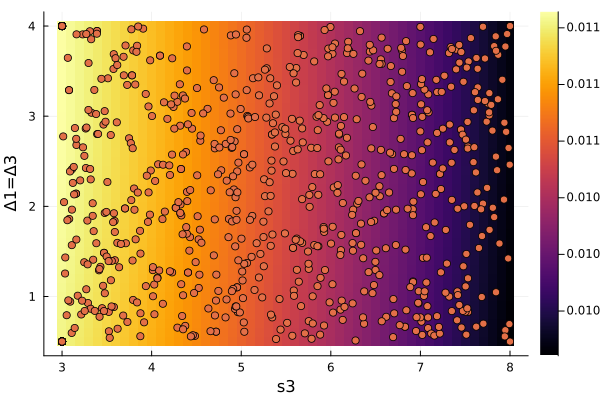

In [44]:
# variables = ["s1", "s2", "s3", "s4", "Δ1=Δ3", "Δ2", "Δ4"]
variables = ["s1", "s3", "s4", "Δ1=Δ3", "Δ4"]

idx1 = 2
idx2 = 4

list1 = opt.lowerbounds[idx1]:0.1:opt.upperbounds[idx1]
list2 = opt.lowerbounds[idx2]:0.1:opt.upperbounds[idx2]

preds_mat = zeros(length(list1), length(list2))
points = zeros(5, 1)

for (i, val1) ∈ enumerate(list1)
    for (j, val2) ∈ enumerate(list2)
        points[:,1] .= opt.model_optimizer
        points[idx1,1] = val1
        points[idx2,1] = val2
        preds_mat[i,j] = predict_y(opt.model, points)[1][1]
    end
end
heatmap(list1, list2, preds_mat')
scatter!(opt.model.x[idx1,:], opt.model.x[idx2,:], legend=nothing, xlabel=variables[idx1], ylabel=variables[idx2])

In [112]:
opt.acquisition

UpperConfidenceBound{BrochuBetaScaling}(BrochuBetaScaling(0.1), 9.530831449357468)

In [30]:
opt.model_optimizer

7-element Vector{Float64}:
  4.0
  3.2953050501635595
  0.1860363733133069
  4.0
  4.0
 -5.0
 27.801602313493724

In [31]:
opt.observed_optimizer

7-element Vector{Float64}:
  4.0
  4.0
  0.0
  4.0
  0.5
 -1.0
 50.0

In [21]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]

moving_average (generic function with 1 method)

In [42]:
opt.func = f

f (generic function with 1 method)

In [43]:
methods(f)

# 1 method for generic function "f" from Main:
 [1] f(x)
     @ In[38]:16

## Running a single configuration

In [58]:
temp = @with_unit 0.1 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]

params = MutableNamedTuple(t_end = 1e-3, n_values = 20,
                            pol1_x=σ⁻, pol2_x=σ⁺, pol3_x=σ⁻, pol4_x=σ⁺, 
                            s1=2.0, s2=0.0, s3=0.05, s4=0.05,
                            Δ1=4.0Γ, Δ2=-0.8Γ, Δ3=-1.0Γ, Δ4=+0.5Γ, 
                            B_gradient = 30, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = 4e-3)
;

results = simulate_particles_v2(package, params);

In [60]:
density(params.t_end, results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories)

36.24340520601817

## Scanning configurations

In [55]:
# fixed:
t_end = 30e-3 #s
n_values = 20
ramp_time = 4e-3 #s
B_gradient = 30 #G/cm

temp = @with_unit 0.5 "mK"
diameter = @with_unit 0.6 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]

# variable:
pol1_x_list = [σ⁻]
pol2_x_list = [σ⁺]
pol3_x_list = [σ⁻]
pol4_x_list = [σ⁺]

s1_list = [1.5, 2.0, 2.5]
s2_list = [0.0]
s3_list = [0.05, 0.1]
s4_list = [0.05, 0.1]

Δ1_list = [2.0, 4.0, 6.0] .* Γ
Δ2_list = [0.0]
Δ3_list = [-0.5, -1.0, -1.5] .* Γ
Δ4_list = [0.5, 1.0, 1.5] .* Γ

lists = [pol1_x_list, pol2_x_list, pol3_x_list, pol4_x_list,
        s1_list, s2_list, s3_list, s4_list,
        Δ1_list, Δ2_list, Δ3_list, Δ4_list]

n_scans = 1
for l in lists
   n_scans *= length(l) 
end

comments = "scan d3 +- 1MHz";
saving_dir = make_scan_folder(lists, working_dir, 1, comments);

scan_counter = 0
indicies = [
    1,1,1,1, 
    1,1,1,1, 
    1,1,1,1
];

In [ ]:
while scan_counter < n_scans
    @printf("============= configuration %i / %i =============", scan_counter+1, n_scans)
    println()
    
    pol1_x = pol1_x_list[indicies[1]]
    pol2_x = pol2_x_list[indicies[2]]
    pol3_x = pol3_x_list[indicies[3]]
    pol4_x = pol4_x_list[indicies[4]]
    s1 = s1_list[indicies[5]]
    s2 = s2_list[indicies[6]]
    s3 = s3_list[indicies[7]]
    s4 = s4_list[indicies[8]]
    Δ1 = Δ1_list[indicies[9]]
    Δ2 = Δ2_list[indicies[10]]
    Δ3 = Δ3_list[indicies[11]]
    Δ4 = Δ4_list[indicies[12]]
    
    params = MutableNamedTuple(t_end = t_end, n_values = n_values,
                            pol1_x=pol1_x, pol2_x=pol2_x, pol3_x=pol3_x, pol4_x=pol4_x, 
                            s1=s1, s2=s2, s3=s3, s4=s4,
                            Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                            B_gradient = B_gradient, 
                            temp=temp, diameter=diameter, 
                            displacement=displacement, kick=kick,
                            ramp_time = ramp_time)

    test_i = log_test_info(saving_dir,1,params)
    
    results = simulate_particles(package, params, params.n_values);

    save_results(saving_dir, test_i, results)
    
    scan_counter += 1 
    next_configuration!(lists, indicies)
    
end
;

============= configuration 1 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 2 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 3 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 4 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:14


============= configuration 5 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:23


============= configuration 6 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


============= configuration 7 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


============= configuration 8 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:29


============= configuration 9 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 10 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:16


============= configuration 11 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:28


============= configuration 12 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


============= configuration 13 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:26


============= configuration 14 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 15 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 16 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 17 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 18 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 19 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 20 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


============= configuration 21 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 22 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:30


============= configuration 23 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 24 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:33


============= configuration 25 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


============= configuration 26 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:49


============= configuration 27 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:48


============= configuration 28 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:37


============= configuration 29 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:47


============= configuration 30 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


============= configuration 31 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:53


============= configuration 32 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


============= configuration 33 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


============= configuration 34 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:38


============= configuration 35 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 36 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 37 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:35


============= configuration 38 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:36


============= configuration 39 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 40 / 324 =============


Progress:  70%|█████████████████████████████            |  ETA: 0:00:37┌ Error: Error watching manifest
│   exception =
│    LoadError: UndefVarError: `@reexport` not defined
│    in expression starting at C:\Users\Christian\.julia\packages\StatsFuns\atA5S\src\StatsFuns.jl:8
└ @ Revise C:\Users\Christian\.julia\packages\Revise\Kw99o\src\pkgs.jl:477
Progress: 100%|█████████████████████████████████████████| Time: 0:01:27


============= configuration 41 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:03


============= configuration 42 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:50


============= configuration 43 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:30


============= configuration 44 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:40


============= configuration 45 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:48


============= configuration 46 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:08


============= configuration 47 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 48 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


============= configuration 49 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 50 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:51


============= configuration 51 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 52 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:43


============= configuration 53 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:50


============= configuration 54 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 55 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:39


============= configuration 56 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 57 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:42


============= configuration 58 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:34


============= configuration 59 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:45


============= configuration 60 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 61 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:48


============= configuration 62 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:56


============= configuration 63 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 64 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:49


============= configuration 65 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:52


============= configuration 66 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:00


============= configuration 67 / 324 =============


Progress:  25%|███████████                              |  ETA: 0:04:54┌ Error: Error watching manifest
│   exception =
│    LoadError: UndefVarError: `@reexport` not defined
│    in expression starting at C:\Users\Christian\.julia\packages\StatsFuns\atA5S\src\StatsFuns.jl:8
└ @ Revise C:\Users\Christian\.julia\packages\Revise\Kw99o\src\pkgs.jl:477
Progress: 100%|█████████████████████████████████████████| Time: 0:01:44


============= configuration 68 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:54


============= configuration 69 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:02:04


============= configuration 70 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:53


============= configuration 71 / 324 =============


Progress: 100%|█████████████████████████████████████████| Time: 0:01:53
